In [1]:
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
from math import isnan
from scipy import stats
from scipy.stats import ttest_ind
%matplotlib inline

# Import libiraires for textual data analysis

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
from gensim.models.phrases import Phrases
from nltk import FreqDist

# Language detection
from langdetect import detect


#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Preliminary Data Cleaning

As suggested by TA, our team should not only bitcoin, but also expand our horizons to some other crypto currencies. Therefore, our team has update the keyword as follows to filter the dataset from "Quotebank", and we will perform our work in the filtered dataset.

["bitcoin", "BTC", "crypto asset", "crypto currenc", "cryptos", "crypocurrenc", 'Ethereum', 'MIOTA', 'XMR', 'Monero', 'EOS', 'XLM ', 'Cardano', 'Litecoin', 'LTC']

In [2]:
df = pd.read_csv("./data/quotes-BTC.csv")
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E
2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E
3,2015-03-25-030626,I have to learn to work as part of a team and ...,Mat Jackson,['Q5825983'],2015-03-25 08:56:14,1,"[['Mat Jackson', '0.7861'], ['None', '0.2139']]",['http://www.autosport.com/news/report.php/id/...,E
4,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E


In [3]:
# Check the unique value in the phase column
# And drop the column if there is only one value in the column
if len(df.phase.unique()) == 1:
    print("column 'phase' only contains 1 unique value, thus drop")
    df.drop(columns=["phase"], inplace=True)


# Check whether all the name are actually unique (lower and upper letter)
# Convert column 'speaker' to lower case
if len(df["speaker"].unique()) != len(df["speaker"].str.lower().unique()):
    print("Detect same name with letter in both lower and upper case, thus all lower case")
    df["speaker"] = df["speaker"].str.lower()

column 'phase' only contains 1 unique value, thus drop
Detect same name with letter in both lower and upper case, thus all lower case


In [4]:
# Transform column "date": downs to date
# Preverse "year" column to facilitate later access
df["year"]  = pd.DatetimeIndex(df.date).year
df["month"] = pd.DatetimeIndex(df.date).month
df["day"]   = pd.DatetimeIndex(df.date).day
df["date"]  = pd.to_datetime(df[["year", "month", "day"]])
df.drop(columns=["month", "day"], inplace=True)

## General Topic Modelling

### Data Pre-process

As mentioned in our proposal, the first task is to discover what topics are popular in the field of crypto currencies. By nature, this task involves applying unsupervised topic modelling on the quotations. To do so, we are going to train the Latent Dirichlet Allocation (LSA) model over the quotations.

Let's start by looking at the statistics for the quotations, e.g. `#tokens` in each quotation, which is not covered in the initial analysis.

In [5]:
# Remove parser from nlp pipeline as we do not need the dependency information
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe("parser")

('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f7f361cbca0>)

In [6]:
# Have a new dataframe with selected columns for topic modelling
df_quotation = df[["year", "date", "quotation", "qids"]]

# Casefolding (appropriate to use in our study)
df_quotation["quotation"] = df_quotation["quotation"].str.lower()

# Create a new column to store the tokenised quotations to facilitate later access
df_quotation["tokenised_quotation"] = df_quotation.quotation.apply(lambda quotation: nlp(quotation))

# Create a new column store the number of tokens in the original quotations
df_quotation["num_token"] = df_quotation.tokenised_quotation.apply(lambda quotation: len([token.text for token in quotation]))

df_quotation.head()

,year,date,quotation,qids,tokenised_quotation,num_token
0,2015,2015-10-04,litecoin shows there is a simple fix for spam ...,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']","(litecoin, shows, there, is, a, simple, fix, f...",12
1,2015,2015-09-15,we believe that you deserve to reap the benefi...,['Q57623555'],"(we, believe, that, you, deserve, to, reap, th...",53
2,2015,2015-02-06,amex needs to get into bitcoin or one of the o...,['Q7231593'],"(amex, needs, to, get, into, bitcoin, or, one,...",15
3,2015,2015-03-25,i have to learn to work as part of a team and ...,['Q5825983'],"(i, have, to, learn, to, work, as, part, of, a...",23
4,2015,2015-06-22,if each bitcoin has a history and people know ...,['Q46997142'],"(if, each, bitcoin, has, a, history, and, peop...",24


In [7]:
# Generate statistics of #token
df_quotation.num_token.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
num_token,26316.0,38.131935,29.655363,4.0,19.0,31.0,49.0,488.0


From the statstics above, we know that around 25% of quotations consists of 19 tokens with stop words and punctuations, whereas the minimum #token in a quotation in 4. Moreover, approximately 75% of quotations having #token less than 49, whereas the maximum #token is 488, which means the rest 25% of quotations have a very high variance w.r.t. #tokens. Let's plot the distribution of #token to get more comprehensive information.

Text(0.5, 1.0, 'Distribution of #token in each quotation')

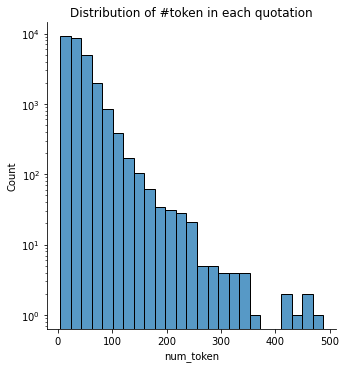

In [8]:
# Plot distribution of #token
sns.displot(df_quotation.num_token, bins=25)
plt.yscale('log')
plt.title("Distribution of #token in each quotation")

From the distribution plot above we can clearly seen that, there are outlier quotations with more than 400 tokens in a quotations, let's see how these quotations look like: 

In [9]:
df_quotation[df_quotation.num_token > 400]

,year,date,quotation,qids,tokenised_quotation,num_token
2930,2016,2016-08-08,"following the theft on august 2nd, the bitfine...",[],"(following, the, theft, on, august, 2nd, ,, th...",425
3139,2016,2016-08-08,"following the theft on august 2nd, the bitfine...",[],"(following, the, theft, on, august, 2nd, ,, th...",425
3645,2016,2016-08-06,"in 1996, congress amended the safe drinking wa...",[],"(in, 1996, ,, congress, amended, the, safe, dr...",432
6533,2017,2017-07-14,behind the conflict is an ideological split ab...,[],"(behind, the, conflict, is, an, ideological, s...",453
15815,2018,2018-06-27,"simply put, the administration has fallen far ...",['Q119546'],"(simply, put, ,, the, administration, has, fal...",450
18334,2018,2018-01-22,"data: image/jpeg; base64, / 9j/4aaqskzjrgabaqa...",[],"(data, :, image, /, jpeg, ;, base64, ,, /, 9j/...",488


Two issues have been detected from these outliers, **1)** duplicated quotations and **2)** gibberish quotations.

In [10]:
# Print duplciate quotations to see the difference
print(df_quotation.loc[2930,:].quotation)
print(df_quotation.loc[3139,:].quotation)

following the theft on august 2nd, the bitfinex team has been working tirelessly towards bringing the platform back online in a secure and controlled manner. we have finalized the accounting of losses incurred and are currently coordinating strategic plans for compensating customers. we intend to come online within 24-48 hours with limited platform functionality. additional announcements will be made as we progressively enable more platform features and return to full operations. we appreciate that our customers and the public want this handled quickly, but it needs to be done a way in which all assets are secure and immune from vulnerabilities. every resource is being leveraged to make that happen in a safe and optimal way. as disclosed in earlier announcements, all withdrawals, open orders, and open funding offers have been canceled and all financed positions have been settled. exact settlement prices were published on august 3rd. after much thought, analysis, and consultation, we ha

For duplicated quotations, this is weird as we have already dropped duplicates when filtering data. After looking into quotation **2930** and **3139**, we found that the only difference between these two quotations is the dash symbol is "-" in **2930**, whereas in **3193** it becomes " -- ". To address this issue, we can calculate the edit distance between quotations without puncutations and keep only one from quotations with 0 edit distance. However, this is a quite expensive operation regarding time and space complexity, so we will do it later when we are working on subsets with fewer quotations.

For gibberish quotations, e.g. **18334**, we can address this issue by counting the number of punctuations('PUNCT') and symbols('SYM') in the quotation or computing the average length of tokens in a quotation with punctuations and symbols excluded, and inspect quotations with large values for the counting or average length. Here we prefer the former way.

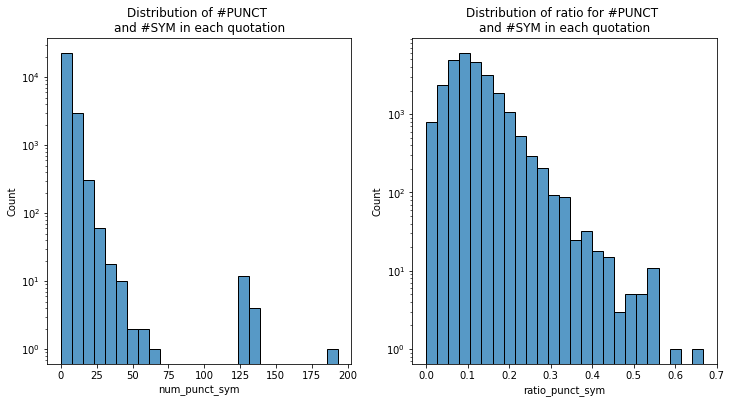

In [11]:
# Detect gibberish quotation 

# Create a new column to store the number of token with pos_tag "PUNCT" and "SYM"
df_quotation["num_punct_sym"] = \
df_quotation.tokenised_quotation.apply(lambda quotation: len([token.text 
                                                         for token 
                                                         in quotation
                                                         if (token.pos_ == "PUNCT" or token.pos_ == "SYM")]))

# We create another column to store the ratio of #"PUNCT" and #"SYM" in a quotation
# as an auxiliary feature
df_quotation["ratio_punct_sym"] = df_quotation["num_punct_sym"] / df_quotation["num_token"]

# Plot the distribution of #PUNCT and # SYM in each quotation to gain a intuition
# Plot the distribution of Ratio as well

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fst_plot = sns.histplot(df_quotation.num_punct_sym, bins=25, ax=axes[0])
fst_plot.set_title("Distribution of #PUNCT \nand #SYM in each quotation")
fst_plot.set_yscale('log')

snd_plot = sns.histplot(df_quotation.ratio_punct_sym, bins=25, ax=axes[1])
snd_plot.set_title("Distribution of ratio for #PUNCT \nand #SYM in each quotation")
snd_plot.set_yscale('log')


As can be seen from the left distribution plot, the obvious outliers are those quotations with more than 125 PUNCTs and SYMs.

In [12]:
df_quotation["ratio_punct_sym"].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
ratio_punct_sym,26316.0,0.110212,0.058253,0.0,0.071429,0.1,0.137931,0.666667


After many experiments, we decided to select rows where `num_punct_sym` > 50 and `ratio_punct_sym` > its 3-quantile (0.134831) and inspect those quotations.

In [13]:
gibb_quotations = df_quotation[(df_quotation.num_punct_sym > 50) & (df_quotation.ratio_punct_sym > 0.134831)]\
                              .sort_values(by=['num_punct_sym'], ascending=False)

display(gibb_quotations)

# Print typical example of gibberish quotation 
print(df_quotation.loc[831, :].quotation)

,year,date,quotation,qids,tokenised_quotation,num_token,num_punct_sym,ratio_punct_sym
18334,2018,2018-01-22,"data: image/jpeg; base64, / 9j/4aaqskzjrgabaqa...",[],"(data, :, image, /, jpeg, ;, base64, ,, /, 9j/...",488,193,0.395492
1970,2015,2015-06-30,"since my first visit, i kind of & hellip;' ); ...",[],"(since, my, first, visit, ,, i, kind, of, &, h...",250,133,0.532000
399,2015,2015-06-04,"he had schools he was interested in, and & hel...",[],"(he, had, schools, he, was, interested, in, ,,...",249,132,0.530120
1525,2015,2015-07-06,i find it ironic that ted & hellip;' ); ua_tw_...,['Q63879'],"(i, find, it, ironic, that, ted, &, hellip, ;,...",248,132,0.532258
834,2015,2015-07-05,i'd love to participate & hellip;' ); ua_tw_44...,[],"(i, 'd, love, to, participate, &, hellip, ;, '...",245,132,0.538776
1204,2015,2015-06-09,the potential to develop average or better too...,"['Q1058609', 'Q17303653', 'Q269500', 'Q5066355...","(the, potential, to, develop, average, or, bet...",241,131,0.543568
230,2015,2015-05-13,"without getting vague here, all contracts that...","['Q1280022', 'Q16643824', 'Q25190360']","(without, getting, vague, here, ,, all, contra...",254,131,0.515748
195,2015,2015-06-09,"yesterday, i was anxious and itching -- wantin...",[],"(yesterday, ,, i, was, anxious, and, itching, ...",258,131,0.507752
1037,2015,2015-06-02,it' s hard here. they dry out in & hellip;' );...,[],"(it, ', s, hard, here, ., they, dry, out, in, ...",243,130,0.534979
831,2015,2015-07-10,this is one of the most incredible collections...,['Q76'],"(this, is, one, of, the, most, incredible, col...",243,130,0.534979


this is one of the most incredible collections of mammoth fossils anywhere in the country. & hellip;' ); ua_tw_60081. settitle (formattweet (`obama signs waco mammoth national monument declaration' )); ua_tw_60081. addmediaitem (image60081); var params_60081 = {useraction: ua_60081, replyuseraction: ua_60081, cssprefix:' #gig - div-buttons-60081-top' , sharebuttons: [ {provider: `facebook' , enablecount: `false' , icononly: `true' , iconimgup: `data: image/svg + xml; base64, pd94bwwgdmvyc2lvbj0ims4wiiblbmnvzgluzz0idxrmltgipz4ncjwhls0gr2vuzxjhdg9yoibbzg9izsbjbgx1c3ryyxrvciaxny4xljasifnwrybfehbvcnqgugx1zy1jbiauifnwrybwzxjzaw9uoia2ljawiej1awxkidapicatlt4ncjwhre9dvflqrsbzdmcgufvcteldicitly9xm0mvl0rurcbtvkcgms4xly9ftiigimh0dha6ly93d3cudzmub3jnl0dyyxboawnzl1nwry8xljevrfrel3n2zzexlmr0zci + dqo8c3znihzlcnnpb249ijeumsigawq9ikxhewvyxzeiihhtbg5zpsjodhrwoi8vd3d3lnczlm9yzy8ymdawl3n2zyigeg1sbnm6egxpbms9imh0dha6ly93d3cudzmub3jnlze5otkvegxpbmsiihg9ijbweciget0imhb4ig0kcsb2awv3qm94psiwidagmtiwmcazmzmiig

As can be seem from the above typical example of a gibberish quotation, gibberish quotations usually have the first few tokens syntactically and semantically correct, but the majority of the quotation is gibberish. After inspecting all the quotations from the above dataframe, we confirm that these quotations are all gibberish quotations, and can be therefore removed.

In [14]:
# Remove the observed duplicated quotations
df_quotation.drop(3139, inplace=True)

# Remove the observed gibberish quotations
df_quotation.drop(gibb_quotations.index, inplace=True)

Last but not least, we have observed quotations that are non-English, e.g. French. Therefore, we are going to remove non-English quotations by performing language detection on the quotations. The reason why we are remove non-English at the end of data preprocessing is because language detection performs better on long sentences, whereas short quotations are removed at this point.

Text(0.5, 1.0, 'Distribution of non-English quotaions')

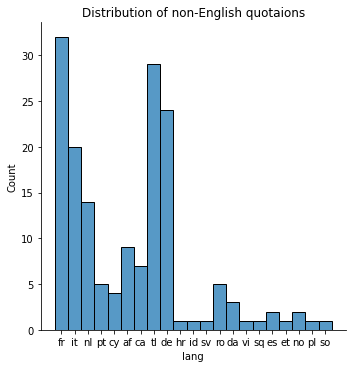

In [15]:
# Identify language of the quotation, in our study we only consider English study
from langdetect import detect

# Create a column to store the detected language on non-stop words
df_quotation["lang"] = df_quotation.quotation.apply(lambda quotation: detect(quotation))

# Have non-English quotations as a separate dataframe
df_non_en = df_quotation[df_quotation.lang != 'en']

# Plot distribution of detected language
sns.displot(df_non_en.lang, bins=25)
plt.title("Distribution of non-English quotaions")

At this stage, human intervention is required to inspect whether the language is identified correctly as it is very likely for English quotations to be misclassified. To save time, we will inspect languages with <= 15 quotation at one go. And for "French", "Italian", “German” and "Tagalog", we will inspect them separately.

In [16]:
pd.set_option('display.max_rows', None)

# inspect languages with <= 15 quotations
display(df_non_en[["quotation", "lang"]].groupby('lang')\
                                        .filter(lambda x : x['lang'].shape[0] <= 15))
        
# inspect German
df_de = df_non_en[df_non_en.lang == 'de'][["quotation", "lang"]]
display(df_de)
german_idx = df_de.index

# inspect French
display(df_non_en[df_non_en.lang == 'fr'][["quotation", "lang"]])

# inspect Italian
display(df_non_en[df_non_en.lang == 'it'][["quotation", "lang"]])

# inspect Tagalog
df_tl = df_non_en[df_non_en.lang == 'tl'][["quotation", "lang"]]
display(df_tl)
tagalog_idx = df_tl.index

,quotation,lang
261,benefits we enjoy at btc,nl
788,estamos muito entusiasmados em lan & ccedil; a...,pt
826,"gavin didn't invent bitcoin,",nl
1004,"yn fwy diweddar, ac yn genedlaethol, maen nhw ...",cy
1346,"i said, `no, you don't. bitcoin does. '",cy
1386,we'd do it again and we're glad we were doing ...,af
1954,bitcoins are a political project,ca
2191,damos nossas mais profundas condolências aos f...,pt
3017,xarxa de bancs de tumors sponsored by pla dire...,ca
3839,"bitcoin has enormous momentum,",pt


,quotation,lang
3759,"bitcoin haben noch nicht bewiesen, dass sie zu...",de
3943,"ich kenne einige leute, die bei bitcoin engagi...",de
4381,virtuelle währungen wie bitcoin sind nicht wir...,de
5607,ist der bitcoin ein massenphänomen? sicherlich...,de
6580,ein zahlungsmittel sollte ja eine wertstabilit...,de
6797,eine gefahr für die stabilität würde es bedeut...,de
9548,der bitcoin ist mangels kontrolle kein seriöse...,de
10054,"ich sehe bitcoin als tulpenmanie, was eine auß...",de
10331,die berichterstattung über immer neue bitcoin-...,de
10470,"es gibt kunden, die interessiert die bitcoin-e...",de


,quotation,lang
114,nous adressons nos plus sincères condoléances ...,fr
363,"dans ces moments de profonde tristesse, nos pe...",fr
2211,the best-ever bitcoin cannabis drone entrepren...,fr
5721,bitcoin explained like you're five,fr
6280,"bitcoin, est. 2009,",fr
6297,"bitcoin transactions are irreversible,",fr
7090,"bitcoin improvement plan 91,",fr
7454,short bitcoin/long dec silver futures,fr
9981,clear bitcoin futures contracts for certain cl...,fr
10336,why multiple implementations are quite importa...,fr


,quotation,lang
180,didn't call it bitcoin,it
1115,"21 million bitcoin, infinite possibilities.",it
3246,bitcoin: digital gold?,it
3780,no regular bitcoin core contributors support [...,it
4524,"no, no.. no merchants accept bitcoin,",it
5538,pool. minemonero. pro:5555,it
6437,"i am not a bitcoin multimillionaire,",it
8526,"i'm not quitting litecoin,",it
10434,ultimate guide to bitcoin.,it
11230,a billion data bitcoins and microchips,it


,quotation,lang
2625,"the bitcoin big bang,",tl
2808,"kasi na-subject ito sa maraming review, may le...",tl
3408,sa amin wala namang problema doon dahil unang-...,tl
5236,"bitcoin may hit $1,000,000",tl
6310,"bitcoin, is not going away anytime soon.",tl
7311,sinabi rin niya kay jeron na naging coach na n...,tl
9557,sila rin ang aming avenue para ma-mentor `yung...,tl
11690,dapat ba tayo magbunyi at matuwa dahil sa waka...,tl
13077,nagpapa-salamat po tayo sa ating mga mambabata...,tl
13672,"may mga proposal yung grp, at yung btc asked u...",tl


Index of rows to be deleted for language with <= 15 quotations: [788, 1004, 2191, 3017, 16634, 17035]

Index of rows to be deteted for French: [114, 363]

All rows with Germany quotations are identified correctly.

All row with Italian quotation are actually English. 

The majority of rows with Tagalog quotations are identified correctly(at least not English), except: [274, 5236, 6310, 18456, 19459, 20877]

In [17]:
# Get a list of rows to be detect
rows_tbd = [788, 1004, 2191, 3017, 16634, 17035, 114, 363]
rows_tbd.extend(german_idx)
rows_tbd.extend(tagalog_idx)

for idx in [5236, 6310, 18456, 19459, 20814]:
    rows_tbd.remove(idx)
print("Number of non-English quotations to be deleted: {}".format(len(rows_tbd)))

# Delete from df_quotation
df_quotation.drop(rows_tbd, inplace=True)

Number of non-English quotations to be deleted: 56


In [18]:
# Restore setting
pd.set_option('display.max_rows', 10)

### Topic Detection for the entire corpus

First, we are going to count #token that are neither punctuations, number nor stop word, and remove quotations that contains too few meaningful informations.

In [19]:
# Update stopword list with custom stopword

# Due to the existing bug of spacy stopword undating, we have to update stopword in this way
stop_list = ["year", "month", "years", "months", "week", "weeks", "day", "days", "ago", "hour", "hours", 
             "minutes", "minutes", "seconds", "means", "think", "use", "basically", "way", "anymore"]

for stop_word in stop_list:
    lex = nlp.vocab[stop_word]
    lex.is_stop = True

# Get a list of alphabetic, non-stopword and Lemmatised tokens and keep token with length > 2
df_quotation["nonstop_word"] = df_quotation.tokenised_quotation.apply(lambda quotation: [token.lemma_ 
                                                                                         for token 
                                                                                         in quotation
                                                                                         if token.is_alpha and not token.is_stop and len(token) > 2])

# Count the number of alphabetic and non-stopword tokens in each quotation
df_quotation["num_nonstop_word"] = df_quotation.nonstop_word.map(len)

df_quotation.sort_values(by=['num_nonstop_word'], ascending=False).head()

,year,date,quotation,qids,tokenised_quotation,num_token,num_punct_sym,ratio_punct_sym,lang,nonstop_word,num_nonstop_word
15815,2018,2018-06-27,"simply put, the administration has fallen far ...",['Q119546'],"(simply, put, ,, the, administration, has, fal...",450,45,0.100000,en,"[simply, administration, fall, far, short, add...",207
6533,2017,2017-07-14,behind the conflict is an ideological split ab...,[],"(behind, the, conflict, is, an, ideological, s...",453,57,0.125828,en,"[conflict, ideological, split, bitcoin, rightf...",196
2930,2016,2016-08-08,"following the theft on august 2nd, the bitfine...",[],"(following, the, theft, on, august, 2nd, ,, th...",425,39,0.091765,en,"[follow, theft, august, bitfinex, team, work, ...",170
13637,2018,2018-10-18,fidelity investment's announcement that it wil...,[],"(fidelity, investment, 's, announcement, that,...",316,20,0.063291,en,"[fidelity, investment, announcement, store, tr...",153
13912,2018,2018-08-23,"for this target to be reached, everybody is im...",[],"(for, this, target, to, be, reached, ,, everyb...",322,44,0.136646,en,"[target, reach, everybody, important, importan...",151


In [20]:
df_quotation.num_nonstop_word.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
num_nonstop_word,26240.0,14.98548,11.91235,0.0,7.0,12.0,19.0,207.0


As indicated by the statistics above, the minimum number of words in a quotation in 0. Therefore, we are going drop short quotations with <= 3 words. Also, we are going to drop auxiliary columns we created for previous analysis.

In [21]:
df_quotation.drop(columns=["num_token", "num_punct_sym", "ratio_punct_sym"])
df_quotation = df_quotation[df_quotation.num_nonstop_word > 3]
df_quotation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24789 entries, 0 to 26315
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year                 24789 non-null  int64         
 1   date                 24789 non-null  datetime64[ns]
 2   quotation            24789 non-null  object        
 3   qids                 24789 non-null  object        
 4   tokenised_quotation  24789 non-null  object        
 5   num_token            24789 non-null  int64         
 6   num_punct_sym        24789 non-null  int64         
 7   ratio_punct_sym      24789 non-null  float64       
 8   lang                 24789 non-null  object        
 9   nonstop_word         24789 non-null  object        
 10  num_nonstop_word     24789 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 2.3+ MB


In [22]:
# Convert the `non_stop` word column to a flatten list
# Here, we only have unigram and we will add bigram and trigram later
unigram = df_quotation.nonstop_word.explode().to_list()

So far, we aleady have a list storing all the unigrams that will be used for topic detection, and we are going to add name entities, frequent bigrams and trigrams as well to make the training data more comprehensive.

In [23]:
# Retrieve the non-stop words from all the remaining quotations
sentences = df_quotation.nonstop_word.to_list()


# Define a function to split sentences into chunks
# We have to split into chunks, otherwise won't fit in memory
def get_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        

# Define chunk size (how many sentences in a chunk)
size = 50

In [24]:
chunks = list()
chunks_of_sents = [x for x in get_chunks(sentences,size)]

# Group each chunk as a sentence
for chs in chunks_of_sents:
    grouped_chunk = list()
    
    for sens in chs:
        grouped_chunk.extend(sens)
        
    chunks.append(" ".join(grouped_chunk))

In [25]:
# Retireve name entities and store in a list
name_entity = []

for doc in nlp.pipe(chunks, n_threads=5, batch_size=10):
    
    # Named entities
    ents = doc.ents  

    # Add named entities, but only if they are a compound of more than one word.
    name_entity.extend([str(entity) for entity in ents if len(entity) > 1])

/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/spacy/language.py:774: DeprecationWarning: [W016] The keyword argument `n_threads` is now deprecated. As of v2.2.2, the argument `n_process` controls parallel inference via multiprocessing.
  warnings.warn(Warnings.W016, DeprecationWarning)


In [26]:
# We need to first concat unigram list and name entity list
doc = unigram + name_entity

Next, we will add bigram and trigram into our processed doc. Here we are going to use Python `NLTK` Package as it allows us to detect possibly non-contiguous bigrams and trigrams, which would be more helpful. Also, `NLTK` is more efficient due to its high speed.

In [27]:
from nltk.collocations import *
import nltk

In [28]:
# Find bigram with more than 100 occurrences
finder_bi = BigramCollocationFinder.from_words(doc, window_size = 3)
finder_bi.apply_freq_filter(100)

# Show bigrams in a descending order according to their frequency
bigram = list(finder_bi.ngram_fd.items())
bigram.sort(key=lambda item: item[-1], reverse=True)
bigram[:30]

[(('bitcoin', 'bitcoin'), 1212),
 (('like', 'bitcoin'), 612),
 (('crypto', 'asset'), 608),
 (('bitcoin', 'blockchain'), 602),
 (('bitcoin', 'cash'), 601),
 (('buy', 'bitcoin'), 601),
 (('crypto', 'currency'), 586),
 (('digital', 'currency'), 584),
 (('bitcoin', 'price'), 543),
 (('bitcoin', 'currency'), 537),
 (('currency', 'bitcoin'), 521),
 (('people', 'bitcoin'), 505),
 (('bitcoin', 'go'), 463),
 (('price', 'bitcoin'), 454),
 (('blockchain', 'technology'), 406),
 (('bitcoin', 'ethereum'), 400),
 (('value', 'bitcoin'), 383),
 (('bitcoin', 'like'), 371),
 (('bitcoin', 'cryptocurrencie'), 370),
 (('bitcoin', 'people'), 322),
 (('bitcoin', 'exchange'), 320),
 (('long', 'term'), 316),
 (('store', 'value'), 314),
 (('bitcoin', 'transaction'), 313),
 (('bitcoin', 'market'), 313),
 (('virtual', 'currency'), 306),
 (('blockchain', 'bitcoin'), 305),
 (('money', 'bitcoin'), 304),
 (('market', 'bitcoin'), 283),
 (('bitcoin', 'value'), 282)]

In [29]:
# Find trigram with more than 20 occurrence
finder_tri = TrigramCollocationFinder.from_words(doc, window_size = 4)
finder_tri.apply_freq_filter(20)

# Show bigrams in a descending order according to their frequency
trigram = list(finder_tri.ngram_fd.items())
trigram.sort(key=lambda item: item[-1], reverse=True)
trigram[:30]

[(('digital', 'currency', 'bitcoin'), 130),
 (('bitcoin', 'digital', 'currency'), 121),
 (('bitcoin', 'store', 'value'), 97),
 (('bitcoin', 'blockchain', 'technology'), 92),
 (('virtual', 'currency', 'bitcoin'), 87),
 (('currency', 'like', 'bitcoin'), 81),
 (('bitcoin', 'virtual', 'currency'), 79),
 (('bitcoin', 'bitcoin', 'cash'), 79),
 (('buy', 'sell', 'bitcoin'), 76),
 (('blockchain', 'technology', 'bitcoin'), 75),
 (('bitcoin', 'crypto', 'currency'), 74),
 (('bitcoin', 'cash', 'bitcoin'), 70),
 (('cryptocurrencie', 'like', 'bitcoin'), 66),
 (('crypto', 'currency', 'bitcoin'), 61),
 (('people', 'buy', 'bitcoin'), 60),
 (('initial', 'coin', 'offering'), 60),
 (('long', 'term', 'bitcoin'), 55),
 (('bitcoin', 'long', 'term'), 53),
 (('bitcoin', 'digital', 'gold'), 52),
 (('anti', 'money', 'laundering'), 50),
 (('bitcoin', 'future', 'contract'), 45),
 (('buy', 'bitcoin', 'bitcoin'), 43),
 (('distribute', 'ledger', 'technology'), 42),
 (('bitcoin', 'blockchain', 'bitcoin'), 41),
 (('bitc

Next, we are going to use `gensim` to do topic modelling, and we need to transform all the data we have into format that is compatible with `gensim` - list of list.

In [30]:
# First retrieve non-stop word of each quotation
gensim_doc = df_quotation.nonstop_word.to_list()

# Then transform name entity from string to list of words
gensim_doc.extend([x.split() for x in name_entity])

# Add bigram to doc
for bi in bigram:
    gensim_doc.append([x for x in bi[0]])

# Add trigram to doc
for tri in trigram:
    gensim_doc.append([x for x in tri[0]])

In [31]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(gensim_doc)
print('Number of unique tokens in the orginal dictionary: %d' % len(dictionary))

# Filter out words that occur too frequently or too rarely.
MAX_FREQ = 0.5
MIN_WORDCOUNT = 5

# filter word with occurrence < 5 or word with frequency > 0.5
dictionary.filter_extremes(no_below=MIN_WORDCOUNT, no_above=MAX_FREQ)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in gensim_doc]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens in the orginal dictionary: 17021
Number of unique tokens: 6027
Number of chunks: 34619


In [32]:
# Optimization on topic modeling

from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
topic_range = np.arange(5, 21, 1)


# Fine-tuning the number of topics K by coherence score 'Cv'
def compute_coherence_values(corpus, dictionary, topic_k):
    coherence_dict = {}
    
    print("Perform cross validation to select the optimal number of topics")
    
    for k in topic_k:
        model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10)
    
        coherence_model = CoherenceModel(model=model, texts=gensim_doc, dictionary=dictionary, coherence='c_v')
        coherence_dict["{} topics".format(k)] = coherence_model.get_coherence()
    
    return coherence_dict

In [33]:
coherence = compute_coherence_values(corpus, dictionary, topic_range)

Perform cross validation to select the optimal number of topics


In [34]:
optimal_K = max(coherence, key=coherence.get)
optimal_K

'11 topics'

In [35]:
# Retrain the model by best K and plot the topics
opt_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=int(optimal_K.split()[0]), 
                                   random_state=42,
                                   chunksize=100,
                                   passes=10)

In [36]:
opt_model.show_topics(num_words=5)

[(1,
  '0.148*"currency" + 0.147*"digital" + 0.042*"fiat" + 0.041*"world" + 0.038*"coin"'),
 (0,
  '0.054*"price" + 0.027*"season" + 0.026*"go" + 0.026*"protocol" + 0.024*"lot"'),
 (6,
  '0.100*"central" + 0.039*"eth" + 0.038*"security" + 0.029*"authority" + 0.028*"foundation"'),
 (9,
  '0.134*"bank" + 0.102*"million" + 0.044*"buy" + 0.042*"percent" + 0.041*"thousand"'),
 (8,
  '0.081*"new" + 0.052*"cryptocurrency" + 0.044*"technology" + 0.038*"wright" + 0.033*"blockchain"'),
 (4,
  '0.134*"asset" + 0.100*"ethereum" + 0.041*"like" + 0.036*"etf" + 0.030*"gold"'),
 (7,
  '0.213*"crypto" + 0.050*"community" + 0.037*"payment" + 0.031*"development" + 0.022*"service"'),
 (5,
  '0.097*"trade" + 0.068*"ecosystem" + 0.031*"north" + 0.030*"come" + 0.026*"mark"'),
 (3,
  '0.184*"exchange" + 0.046*"korea" + 0.039*"south" + 0.039*"smart" + 0.038*"united"'),
 (10,
  '0.116*"dollar" + 0.059*"billion" + 0.059*"finance" + 0.039*"value" + 0.032*"eliminate"')]

In [37]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model, corpus, dictionary)
pyLDAvis.display(data)

For the entire 2015-2020 cryptocurrencies related quotations extracted from quotebank, we have detected 11 topics, and we can further group these topics into three categories:
1. Different cryptocurrencies: Bitcoin, Ethereum, XRP, and ETF
2. The technical level of cryptocurrencies and its application: blockchain technology and payment system.
3. The Financial Value and ctyptocurrencies: trading and digital asset

As mentioned in the proposal, we will go further into details of these topics. Intead, we are more interested in investigating how the hotspot topics change over time.

## How hotspot topics change periodically

Previously, we performed topic modelling for the whole corpus and detected 11 topics, where 11 is chosen by running cross validation with coherence model. Next, as mentioned in the proposal, we are going to split the processed `df_quotation` dataframe according to date the quotations were published. First and foremost, we need to have some insightful statistics to decide the time period we are going to split with.

month,1,2,3,4,5,6,7,8,9,10,11,12,mean
year,,,,,,,,,,,,,
2015,260,176,214,160,85,97,171,211,218,185,155,274,183.833333
2016,33,104,7,69,298,16,178,208,130,5,7,221,106.333333
2017,4,88,302,268,388,354,448,547,689,793,1095,1974,579.166667
2018,1401,1097,827,811,697,590,518,456,447,1027,684,398,746.083333
2019,352,396,310,283,446,418,430,411,337,328,403,264,364.833333
2020,329,352,243,102,0,0,0,0,0,0,0,0,85.500000


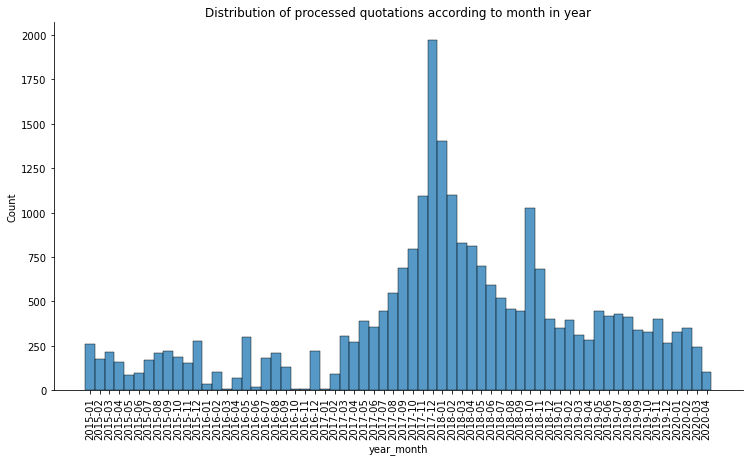

In [38]:
# Create month column
df_quotation["month"] = pd.DatetimeIndex(df_quotation.date).month

# Display the number of quotations published in each year, each month as a dataframe
df_count_ym = pd.crosstab(df_quotation.year, df_quotation.month)
df_count_ym["mean"] = df_count_ym.transpose().mean()
display(df_count_ym)

# Create a column to represent month-year
df_quotation['year_month'] = df_quotation['date'].apply(lambda x: x.strftime('%Y-%m'))

# Specify order
df_quotation['year_month'] = pd.Categorical(df_quotation['year_month'],
                                            categories=df_quotation.year_month.sort_values().unique(),
                                            ordered=True)

g = sns.displot(df_quotation['year_month'])
plt.tick_params(axis='x', rotation=90)
plt.title("Distribution of processed quotations according to month in year")
g.fig.set_figwidth(12)
g.fig.set_figheight(6)

As depicted by the above displot, number of quotations associated with crypto currencies are relatively low at the early stage, until June of 2017, at which point the number of quotations grew dramatically, and reached the peak with 1974 quotations during December of 2018, and is well in line with the bitcoin price movements analysed in our initial analysis. Hence, it is self-evident to say that some major events happened in crypto currencies that caused such widespread concern, and we will identify those events based on the quotations published from **2017.10** to **2018.03**. Likewise, we would also investigate what happened in 2017.11 that made its number of quotations exceptionally high. Consequently, we are going to split processed dataframe as follows:
* quotations published throughout 2015
* quotations published throughout 2016
* quotations published in 2017, from January to September
* quotations published from October 2017 to March 2018 (to identify major events)
* quotations published in 2018, from April to December
* quotations published throughout 2019
* quotations we have in 2020

The implementation will be a little bit different from the implementation for general topic modelling, as we are going to group quotations corresponding to each month, and generate bigram and trigram within each group.

### Define util functions

For code reusability, we are going to make the entire processing as functions.

In [39]:
# Separate quotations

df_quotation_2015 = df_quotation[df_quotation.year == 2015]
df_quotation_2016 = df_quotation[df_quotation.year == 2016]
df_quotation_2017 = df_quotation[(df_quotation.year == 2017) & (df_quotation.month <= 9)]
df_quotation_2018 = df_quotation[(df_quotation.year == 2018) & (df_quotation.month >= 4)]
df_quotation_2019 = df_quotation[df_quotation.year == 2019]
df_quotation_2020 = df_quotation[df_quotation.year == 2020]

event_period = ["2017-10", "2017-11", "2017-12", "2018-01", "2018-02", "2018-03"]
df_quotation_event = df_quotation[df_quotation.year_month.isin(event_period)]



In [40]:
# Measures to select best n bigrams/trigrams
BIGRAM_MEASURES = nltk.collocations.BigramAssocMeasures()
TRIGRAM_MEASURES = nltk.collocations.TrigramAssocMeasures()
SMALL_TOPIC_RANGE = np.arange(2, 11, 1)


def group_quotation_by_unique_column_value(df, col):
    """
    Split each separate dataframe by unique values in the specified column,
    group quotations in each group into a single string,
    and return the groups.
    """
    groups = list()
    unique_elem = df[col].sort_values().unique()
    
    for elem in unique_elem:
        quotations = df[df[col] == elem]
        print("Currently working on: %s" % elem)
        print('Number of quotations: %d' % len(quotations))

        # Combine all the non-stop word as a string
        grouped_quotations = " ".join(quotations.nonstop_word.explode().to_list())
        groups.append(grouped_quotations)
        print()
        
    return unique_elem, groups


def process_groups(year_month, groups):
    """
    Within monthly quotations, perform the following work: 
    extract name entity -> lemmatise tokens -> add bigrams -> add trigrams
    and return the processed groups
    """
    processed_docs = list()

    for idx, doc in enumerate(nlp.pipe(groups, n_process=5, batch_size=10)):
        # Named entities
        ents = doc.ents 

        # Lemmatise tokens
        # We check once again whether the token is stop word in case we update stopword list later
        doc = [token.lemma_ for token in doc if not token.is_stop]
        print("Number of Unigrams in {}: {}".format(year_month[idx], len(doc)))

        # Add named entities, but only if they are a compound of more than one word.
        name_entity = [str(entity) for entity in ents if len(entity) > 1]
        doc.extend(name_entity)
        print("Number of Name Entity Compounds extracted in {}: {}".format(year_month[idx], len(name_entity)))

        # Select nbest bigrams and trigrams
        # We have to set a dynamic number due to size of df varies
        n_best = int(len(doc) / 100)
        print("Number of bigrams and trigram added in {} respectively: {}".format(year_month[idx], n_best))

        # Add bigrams
        finder_bi = BigramCollocationFinder.from_words(doc, window_size = 3)
        bigram = list(finder_bi.nbest(BIGRAM_MEASURES.raw_freq, n_best))
        doc.extend([" ".join(x) for x in bigram])

        # Add trigrams
        finder_tri = TrigramCollocationFinder.from_words(doc, window_size = 4)
        trigram = list(finder_tri.nbest(TRIGRAM_MEASURES.raw_freq, n_best))
        doc.extend([" ".join(x) for x in trigram])

        processed_docs.append(doc)
        print()
        
    return processed_docs


def create_dict_corpus(processed_docs, min_wordcount, max_freq):
    """
    Create dictionary of processed docs, as well as bag of word representation
    """
    
    dictionary = Dictionary(processed_docs)
    
    # filter word with fewer occurrence or word with higher frequency
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of chunks: %d' % len(corpus))
    print()
    
    return corpus, dictionary


def generate_freq_stats_df(processed_docs):
    """
    Create a dataframe containing word and the corresponding frequency 
    """
    # Generate frequency statistics as list
    freq_dist = FreqDist([word for doc in processed_docs for word in doc])
    
    # Convert dictionary to frequeny disctionary
    freq_df = pd.DataFrame(freq_dist.items(), columns=['word', 'frequency'])
    
    return freq_df


def train_topic_detection_model(ym_order, qt_groups, min_wc, max_freq):
    """
    Training topic detection model
    Return the model itself, and the corpus & dictionary used to train the model
    """
    # Running the processing pipeline on each group
    processed_ = process_groups(ym_order, qt_groups)

    # Generate corpus and dictionary
    corpus_, dict_ = create_dict_corpus(processed_, min_wc, max_freq)

    # Compute coherence value
    coherence_ = compute_coherence_values(corpus_, dict_, SMALL_TOPIC_RANGE)

    # Drop na cohences value
    coherence_ = {k: coherence_[k] for k in coherence_ if not isnan(coherence_[k])}

    # Get the optimal number of topics
    optimal_K_ = max(coherence_, key=coherence_.get)
    print("Optimal number of topics: %s" % optimal_K_)

    # Retrain the model by best K and plot the topics
    opt_model_ = gensim.models.LdaModel(corpus=corpus_,
                                        id2word=dict_,
                                        num_topics=int(optimal_K_.split()[0]), 
                                        random_state=42,
                                        chunksize=100,
                                        passes=10)
    
    return opt_model_, corpus_, dict_


def generate_freq_stats_selected_quotations(df, kw):
    """
    A special version of generate_freq_stats
    It generates stats for quotations with selected keyword
    """
    df_kw = df[df.quotation.str.contains("|".join(kw))]
    
    # Transform the format to be compatible for topic modelling
    processed_kw = list()

    for w in kw:
        processed_kw.append(df[df.quotation.str.contains(w)].nonstop_word.explode().to_list())
        
    # Generate frequency stats dataframe
    df_kw_freq = generate_freq_stats_df(processed_kw)

    return df_kw, processed_kw, df_kw_freq


def create_corpus_dict_selected_quotations(kw, processed, min_wordcount, max_freq):
    """
    A special version of create_corpus_dict
    It generates corpus and dict for quotation with selected keyword
    """
    # Group lists to sentences for nlp tasks
    grouped = [" ".join(group) for group in processed]

    # Running nlp tasks: extract unigram, bigram, trigram and name entity compound
    grouped_processed = process_groups(kw, grouped)

    # Create corpus and dictionary
    corpus_kw, dict_kw = create_dict_corpus(grouped_processed, 
                                            min_wordcount, 
                                            max_freq)
    
    return corpus_kw, dict_kw


def train_topic_detection_model_selected_quotation(corpus_, dict_, num_topic=SMALL_TOPIC_RANGE):
    """
    A special version of Training topic detection model
    It runs cross validation on selected quotations to find the optimum number of topics
    And return the trained LDA model
    """
    
    # For a pre-defined number of topic
    if type(num_topic) == int:
        
        # Retrain the model by best K and plot the topics
        opt_model_ = gensim.models.LdaModel(corpus=corpus_,
                                            id2word=dict_,
                                            num_topics=num_topic, 
                                            random_state=42,
                                            chunksize=100,
                                            passes=10)
        
        return opt_model_
    

    # Compute coherence value
    coherence_ = compute_coherence_values(corpus_, dict_, SMALL_TOPIC_RANGE)

    # Drop na cohences value
    coherence_ = {k: coherence_[k] for k in coherence_ if not isnan(coherence_[k])}

    # Get the optimal number of topics
    optimal_K_ = max(coherence_, key=coherence_.get)
    
    print("Optimal number of topics: %s" % optimal_K_)

    # Retrain the model by best K and plot the topics
    opt_model_ = gensim.models.LdaModel(corpus=corpus_,
                                        id2word=dict_,
                                        num_topics=int(optimal_K_.split()[0]), 
                                        random_state=42,
                                        chunksize=100,
                                        passes=10)
    
    return opt_model_


### Topic modelling 2015 

In each year the number of quotations are different, and we also assumed that topics for each year's quotations vary. Follow this logic, it is reasonable to set different threshold to filter the dictionary. Therefore, before doing topic detection, we are going to adjust value for `min_wordcount` and `max_freq` based on the corresponding dataframe.

Currently working on: 2015-01
Number of quotations: 260

Currently working on: 2015-02
Number of quotations: 176

Currently working on: 2015-03
Number of quotations: 214

Currently working on: 2015-04
Number of quotations: 160

Currently working on: 2015-05
Number of quotations: 85

Currently working on: 2015-06
Number of quotations: 97

Currently working on: 2015-07
Number of quotations: 171

Currently working on: 2015-08
Number of quotations: 211

Currently working on: 2015-09
Number of quotations: 218

Currently working on: 2015-10
Number of quotations: 185

Currently working on: 2015-11
Number of quotations: 155

Currently working on: 2015-12
Number of quotations: 274



,count,mean,std,min,25%,50%,75%,max
frequency,5516.0,6.440537,33.254936,1.0,1.0,2.0,5.0,2196.0


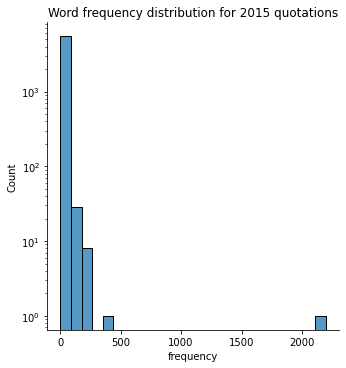

In [41]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2015, groups_2015 = group_quotation_by_unique_column_value(df_quotation_2015, col="year_month")

# Get all the lemma in 2015 quotaions
origin_doc_2015 = [subgroup.split() for subgroup in groups_2015]

# Get frequency statistics
df_stat_2015 = generate_freq_stats_df(origin_doc_2015)

# Display stats
display(df_stat_2015.describe().transpose())

# Plot distribution
sns.displot(df_stat_2015.frequency, bins=25)
plt.title("Word frequency distribution for 2015 quotations")
plt.yscale('log')

As can be concluded from the above statistics and plot, approximately half of the dictionary appeared only once, we also have two extreme outliers with more than 300 occurrence, let's see what these two words are.

In [42]:
display(df_stat_2015[df_stat_2015.frequency > 300])

# Show the occurrence for "crypto" 
# As there will be a high chance that "currency" follows right after
df_stat_2015[df_stat_2015.word.isin(["crypto", "currencies"])]

,word,frequency
1,bitcoin,2196
20,currency,357


,word,frequency
579,crypto,57


In this case, we have "bitcoin" and "currency" as outliers. For "bitcoin", it is the most famous crypto currencies, thus it is reasonable to have a higher frequency for bitcoin, and we will keep it by set `max_freq` = 1. However, for "currency" as a outlier, as we are studying crypto currencies, it is very likely for "crypto" and "currency"/"currencies" as a continuous sequence, thus we also checked the occurrence of "crypto", which is 57, whereas for "currencies" we did't spot any occurrence. For these three words, we will remove it from dictionary, not only in 2015 quotations, but also for other years.

In [43]:
for remove_word in ["crypto", "currency", "currencies"]:
    lex = nlp.vocab[remove_word]
    lex.is_stop = True  

In [44]:
# We would like to know whether "not" could be a top word
nlp.vocab["not"].is_stop = False

In [45]:
min_wordcount_2015, max_freq_2015 = 2, 1

opt_model_2015, corpus_2015, dict_2015 = train_topic_detection_model(ym_2015, groups_2015, min_wordcount_2015, max_freq_2015)

Number of Unigrams in 2015-01: 3797
Number of Name Entity Compounds extracted in 2015-01: 97
Number of bigrams and trigram added in 2015-01 respectively: 38

Number of Unigrams in 2015-02: 2783
Number of Name Entity Compounds extracted in 2015-02: 73
Number of bigrams and trigram added in 2015-02 respectively: 28

Number of Unigrams in 2015-03: 3047
Number of Name Entity Compounds extracted in 2015-03: 79
Number of bigrams and trigram added in 2015-03 respectively: 31

Number of Unigrams in 2015-04: 2488
Number of Name Entity Compounds extracted in 2015-04: 78
Number of bigrams and trigram added in 2015-04 respectively: 25

Number of Unigrams in 2015-05: 1389
Number of Name Entity Compounds extracted in 2015-05: 35
Number of bigrams and trigram added in 2015-05 respectively: 14

Number of Unigrams in 2015-06: 1514
Number of Name Entity Compounds extracted in 2015-06: 43
Number of bigrams and trigram added in 2015-06 respectively: 15

Number of Unigrams in 2015-07: 2600
Number of Name E

In [46]:
opt_model_2015.show_topics(num_words=10)

[(0,
  '0.063*"bitcoin" + 0.008*"people" + 0.007*"like" + 0.007*"btcc" + 0.006*"money" + 0.006*"btc" + 0.006*"technology" + 0.005*"world" + 0.005*"new" + 0.005*"exchange"'),
 (1,
  '0.073*"bitcoin" + 0.008*"blockchain" + 0.007*"people" + 0.007*"technology" + 0.006*"new" + 0.006*"money" + 0.005*"like" + 0.005*"world" + 0.005*"know" + 0.005*"btc"'),
 (2,
  '0.003*"bitcoin" + 0.001*"people" + 0.001*"like" + 0.001*"world" + 0.001*"transaction" + 0.001*"blockchain" + 0.001*"time" + 0.001*"technology" + 0.001*"work" + 0.001*"btcc"')]

In [47]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model_2015, corpus_2015, dict_2015)
pyLDAvis.display(data)

Although the coherence model suggested that 3 would be the optimal number of topics for 2015 bitcoin quotations, we can only observe one topic from the top words shown for each topic, as the top words for each topic is mostly the same: "bitcoin", "technology", "people", "like", "blockchain" "money". Beside, we could also see from the visualisation that, topic 1 takes the vast majority space. From the above top words we could draw up a preliminary topic: **Bitcoin is a blockchain technology that {Verb} money**. Let's further validate our assumption and improve our topic by randomly drawing some samples containing those top words:

In [48]:
# Filter quotation by top word except "bitcoin"
df_top_word_2015 = df_quotation_2015[df_quotation_2015.quotation.str.contains("|".join(["people", "like", "money", "technology", "blockchain"]))].quotation

# Filter quotation by "bitcoin"
btc_top_word_2015 = df_top_word_2015[df_top_word_2015.str.contains("bitcoin")]

btc_top_word_2015

1       we believe that you deserve to reap the benefi...
4       if each bitcoin has a history and people know ...
6       bitcoin in its current incarnation is slow in ...
7       with the election in february-march, it became...
12      at a minimum people will try bitcoin because m...
                              ...                        
2341    with a bitcoin exchange you have to build it l...
2349    bitcoin is here to revolutionize how payments ...
2352    if anyone still believes that bitcoin is magic...
2354    whether they pay in dollars, francs or bitcoin...
2363    like i said, never put more into it than you c...
Name: quotation, Length: 628, dtype: object

In [49]:
# Quotation containing "bitcoin" & "blockchain"
print("Bitcoin & Blockchain: %s\n" % btc_top_word_2015.loc[2240])

# Quotation containing "bitcoin" & "technology"
print("Bitcoin & Technology: %s\n" % btc_top_word_2015.loc[2276])

# Quotation containing "bitcoin" & "people"
print("Bitcoin & People: %s\n" % btc_top_word_2015.loc[2340])

# Quotation containing "bitcoin" & "payments"
print("Bitcoin & Payments: %s\n" % btc_top_word_2015.loc[2349])

# Quotation containing "bitcoin" & "money"
print("Bitcoin & Money: %s\n" % btc_top_word_2015.loc[2352])

Bitcoin & Blockchain: the whole blockchain tech behind bitcoin has massive implications for really any kind of asset -- and the ability to transfer ownership of digital goods. it's hard to see a world where that blockchain technology doesn't end up changing the way we think about asset ownership

Bitcoin & Technology: bitcoin is an important new technology that should not require an expensive licensing procedure to take part in. ab-1326 seems to be attacking a problem that doesn't exist, and could mean the next big financial tech company won't be coming from california.

Bitcoin & People: i believe bitcoin (and its underlying technology) is not meant to help people evade the law, but to improve everyone's way of life by offering never thought before possibilities.

Bitcoin & Payments: bitcoin is here to revolutionize how payments are made. bitcoin payments are instantaneous, 100% safe, and by far the cheapest. it will impact humanity in the same way as paper money did when it replaced 

Combining the preliminary topic with the semantical meanings of the above quotations, we could summarise the topic for 2015 quotations as: 

**Bitcoin is a new blockchain technology that revolutionise how payments are made by money**.

### Topic Modelling 2016

Currently working on: 2016-01
Number of quotations: 33

Currently working on: 2016-02
Number of quotations: 104

Currently working on: 2016-03
Number of quotations: 7

Currently working on: 2016-04
Number of quotations: 69

Currently working on: 2016-05
Number of quotations: 298

Currently working on: 2016-06
Number of quotations: 16

Currently working on: 2016-07
Number of quotations: 178

Currently working on: 2016-08
Number of quotations: 208

Currently working on: 2016-09
Number of quotations: 130

Currently working on: 2016-10
Number of quotations: 5

Currently working on: 2016-11
Number of quotations: 7

Currently working on: 2016-12
Number of quotations: 221



,count,mean,std,min,25%,50%,75%,max
frequency,4299.0,5.326588,23.013175,1.0,1.0,2.0,4.0,1329.0


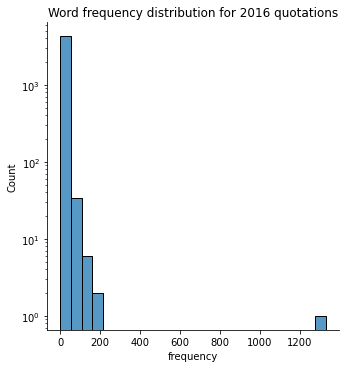

In [50]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2016, groups_2016 = group_quotation_by_unique_column_value(df_quotation_2016, col="year_month")

# Get all the lemma in 2016 quotaions
origin_doc_2016 = [subgroup.split() for subgroup in groups_2016]

# Get frequency statistics
df_stat_2016 = generate_freq_stats_df(origin_doc_2016)

# Display stats
display(df_stat_2016.describe().transpose())

# Plot distribution
sns.displot(df_stat_2016.frequency, bins=25)
plt.title("Word frequency distribution for 2016 quotations")
plt.yscale('log')

Extreme outliers also exist in 2016 quotations, let's see what those words are and whether we need to remove it, in this case we set the threshold for maximum frequency as 200.

In [51]:
display(df_stat_2016[df_stat_2016.frequency > 200])

,word,frequency
3,bitcoin,1329
6,blockchain,204


Again, "Bitcoin" as one of the crypto currencies and and "Blockchain" as its underlying technology, are essential to be preserved. Therefore we set the threshold for maximum frequency as 1, and set minimum word count as 2 so we filter out all words with only one occurrence to make the words more representative.

In [52]:
opt_model_2016, corpus_2016, dict_2016 = train_topic_detection_model(ym_2016, 
                                                                     groups_2016, 
                                                                     min_wc=2, 
                                                                     max_freq=1)

Number of Unigrams in 2016-01: 631
Number of Name Entity Compounds extracted in 2016-01: 25
Number of bigrams and trigram added in 2016-01 respectively: 6

Number of Unigrams in 2016-02: 2151
Number of Name Entity Compounds extracted in 2016-02: 53
Number of bigrams and trigram added in 2016-02 respectively: 22

Number of Unigrams in 2016-03: 120
Number of Name Entity Compounds extracted in 2016-03: 1
Number of bigrams and trigram added in 2016-03 respectively: 1

Number of Unigrams in 2016-04: 1274
Number of Name Entity Compounds extracted in 2016-04: 44
Number of bigrams and trigram added in 2016-04 respectively: 13

Number of Unigrams in 2016-05: 4045
Number of Name Entity Compounds extracted in 2016-05: 101
Number of bigrams and trigram added in 2016-05 respectively: 41

Number of Unigrams in 2016-06: 332
Number of Name Entity Compounds extracted in 2016-06: 7
Number of bigrams and trigram added in 2016-06 respectively: 3

Number of Unigrams in 2016-07: 3343
Number of Name Entity C

In [53]:
opt_model_2016.show_topics(3, 10)

[(0,
  '0.066*"bitcoin" + 0.011*"blockchain" + 0.009*"people" + 0.007*"ethereum" + 0.006*"like" + 0.006*"btc" + 0.005*"money" + 0.005*"transaction" + 0.005*"time" + 0.005*"technology"'),
 (1,
  '0.056*"bitcoin" + 0.008*"blockchain" + 0.008*"technology" + 0.008*"bank" + 0.006*"exchange" + 0.006*"people" + 0.006*"like" + 0.006*"new" + 0.005*"transaction" + 0.005*"btcc"')]

In [54]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model_2016, corpus_2016, dict_2016)
pyLDAvis.display(data)

As indicated by 2016 top words of each topic, most of the top words are identical to last year (2015), which means people are talking about roughly the same topic. However, we did observe some critical information revealed in each topic as follows:

* **Ethereum, as another widely known crypto currencies nowadays, were thrusted into the limelight in 2016.**
* **Bank seems to show their interest in crypto assets.**

Let's work on these two words more specifically.

,count,mean,std,min,25%,50%,75%,max
frequency,1500.0,2.973333,7.217156,1.0,1.0,1.0,3.0,176.0


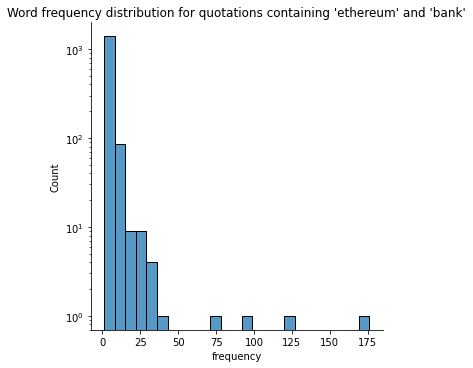

In [55]:
# Collect quotations containing those two top words and split it further into two
keywords_2016 = ["ethereum", "bank"]

df_kw_2016, processed_kw_2016, df_stat_newkw_2016 = generate_freq_stats_selected_quotations(df_quotation_2016, keywords_2016)

# Display stats
display(df_stat_newkw_2016.describe().transpose())

# Plot distribution
sns.displot(df_stat_newkw_2016.frequency, bins=25)
plt.title("Word frequency distribution for quotations containing 'ethereum' and 'bank'")
plt.yscale('log')

In [57]:
df_stat_newkw_2016[df_stat_newkw_2016.frequency > 50].sort_values(by="frequency", ascending=False)

,word,frequency
29,bitcoin,176
1,ethereum,120
893,bank,97
30,blockchain,73


It is a bit supervised that "bitcoin" is still the most frequent word, despite we have select quotations that contains another crypto currencies. This might be because people tends to compare Bitcoin to Ethereum, or banks tend to be more involved in this specific crypto currency as it's more secure, or even both. We will dive further into this by apply topic modelling again.

In [58]:
# Create corpus
corpus_kw_2016, dict_kw_2016 = create_corpus_dict_selected_quotations(keywords_2016, 
                                                                      processed_kw_2016, 
                                                                      min_wordcount=2, 
                                                                      max_freq=1)

# Train LDA Model
optimal_model_kw_2016 = train_topic_detection_model_selected_quotation(corpus_kw_2016, 
                                                                       dict_kw_2016,
                                                                       num_topic=2)

Number of Unigrams in ethereum: 1939
Number of Name Entity Compounds extracted in ethereum: 25
Number of bigrams and trigram added in ethereum respectively: 19

Number of Unigrams in bank: 2384
Number of Name Entity Compounds extracted in bank: 47
Number of bigrams and trigram added in bank respectively: 24

Number of unique tokens: 351
Number of chunks: 2



In [59]:
optimal_model_kw_2016.show_topics(num_words=18)

[(0,
  '0.038*"blockchain" + 0.035*"bitcoin" + 0.023*"community" + 0.014*"contract" + 0.013*"like" + 0.012*"people" + 0.011*"network" + 0.010*"application" + 0.010*"work" + 0.009*"build" + 0.009*"system" + 0.009*"developer" + 0.009*"smart" + 0.009*"project" + 0.008*"time" + 0.008*"support" + 0.008*"thing" + 0.008*"platform"'),
 (1,
  '0.090*"bitcoin" + 0.022*"financial" + 0.019*"blockchain" + 0.016*"company" + 0.016*"money" + 0.015*"world" + 0.015*"technology" + 0.015*"central" + 0.014*"people" + 0.013*"digital" + 0.011*"new" + 0.010*"transaction" + 0.010*"system" + 0.010*"time" + 0.009*"like" + 0.009*"risk" + 0.008*"big" + 0.008*"create"')]

In [60]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(optimal_model_kw_2016, corpus_kw_2016, dict_kw_2016)
pyLDAvis.display(data)

Although "ethereum" and "bank" are nowhere mentioned in the top words in each topic, with domain knowledge we know that topic 0 is about "ethereum" due to the existance of "**smart contract**", whereas topic 1 is about "bank" due to the existance of "**financial institution**". Next, we are going to combine the top words with some sample quotations to summarise those two topics.

In [61]:
# Summarise topic 0
print("Representative quotaions containing 'smart contract' as continuous sequence:\n")

print(df_kw_2016.loc[2838, :].quotation + "\n")

print(df_kw_2016.loc[2907, :].quotation + "\n")

print(df_kw_2016.loc[2938, :].quotation + "\n")

print("Representative quotaions containing 'ethereum community' as continuous sequence:\n")

print(df_kw_2016.loc[2802, :].quotation + "\n")

print("Representative quotaions containing 'bitcoin' and 'ethereum':\n")

print(df_kw_2016.loc[3677, :].quotation + "\n")

Representative quotaions containing 'smart contract' as continuous sequence:

ethereum has three main advantages. these include smart contracts, fast block times, and a vibrant ecosystem,

while ethereum is focused on smart contracts, it's important to note that there are currently numerous companies working on solutions to build smart contracts on bitcoin's blockchain, leveraging the deep security provided by its more established and secure blockchain.

ethereum is the second blockahin to pass a billion dollars of market capitalisation and deploy a secure amount of mining power. like bitcoin it is decentralised, but unlike bitcoin it is not used as a currency as its supply of digital tokens (ether) is not fixed. this is by design as ether is used for creating smart contracts rather than as a currency. in a world where corporation are all interested in blockchains, ethereum has become a decentralised blockchain that they are more comfortable to use, even though bitcoin is a lot more se

In [62]:
# Summarise topic 1
print("Representative quotaions containing 'financial institution' as continuous sequence:\n")

print(df_kw_2016.loc[2674, :].quotation + "\n")

print(df_kw_2016.loc[3109, :].quotation + "\n")

print(df_kw_2016.loc[3343, :].quotation + "\n")

print("Representative quotaions containing 'central bank' as continuous sequence:\n")

print(df_kw_2016.loc[2447, :].quotation + "\n")

print(df_kw_2016.loc[2530, :].quotation + "\n")

Representative quotaions containing 'financial institution' as continuous sequence:

the discussion around distributed ledgers and blockchain is again focusing on the usefulness of the technology for transacting-transferring cash across borders. of course, this was the starting point with bitcoin but for some time seemed to be of less interest to many while other potential uses of blockchain technology were being explored. but it has never gone away as a key focus for financial institutions and central banks.

the leading bitcoin companies globally are already using elliptic products to assess risk on more than $1bn in bitcoin transactions each month. by integrating lexisnexis risk solutions' robust watchlist data, we are making it safe for a new wave of financial institutions to handle bitcoin and bank bitcoin companies.

our new relationship with money partners group is a huge win for bitcoin and ethereum awareness and adoption around the world. the results we will achieve together w

After studying all the representative quotations selected by keyword, we can summarise the two topic as:
* **Topic 0: Smart contract is the advantage of Ethereum against Bitcoin despite they are all using blockchain technology, but Bitcoin is more secure than Ethereum.**
* **Topic 1: Bitcoin companies are look forward for financial institutions to embrace bitcoin, whereas central banks are interested in developing their own digital money.**

### Topic Modelling 2017

Currently working on: 2017-01
Number of quotations: 4

Currently working on: 2017-02
Number of quotations: 88

Currently working on: 2017-03
Number of quotations: 302

Currently working on: 2017-04
Number of quotations: 268

Currently working on: 2017-05
Number of quotations: 388

Currently working on: 2017-06
Number of quotations: 354

Currently working on: 2017-07
Number of quotations: 448

Currently working on: 2017-08
Number of quotations: 547

Currently working on: 2017-09
Number of quotations: 689



,count,mean,std,min,25%,50%,75%,max
frequency,6188.0,7.703297,42.736758,1.0,1.0,2.0,5.0,3004.0


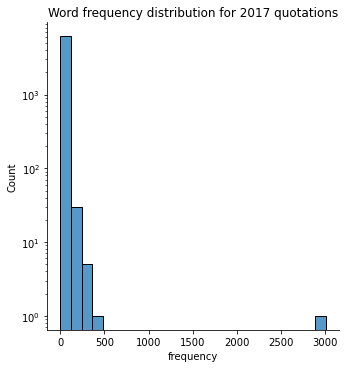

In [63]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2017, groups_2017 = group_quotation_by_unique_column_value(df_quotation_2017, col="year_month")

# Get all the lemma in 2016 quotaions
origin_doc_2017 = [subgroup.split() for subgroup in groups_2017]

# Get frequency statistics
df_stat_2017 = generate_freq_stats_df(origin_doc_2017)

# Display stats
display(df_stat_2017.describe().transpose())

# Plot distribution
sns.displot(df_stat_2017.frequency, bins=25)
plt.title("Word frequency distribution for 2017 quotations")
plt.yscale('log')

In [64]:
display(df_stat_2017[df_stat_2017.frequency > 400])
display(df_stat_2017[df_stat_2017.word.isin(["crypto", "digital"])])

nlp.vocab["digital"].is_stop = True

,word,frequency
52,bitcoin,3004
63,currency,411


,word,frequency
195,digital,177
205,crypto,139


Again, "currency" is one of the two outliers in quotations published in 2017, and as we observed from previous years, "digital currency" is also one of the common continous sequences in the quotaions, in 2017 "digital" occured even more frequently than "crypto". Therefore, we will ingnore "digital" henceforth to make room for other top words. Moreover, we will expand the corpus and the dictionary for the sake of having more name entity, bigram and trigram to spot new top words. Thus, we keep the whole dictionary by setting both threshold to 1.

In [65]:
opt_model_2017, corpus_2017, dict_2017 = train_topic_detection_model(ym_2017, 
                                                                     groups_2017, 
                                                                     min_wc=1, 
                                                                     max_freq=1)

Number of Unigrams in 2017-01: 83
Number of Name Entity Compounds extracted in 2017-01: 3
Number of bigrams and trigram added in 2017-01 respectively: 0

Number of Unigrams in 2017-02: 1575
Number of Name Entity Compounds extracted in 2017-02: 48
Number of bigrams and trigram added in 2017-02 respectively: 16

Number of Unigrams in 2017-03: 4655
Number of Name Entity Compounds extracted in 2017-03: 110
Number of bigrams and trigram added in 2017-03 respectively: 47

Number of Unigrams in 2017-04: 3975
Number of Name Entity Compounds extracted in 2017-04: 114
Number of bigrams and trigram added in 2017-04 respectively: 40

Number of Unigrams in 2017-05: 5278
Number of Name Entity Compounds extracted in 2017-05: 134
Number of bigrams and trigram added in 2017-05 respectively: 54

Number of Unigrams in 2017-06: 5251
Number of Name Entity Compounds extracted in 2017-06: 142
Number of bigrams and trigram added in 2017-06 respectively: 53

Number of Unigrams in 2017-07: 6778
Number of Name E

In [66]:
opt_model_2017.show_topics(num_words=18)

[(0,
  '0.005*"bitcoin" + 0.002*"enterprise" + 0.002*"ethereum" + 0.001*"btcc" + 0.001*"business" + 0.001*"community" + 0.001*"peace" + 0.001*"btc" + 0.001*"money" + 0.001*"great" + 0.001*"like" + 0.001*"base" + 0.001*"work" + 0.001*"technology" + 0.001*"project" + 0.001*"provide" + 0.001*"pay" + 0.001*"high"'),
 (1,
  '0.059*"bitcoin" + 0.007*"people" + 0.006*"ethereum" + 0.006*"like" + 0.006*"blockchain" + 0.005*"market" + 0.004*"transaction" + 0.004*"btc" + 0.004*"money" + 0.004*"exchange" + 0.004*"value" + 0.004*"price" + 0.004*"new" + 0.004*"technology" + 0.004*"work" + 0.003*"time" + 0.003*"world" + 0.003*"payment"')]

At this point, we do observed a few informative new top words. In topic 0, the word "enterprise" is **the second most revelent terms**, but it is not even a top word in previous year. Also, we notice that the relevance of a digital currency exchange market "btcc" also increased significantly, whereas the term "exchange market" has also been mentioned in topic 1.  All the aforementioned observations might be the indication of **gradual prosperity of the crypto markets and community**.

In [67]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model_2017, corpus_2017, dict_2017)
pyLDAvis.display(data)

In [68]:
keywords_2017 = ["enterprise", "btcc", "community"]

df_kw_2017, processed_kw_2017, df_stat_kw_2017 = generate_freq_stats_selected_quotations(df_quotation_2017, keywords_2017)

,count,mean,std,min,25%,50%,75%,max
frequency,1661.0,3.012643,6.182405,1.0,1.0,1.0,3.0,125.0


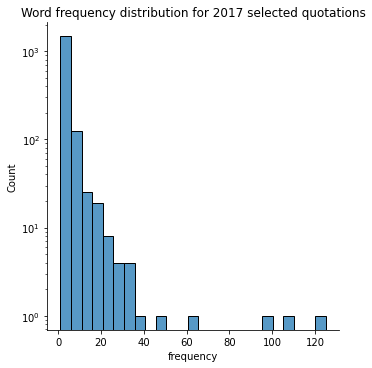

In [69]:
# Display stats
display(df_stat_kw_2017.describe().transpose())

# Plot distribution
sns.displot(df_stat_kw_2017.frequency, bins=25)
plt.title("Word frequency distribution for 2017 selected quotations")
plt.yscale('log')

In [70]:
df_stat_kw_2017[df_stat_kw_2017.frequency > 40]

,word,frequency
0,enterprise,47
27,ethereum,62
145,bitcoin,96
293,community,107
469,btcc,125


As can be seen from the table, it is very supervising that the minimum frequency for any word in the selected quotaions is 3, which means the keywords are mentioned a lot throughout these quotations. In this case, we won't remove any words, just let the LDA model performs the topic modelling.

In [71]:
# Create corpus
corpus_kw_2017, dict_kw_2017 = create_corpus_dict_selected_quotations(keywords_2017, 
                                                                      processed_kw_2017, 
                                                                      min_wordcount=2, 
                                                                      max_freq=1)

# Train LDA Model
opt_model_kw_2017 = train_topic_detection_model_selected_quotation(corpus_kw_2017, 
                                                                   dict_kw_2017)

Number of Unigrams in enterprise: 894
Number of Name Entity Compounds extracted in enterprise: 13
Number of bigrams and trigram added in enterprise respectively: 9

Number of Unigrams in btcc: 1811
Number of Name Entity Compounds extracted in btcc: 52
Number of bigrams and trigram added in btcc respectively: 18

Number of Unigrams in community: 2163
Number of Name Entity Compounds extracted in community: 58
Number of bigrams and trigram added in community respectively: 22

Number of unique tokens: 442
Number of chunks: 3

Perform cross validation to select the optimal number of topics
Optimal number of topics: 2 topics


In [72]:
opt_model_kw_2017.show_topics(num_words=18)

[(0,
  '0.098*"btcc" + 0.027*"race" + 0.025*"team" + 0.023*"good" + 0.022*"car" + 0.016*"win" + 0.015*"start" + 0.013*"time" + 0.013*"great" + 0.012*"come" + 0.010*"lot" + 0.009*"drive" + 0.008*"exciting" + 0.008*"look" + 0.008*"strong" + 0.008*"right" + 0.008*"long" + 0.007*"new"'),
 (1,
  '0.049*"community" + 0.043*"bitcoin" + 0.029*"ethereum" + 0.022*"enterprise" + 0.016*"blockchain" + 0.013*"work" + 0.010*"technology" + 0.009*"btc" + 0.008*"development" + 0.008*"project" + 0.007*"continue" + 0.007*"grow" + 0.007*"new" + 0.006*"alliance" + 0.006*"business" + 0.006*"network" + 0.006*"support" + 0.006*"need"')]

In [73]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model_kw_2017, corpus_kw_2017, dict_kw_2017)
pyLDAvis.display(data)

Thanks to the LDA topic modelling, we figured out that topic 0 is highly associated with "btcc", which is not actually the crypto currency exchange market, but the "British Touring Car Championship" due to the same spelling. Therefore, we have only one topic and we will focus on this topic.

In topic 1, the most relevant term we observed is "community", and if we ingore the two famous crypto currencies, the second most relevant term is "enterprise", which is very close to our initial assumption. Let's explore more on this topic by drawing some representative quotations.

In [74]:
# Summarisation
print("Representative quotaions containing 'enterprise':\n")

print(df_kw_2017.loc[4655, :].quotation + "\n")

print(df_kw_2017.loc[4450, :].quotation + "\n")

print(df_kw_2017.loc[10662, :].quotation + "\n")

print("Representative quotaions containing 'community':\n")

print(df_kw_2017.loc[10875, :].quotation + "\n")

print(df_kw_2017.loc[10839, :].quotation + "\n")

print(df_kw_2017.loc[6210, :].quotation + "\n")

Representative quotaions containing 'enterprise':

toyota research institute supports the enterprise ethereum alliance and its members in promoting common standards and tools to accelerate the adoption of this technology and the potential benefits for toyota's customers,

the enterprise ethereum alliance was established to meet the governance needs of large enterprises, who face regulation, significant reputational risk and stringent it requirements without impinging the pace of innovation and open-source collaboration. governance is critical to accelerate mainstream adoption of blockchain technology, and the work of world economic forum, along with don and alex, is a most welcomed-not to mention comprehensive and thoughtful-review of the key issues in the space today,

we're honored to be able to contribute our pbft implementation to j.p. morgan's industry-leading quorum platform. having financial institutions as our primary customers meant we had to design from day one with their req

Combining the most relevant terms with the above quotations, we can easily summarise the topic as:

**The imvolvement of enterprises contributes to prosperity of Bitcoin and Ethereum community** 

### Topic Modelling Major Event

Currently working on: 2017-10
Number of quotations: 793

Currently working on: 2017-11
Number of quotations: 1095

Currently working on: 2017-12
Number of quotations: 1974

Currently working on: 2018-01
Number of quotations: 1401

Currently working on: 2018-02
Number of quotations: 1097

Currently working on: 2018-03
Number of quotations: 827



,count,mean,std,min,25%,50%,75%,max
frequency,8640.0,12.113657,87.368641,1.0,1.0,2.0,6.0,7198.0


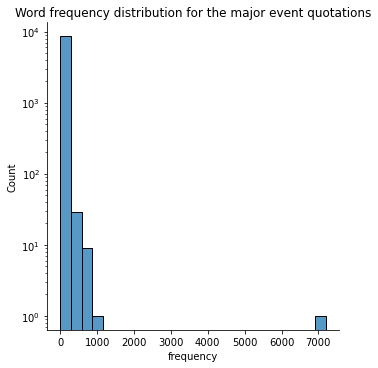

In [75]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_event, groups_event = group_quotation_by_unique_column_value(df_quotation_event, col="year_month")

# Get all the lemma in the major event quotaions
origin_doc_event = [subgroup.split() for subgroup in groups_event]

# Get frequency statistics
df_stat_event = generate_freq_stats_df(origin_doc_event)

# Display stats
display(df_stat_event.describe().transpose())

# Plot distribution
sns.displot(df_stat_event.frequency, bins=25)
plt.title("Word frequency distribution for the major event quotations")
plt.yscale('log')

In [76]:
df_stat_event[df_stat_event.frequency > 700]

,word,frequency
38,bitcoin,7198
55,people,793
99,currency,1130
281,like,773


For the major event, we already know that bitcoin has witnessed a massive price rise, followed by a $10,000 collapse. Therefore, this time we will remove "bitcoin" from our corpus, so that we could focus on people's reaction and comment in this major event in the history of crypto currency.

In [77]:
# more easiler to control what words we delete
remove_words = ["bitcoin", "ethereum", "btc", "people", "like", "cryptocurrency", "cryptocurrencie", "blockchain", "exchange", "technology", "transaction", "market"]

for word in remove_words:
    nlp.vocab[word].is_stop = True

opt_model_event, corpus_event, dict_event = train_topic_detection_model(ym_event, 
                                                                         groups_event, 
                                                                         min_wc=3, 
                                                                         max_freq=1)

Number of Unigrams in 2017-10: 10497
Number of Name Entity Compounds extracted in 2017-10: 289
Number of bigrams and trigram added in 2017-10 respectively: 107

Number of Unigrams in 2017-11: 13179
Number of Name Entity Compounds extracted in 2017-11: 368
Number of bigrams and trigram added in 2017-11 respectively: 135

Number of Unigrams in 2017-12: 22046
Number of Name Entity Compounds extracted in 2017-12: 596
Number of bigrams and trigram added in 2017-12 respectively: 226

Number of Unigrams in 2018-01: 16717
Number of Name Entity Compounds extracted in 2018-01: 490
Number of bigrams and trigram added in 2018-01 respectively: 172

Number of Unigrams in 2018-02: 13070
Number of Name Entity Compounds extracted in 2018-02: 428
Number of bigrams and trigram added in 2018-02 respectively: 134

Number of Unigrams in 2018-03: 10926
Number of Name Entity Compounds extracted in 2018-03: 303
Number of bigrams and trigram added in 2018-03 respectively: 112

Number of unique tokens: 2917
Numb

In [78]:
opt_model_event.show_topics(num_words=18)

[(0,
  '0.008*"asset" + 0.007*"government" + 0.007*"buy" + 0.007*"payment" + 0.007*"value" + 0.006*"money" + 0.006*"time" + 0.006*"new" + 0.005*"good" + 0.005*"bank" + 0.005*"look" + 0.005*"system" + 0.004*"price" + 0.004*"thing" + 0.004*"know" + 0.004*"litecoin" + 0.004*"work" + 0.004*"sell"'),
 (1,
  '0.001*"price" + 0.001*"value" + 0.001*"money" + 0.001*"world" + 0.001*"buy" + 0.001*"time" + 0.001*"want" + 0.001*"look" + 0.001*"asset" + 0.001*"new" + 0.001*"good" + 0.001*"know" + 0.001*"government" + 0.001*"believe" + 0.001*"payment" + 0.001*"bubble" + 0.001*"company" + 0.001*"thing"'),
 (2,
  '0.002*"time" + 0.002*"price" + 0.002*"value" + 0.002*"asset" + 0.002*"new" + 0.002*"future" + 0.002*"money" + 0.002*"world" + 0.002*"look" + 0.002*"know" + 0.002*"payment" + 0.002*"government" + 0.002*"buy" + 0.002*"good" + 0.002*"thing" + 0.002*"high" + 0.001*"long" + 0.001*"want"'),
 (3,
  '0.004*"value" + 0.003*"money" + 0.003*"buy" + 0.003*"time" + 0.003*"gold" + 0.002*"new" + 0.002*"pric

In [79]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(opt_model_event, corpus_event, dict_event)
pyLDAvis.display(data)

From the new terms appeared in the above topics detected, we could learn that:
* During this 6 months, what people are most concerned about is the **price** of bitcoin.
* Predictably, as indicated by topic 5, investors are concerned about the **potential risk** of investing crypto currencies and the future of crypto currencies after bitcoin crashed: Is crypto currencies a **bubble**? 

Follow this logic, let's explore what are the potential risk of investing bitcoin, and why people would think Bitcoin is a bubble?

In [80]:
keyword_event_bubble = ["bubble", "risk"]

df_kw_event, processed_kw_event, df_stat_kw_event = generate_freq_stats_selected_quotations(df_quotation_event, keyword_event_bubble)

display(df_stat_kw_event.describe().transpose())

# Create corpus
corpus_kw_event, dict_kw_event = create_corpus_dict_selected_quotations(keyword_event_bubble, 
                                                                        processed_kw_event, 
                                                                        min_wordcount=2, 
                                                                        max_freq=1)

# Train LDA Model
opt_model_kw_event = train_topic_detection_model_selected_quotation(corpus_kw_event, 
                                                                    dict_kw_event,
                                                                    num_topic=2)

,count,mean,std,min,25%,50%,75%,max
frequency,2158.0,4.551437,16.642353,1.0,1.0,2.0,4.0,555.0


Number of Unigrams in bubble: 3421
Number of Name Entity Compounds extracted in bubble: 72
Number of bigrams and trigram added in bubble respectively: 34

Number of Unigrams in risk: 4897
Number of Name Entity Compounds extracted in risk: 84
Number of bigrams and trigram added in risk respectively: 49

Number of unique tokens: 631
Number of chunks: 2



In [81]:
opt_model_kw_event.show_topics(num_words=11)

[(0,
  '0.066*"risk" + 0.017*"asset" + 0.016*"price" + 0.013*"investment" + 0.012*"investor" + 0.011*"financial" + 0.011*"future" + 0.009*"risky" + 0.009*"volatility" + 0.009*"potential" + 0.009*"invest"'),
 (1,
  '0.101*"bubble" + 0.025*"price" + 0.021*"value" + 0.013*"burst" + 0.010*"money" + 0.010*"speculative" + 0.008*"time" + 0.008*"investor" + 0.007*"lot" + 0.007*"increase" + 0.007*"big"')]

In [82]:
data =  pyLDAvis.gensim_models.prepare(opt_model_kw_event, corpus_kw_event, dict_kw_event)
pyLDAvis.display(data)

In [83]:
print(df_kw_event.loc[4801, :].quotation + "\n")

print(df_kw_event.loc[13413, :].quotation + "\n")

print(df_kw_event.loc[5169, :].quotation + "\n")

print(df_kw_event.loc[11856, :].quotation + "\n")

yellen called the cryptocurrency, which has surged about 17 times in value this year, a `highly speculative asset' and `not a stable store of value.' ... yellen was equally unconcerned over how a crash in the price of bitcoin might affect wider markets or institutions, largely because big banks didn't appear to be exposed significantly to its value. trading of bitcoins took to the mainstream this week as futures began trading on a regulated exchange -- the cboe global markets inc. -- and its cme group inc. rival plans to follow suit. `undoubtedly there are individuals who could lose a lot of money if bitcoin were to fall in price, but i really don't see that as creating a full blow financial stability risk,' she said.' i really don't see any significant exposure of our core financial institutions to threats from bitcoin if its value were to fluctuate.' that didn't prevent her from throwing cold water on bitcoin as an investment, saying it `doesn't constitute legal tender. '

the increa

As can be studied directly from the topics and the quotations drawn, **price volatility** is one of the potential risks for investing in Bitcoin or other virtual currencies, as Bitcoin neither has any intrinsic value nor being backed by any kind of assets, which is why some people consider Bitcoin as a "**bubble**" or "Ponzi scheme". As a result, investors were making **speculative investments** in Bitcoin without fully understand its value and potential risks, which triggered the "**bubble burst**".

###  Topic Modelling 2018

Currently working on: 2018-04
Number of quotations: 811

Currently working on: 2018-05
Number of quotations: 697

Currently working on: 2018-06
Number of quotations: 590

Currently working on: 2018-07
Number of quotations: 518

Currently working on: 2018-08
Number of quotations: 456

Currently working on: 2018-09
Number of quotations: 447

Currently working on: 2018-10
Number of quotations: 1027

Currently working on: 2018-11
Number of quotations: 684

Currently working on: 2018-12
Number of quotations: 398



,count,mean,std,min,25%,50%,75%,max
frequency,8724.0,10.728794,65.926049,1.0,1.0,2.0,6.0,5289.0


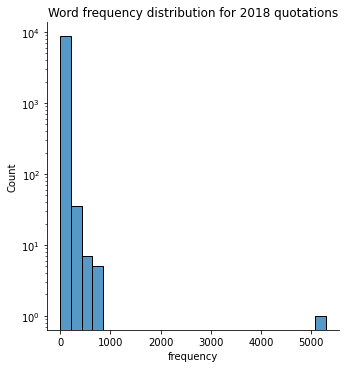

In [84]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2018, groups_2018 = group_quotation_by_unique_column_value(df_quotation_2018, col="year_month")

# Get all the lemma in 2016 quotaions
origin_doc_2018 = [subgroup.split() for subgroup in groups_2018]

# Get frequency statistics
df_stat_2018 = generate_freq_stats_df(origin_doc_2018)

# Display stats
display(df_stat_2018.describe().transpose())

# Plot distribution
sns.displot(df_stat_2018.frequency, bins=25)
plt.title("Word frequency distribution for 2018 quotations")
plt.yscale('log')

In [85]:
opt_model_2018, corpus_2018, dict_2018 = train_topic_detection_model(ym_2018, 
                                                                     groups_2018, 
                                                                     min_wc=3, 
                                                                     max_freq=1)

Number of Unigrams in 2018-04: 10635
Number of Name Entity Compounds extracted in 2018-04: 293
Number of bigrams and trigram added in 2018-04 respectively: 109

Number of Unigrams in 2018-05: 8669
Number of Name Entity Compounds extracted in 2018-05: 284
Number of bigrams and trigram added in 2018-05 respectively: 89

Number of Unigrams in 2018-06: 8161
Number of Name Entity Compounds extracted in 2018-06: 259
Number of bigrams and trigram added in 2018-06 respectively: 84

Number of Unigrams in 2018-07: 7526
Number of Name Entity Compounds extracted in 2018-07: 230
Number of bigrams and trigram added in 2018-07 respectively: 77

Number of Unigrams in 2018-08: 7157
Number of Name Entity Compounds extracted in 2018-08: 224
Number of bigrams and trigram added in 2018-08 respectively: 73

Number of Unigrams in 2018-09: 5924
Number of Name Entity Compounds extracted in 2018-09: 168
Number of bigrams and trigram added in 2018-09 respectively: 60

Number of Unigrams in 2018-10: 15478
Number 

In [86]:
opt_model_2018.show_topics(num_words=18)

[(0,
  '0.001*"asset" + 0.001*"want" + 0.001*"money" + 0.001*"value" + 0.001*"time" + 0.001*"new" + 0.001*"xrp" + 0.001*"come" + 0.001*"security" + 0.001*"price" + 0.001*"buy" + 0.001*"payment" + 0.001*"coin" + 0.001*"long" + 0.001*"work" + 0.001*"network" + 0.001*"look" + 0.001*"world"'),
 (1,
  '0.007*"asset" + 0.007*"buy" + 0.007*"price" + 0.007*"money" + 0.006*"time" + 0.006*"value" + 0.006*"cash" + 0.006*"new" + 0.005*"investor" + 0.005*"want" + 0.005*"litecoin" + 0.005*"pay" + 0.004*"work" + 0.004*"big" + 0.004*"look" + 0.004*"world" + 0.004*"payment" + 0.004*"xrp"'),
 (2,
  '0.006*"asset" + 0.006*"time" + 0.006*"price" + 0.005*"money" + 0.005*"new" + 0.005*"want" + 0.005*"world" + 0.005*"work" + 0.005*"value" + 0.005*"come" + 0.004*"good" + 0.004*"look" + 0.004*"payment" + 0.004*"support" + 0.004*"user" + 0.004*"thing" + 0.004*"network" + 0.004*"need"'),
 (3,
  '0.008*"price" + 0.007*"asset" + 0.007*"investor" + 0.006*"world" + 0.006*"time" + 0.006*"good" + 0.006*"thing" + 0.005

In [87]:
data =  pyLDAvis.gensim_models.prepare(opt_model_2018, corpus_2018, dict_2018)
pyLDAvis.display(data)

As usual, the top words in 2018 quotations have not changed due to the matured market and the well-established community of Bitcoin/Ethereum. Except for topic 0, where the new cryptocurrency "xrp" was mentioned, as well as people's concern for "security". Therefore, we are quite interested in exploring how can "xrp" stand out from the crowd, and what are the "security" issues.

,count,mean,std,min,25%,50%,75%,max
frequency,1913.0,3.695243,10.413906,1.0,1.0,1.0,3.0,278.0


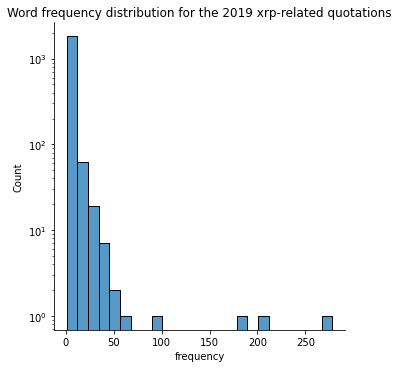

In [88]:
keyword_2018 = ["security", "xrp"]

df_kw_2018, processed_kw_2018, df_stat_kw_2018 = generate_freq_stats_selected_quotations(df_quotation_2018, keyword_2018)

# Display stats
display(df_stat_kw_2018.describe().transpose())

# Plot distribution
sns.displot(df_stat_kw_2018.frequency, bins=25)
plt.title("Word frequency distribution for the 2019 xrp-related quotations")
plt.yscale('log')

In [92]:
nlp.vocab['seconds'].is_stop = True
nlp.vocab['second'].is_stop = False

# Create corpus
corpus_kw_2018, dict_kw_2018 = create_corpus_dict_selected_quotations(keyword_2018, 
                                                                      processed_kw_2018, 
                                                                      min_wordcount=1, 
                                                                      max_freq=1)

# Train LDA Model
opt_model_kw_2018 = train_topic_detection_model_selected_quotation(corpus_kw_2018, 
                                                                   dict_kw_2018,
                                                                   num_topic=2)

Number of Unigrams in security: 3726
Number of Name Entity Compounds extracted in security: 74
Number of bigrams and trigram added in security respectively: 38

Number of Unigrams in xrp: 2497
Number of Name Entity Compounds extracted in xrp: 155
Number of bigrams and trigram added in xrp respectively: 26

Number of unique tokens: 2118
Number of chunks: 2



In [93]:
opt_model_kw_2018.show_topics(num_words=18)

[(0,
  '0.035*"security" + 0.009*"xrp" + 0.006*"new" + 0.006*"asset" + 0.005*"user" + 0.005*"sec" + 0.004*"token" + 0.004*"address" + 0.004*"ripple" + 0.004*"privacy" + 0.004*"offer" + 0.004*"time" + 0.004*"system" + 0.004*"work" + 0.003*"continue" + 0.003*"provide" + 0.003*"company" + 0.003*"trade"'),
 (1,
  '0.062*"xrp" + 0.020*"ripple" + 0.008*"security" + 0.008*"company" + 0.007*"asset" + 0.006*"payment" + 0.006*"ledger" + 0.005*"buy" + 0.005*"price" + 0.005*"xrp ledger" + 0.004*"lot" + 0.004*"platform" + 0.004*"decentralize" + 0.004*"list" + 0.004*"world" + 0.004*"clear" + 0.003*"good" + 0.003*"control"')]

The above topics share a lot of common words, even the order of those common words is quite similar, so we can generally treat these three topics as one topic. However, it is noteworthy the presence of "sec" in topic 0, which is the abbreviation for "second(s)", while "second(s)" is treated as stop word and removed from dictionary. In this case, we will investigate how 'xrp' is associated with 'second(s)'. Furthermore, we noticed "ripple" as the top word we never encountered, so it is worth exploring as well.

In [94]:
print("Representative quotaions containing 'xrp' and 'second(s)':\n")

print(df_kw_2018.loc[14968, :].quotation + "\n")

print(df_kw_2018.loc[15355, :].quotation + "\n")

print("Representative quotaions containing 'xrp', 'ripple' and 'security':\n")

print(df_kw_2018.loc[12061, :].quotation + "\n")

print(df_kw_2018.loc[20475, :].quotation + "\n")


Representative quotaions containing 'xrp' and 'second(s)':

xrp's utility lies in its speed and scalability, which makes it the perfect fit for cross-border payments. the xrp ledger can send 1,500 transactions per second.

originally people thought it might solve a payments problem but when you have an asset like xrp that's a thousand times faster and a thousand times cheaper on a per transaction basis bitcoin can't really compete on that level, you know an xrp transaction costs fractions of a penny and it settles in three seconds.

Representative quotaions containing 'xrp', 'ripple' and 'security':

xrp is not a security for three reasons: if ripple, the company, shuts down tomorrow, the xrp ledger will continue to operate; it's an open-source, decentralized technology;.... if you buy xrp, [ you are ] not buying shares of ripple -- buying xrp doesn't give you ownership of ripple.

i think it's really clear that xrp is not a security. xrp exists independent of ripple and it would opera

Based on the top words and the representative quotation, we could find answers for the proposed questions:
1. **Q1**: Why could "xrp" stand out from the crowd?
   **A1**: xrp has faster transaction time and cheaper transaction fee that bitcoin can't really compete

2. **Q2**: What is the "security" issue?
   **A2**: "security" here actually refers to a share of ownership in a company—giving the shareholder a stake in the business and an interest in its profits. **Most "xrp" related quotations are actually promoting knowledge about "xrp"**. That is, "xrp" is a crypto currency issued by "Ripple" Co., people holding "xrp" does not mean that people holding a stake of "Ripple" Co.


### Topic Modelling 2019

Currently working on: 2019-01
Number of quotations: 352

Currently working on: 2019-02
Number of quotations: 396

Currently working on: 2019-03
Number of quotations: 310

Currently working on: 2019-04
Number of quotations: 283

Currently working on: 2019-05
Number of quotations: 446

Currently working on: 2019-06
Number of quotations: 418

Currently working on: 2019-07
Number of quotations: 430

Currently working on: 2019-08
Number of quotations: 411

Currently working on: 2019-09
Number of quotations: 337

Currently working on: 2019-10
Number of quotations: 328

Currently working on: 2019-11
Number of quotations: 403

Currently working on: 2019-12
Number of quotations: 264



,count,mean,std,min,25%,50%,75%,max
frequency,7418.0,9.406983,51.266269,1.0,1.0,2.0,6.0,3752.0


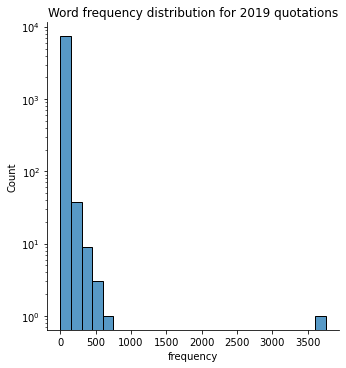

In [95]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2019, groups_2019 = group_quotation_by_unique_column_value(df_quotation_2019, col="year_month")

# Get all the lemma in 2016 quotaions
origin_doc_2019 = [subgroup.split() for subgroup in groups_2019]

# Get frequency statistics
df_stat_2019 = generate_freq_stats_df(origin_doc_2019)

# Display stats
display(df_stat_2019.describe().transpose())

# Plot distribution
sns.displot(df_stat_2019.frequency, bins=25)
plt.title("Word frequency distribution for 2019 quotations")
plt.yscale('log')

In [96]:
opt_model_2019, corpus_2019, dict_2019 = train_topic_detection_model(ym_2019, 
                                                                     groups_2019, 
                                                                     min_wc=3, 
                                                                     max_freq=1)

Number of Unigrams in 2019-01: 4681
Number of Name Entity Compounds extracted in 2019-01: 131
Number of bigrams and trigram added in 2019-01 respectively: 48

Number of Unigrams in 2019-02: 5201
Number of Name Entity Compounds extracted in 2019-02: 158
Number of bigrams and trigram added in 2019-02 respectively: 53

Number of Unigrams in 2019-03: 4712
Number of Name Entity Compounds extracted in 2019-03: 133
Number of bigrams and trigram added in 2019-03 respectively: 48

Number of Unigrams in 2019-04: 3836
Number of Name Entity Compounds extracted in 2019-04: 104
Number of bigrams and trigram added in 2019-04 respectively: 39

Number of Unigrams in 2019-05: 6471
Number of Name Entity Compounds extracted in 2019-05: 205
Number of bigrams and trigram added in 2019-05 respectively: 66

Number of Unigrams in 2019-06: 5331
Number of Name Entity Compounds extracted in 2019-06: 163
Number of bigrams and trigram added in 2019-06 respectively: 54

Number of Unigrams in 2019-07: 5711
Number of 

/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Optimal number of topics: 9 topics


In [97]:
opt_model_2019.show_topics(num_words=18)

[(0,
  '0.002*"asset" + 0.002*"price" + 0.001*"time" + 0.001*"want" + 0.001*"world" + 0.001*"work" + 0.001*"know" + 0.001*"value" + 0.001*"money" + 0.001*"new" + 0.001*"thing" + 0.001*"cash" + 0.001*"high" + 0.001*"need" + 0.001*"trade" + 0.001*"long" + 0.001*"believe" + 0.001*"lot"'),
 (1,
  '0.010*"money" + 0.009*"asset" + 0.008*"value" + 0.007*"time" + 0.007*"gold" + 0.006*"cash" + 0.006*"world" + 0.005*"dollar" + 0.005*"come" + 0.005*"financial" + 0.005*"system" + 0.005*"good" + 0.005*"new" + 0.005*"payment" + 0.005*"activity" + 0.004*"government" + 0.004*"bank" + 0.004*"long"'),
 (2,
  '0.002*"asset" + 0.001*"value" + 0.001*"money" + 0.001*"price" + 0.001*"come" + 0.001*"good" + 0.001*"time" + 0.001*"buy" + 0.001*"world" + 0.001*"want" + 0.001*"high" + 0.001*"new" + 0.001*"xrp" + 0.001*"cash" + 0.001*"look" + 0.001*"work" + 0.001*"thing" + 0.001*"btcc"'),
 (3,
  '0.002*"asset" + 0.001*"value" + 0.001*"time" + 0.001*"xrp" + 0.001*"money" + 0.001*"price" + 0.001*"gold" + 0.001*"know

In [98]:
data =  pyLDAvis.gensim_models.prepare(opt_model_2019, corpus_2019, dict_2019)
pyLDAvis.display(data)

In 2019, we haven't found any new topics from the quotations, but there seems to be an enduring interest in "bitcoin" and "ethereum", which makes us curious about the content of Bitcoin/Ethereumn related quotes.

,count,mean,std,min,25%,50%,75%,max
frequency,5835.0,8.959726,55.64159,1.0,1.0,2.0,6.0,3865.0


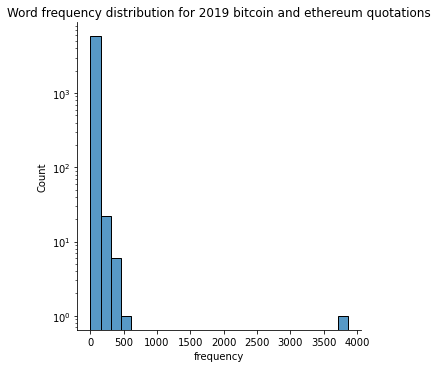

In [99]:
keyword_2019 = ["bitcoin", "ethereum"]

df_kw_2019, processed_kw_2019, df_stat_kw_2019 = generate_freq_stats_selected_quotations(df_quotation_2019, keyword_2019)

# Display stats
display(df_stat_kw_2019.describe().transpose())

# Plot distribution
sns.displot(df_stat_kw_2019.frequency, bins=25)
plt.title("Word frequency distribution for 2019 bitcoin and ethereum quotations")
plt.yscale('log')

In [100]:
nlp.vocab["bitcoin"].is_stop = True
nlp.vocab["btc"].is_stop = True
nlp.vocab["ethereum"].is_stop = True

# Create corpus
corpus_kw_2019, dict_kw_2019 = create_corpus_dict_selected_quotations(keyword_2019, 
                                                                      processed_kw_2019, 
                                                                      min_wordcount=2, 
                                                                      max_freq=1)

# Train LDA Model
opt_model_kw_2019 = train_topic_detection_model_selected_quotation(corpus_kw_2019, 
                                                                   dict_kw_2019)

opt_model_kw_2019.show_topics(num_words=18)

nlp.vocab["bitcoin"].is_stop = False
nlp.vocab["btc"].is_stop = False
nlp.vocab["ethereum"].is_stop = False

Number of Unigrams in bitcoin: 37954
Number of Name Entity Compounds extracted in bitcoin: 1126
Number of bigrams and trigram added in bitcoin respectively: 390

Number of Unigrams in ethereum: 5272
Number of Name Entity Compounds extracted in ethereum: 105
Number of bigrams and trigram added in ethereum respectively: 53

Number of unique tokens: 1544
Number of chunks: 2

Perform cross validation to select the optimal number of topics


/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Optimal number of topics: 3 topics


In [101]:
data =  pyLDAvis.gensim_models.prepare(opt_model_kw_2019, corpus_kw_2019, dict_kw_2019)
pyLDAvis.display(data)

Based on the detected topics and the visualisation, we can tell that topic 0 is about "bitcoin" and topic 1 is about "ethereum". One fun fact we observed is that when it comes to Bitcoin, people tend to focus more on the **market aspects**, such as the price and value of Bitcoin, while for Ether, people are more interested in the **technical level**, e.g. the blockchain and smart contract technology.

### Topic modelling 2020

Currently working on: 2020-01
Number of quotations: 329

Currently working on: 2020-02
Number of quotations: 352

Currently working on: 2020-03
Number of quotations: 243

Currently working on: 2020-04
Number of quotations: 102



,count,mean,std,min,25%,50%,75%,max
frequency,3564.0,4.287598,16.224293,1.0,1.0,2.0,4.0,830.0


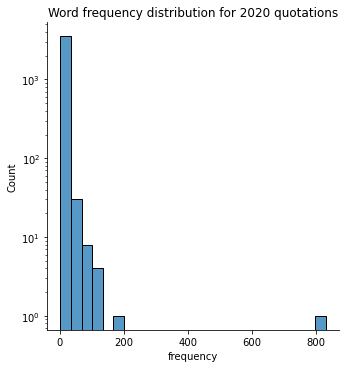

In [102]:
# Group quotaions in each month 
# Output sorted group order and group itself
ym_2020, groups_2020 = group_quotation_by_unique_column_value(df_quotation_2020, col="year_month")

# Get all the lemma in 2016 quotaions
origin_doc_2020 = [subgroup.split() for subgroup in groups_2020]

# Get frequency statistics
df_stat_2020 = generate_freq_stats_df(origin_doc_2020)

# Display stats
display(df_stat_2020.describe().transpose())

# Plot distribution
sns.displot(df_stat_2020.frequency, bins=25)
plt.title("Word frequency distribution for 2020 quotations")
plt.yscale('log')

In [103]:
opt_model_2020, corpus_2020, dict_2020 = train_topic_detection_model(ym_2020, 
                                                                     groups_2020, 
                                                                     min_wc=2, 
                                                                     max_freq=1)

Number of Unigrams in 2020-01: 4533
Number of Name Entity Compounds extracted in 2020-01: 138
Number of bigrams and trigram added in 2020-01 respectively: 46

Number of Unigrams in 2020-02: 4557
Number of Name Entity Compounds extracted in 2020-02: 136
Number of bigrams and trigram added in 2020-02 respectively: 46

Number of Unigrams in 2020-03: 3588
Number of Name Entity Compounds extracted in 2020-03: 111
Number of bigrams and trigram added in 2020-03 respectively: 36

Number of Unigrams in 2020-04: 1513
Number of Name Entity Compounds extracted in 2020-04: 34
Number of bigrams and trigram added in 2020-04 respectively: 15

Number of unique tokens: 1390
Number of chunks: 4

Perform cross validation to select the optimal number of topics


/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


Optimal number of topics: 8 topics


In [104]:
opt_model_2020.show_topics(num_words=5)

[(0,
  '0.008*"bitcoin" + 0.002*"btc" + 0.002*"gold" + 0.002*"price" + 0.002*"time"'),
 (1,
  '0.070*"bitcoin" + 0.016*"btc" + 0.009*"asset" + 0.009*"price" + 0.007*"ethereum"'),
 (2,
  '0.002*"bitcoin" + 0.001*"btc" + 0.001*"asset" + 0.001*"new" + 0.001*"gold"'),
 (3,
  '0.004*"bitcoin" + 0.001*"btc" + 0.001*"price" + 0.001*"asset" + 0.001*"new"'),
 (4,
  '0.002*"bitcoin" + 0.001*"btc" + 0.001*"price" + 0.001*"new" + 0.001*"gold"'),
 (5,
  '0.002*"bitcoin" + 0.001*"btc" + 0.001*"price" + 0.001*"time" + 0.001*"xrp"'),
 (6,
  '0.001*"bitcoin" + 0.001*"btc" + 0.001*"new" + 0.001*"asset" + 0.001*"price"'),
 (7,
  '0.063*"bitcoin" + 0.012*"new" + 0.011*"gold" + 0.010*"price" + 0.010*"money"')]

In [105]:
data =  pyLDAvis.gensim_models.prepare(opt_model_2020, corpus_2020, dict_2020)
pyLDAvis.display(data)

,count,mean,std,min,25%,50%,75%,max
frequency,1318.0,3.197269,9.735013,1.0,1.0,1.0,3.0,250.0


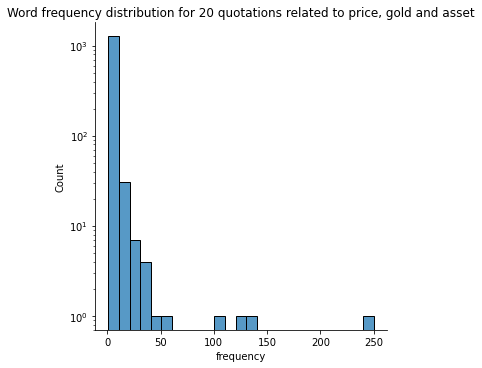

In [106]:
keyword_2020 = ["gold", "price", "asset"]

df_kw_2020, processed_kw_2020, df_stat_kw_2020 = generate_freq_stats_selected_quotations(df_quotation_2020, keyword_2020)

# Display stats
display(df_stat_kw_2020.describe().transpose())

# Plot distribution
sns.displot(df_stat_kw_2020.frequency, bins=25)
plt.title("Word frequency distribution for 20 quotations related to price, gold and asset")
plt.yscale('log')

In [107]:
df_stat_kw_2020[df_stat_kw_2020.frequency > 40]

,word,frequency
0,gold,110
19,bitcoin,250
38,price,128
54,asset,133
58,market,43
301,crypto,55


In [108]:
for word in keyword_2020:
    nlp.vocab[word].is_stop = True
    
# Create corpus
corpus_kw_2020, dict_kw_2020 = create_corpus_dict_selected_quotations(keyword_2020, 
                                                                      processed_kw_2020, 
                                                                      min_wordcount=2, 
                                                                      max_freq=1)

# Train LDA Model
opt_model_kw_2020 = train_topic_detection_model_selected_quotation(corpus_kw_2020, 
                                                                   dict_kw_2020,
                                                                   num_topic=2)

opt_model_kw_2020.show_topics(num_words=10)

for word in keyword_2020:
    nlp.vocab[word].is_stop = False

Number of Unigrams in gold: 745
Number of Name Entity Compounds extracted in gold: 14
Number of bigrams and trigram added in gold respectively: 7

Number of Unigrams in price: 1265
Number of Name Entity Compounds extracted in price: 34
Number of bigrams and trigram added in price respectively: 12

Number of Unigrams in asset: 1504
Number of Name Entity Compounds extracted in asset: 37
Number of bigrams and trigram added in asset respectively: 15

Number of unique tokens: 435
Number of chunks: 3



In [109]:
print("Representative quotaions for topic 0:\n")

print(df_kw_2020.loc[25851, :].quotation + "\n")
print(df_kw_2020.loc[25316, :].quotation + "\n")
print(df_kw_2020.loc[25608, :].quotation + "\n")
print(df_kw_2020.loc[25505, :].quotation + "\n")

print("Representative quotaions for topic 1:\n")

print(df_kw_2020.loc[25366, :].quotation + "\n")
print(df_kw_2020.loc[25405, :].quotation + "\n")

Representative quotaions for topic 0:

whenever there's actual safe-haven demand, bitcoin pumpers manipulate the price higher to attract buyers, driving the false narrative that #bitcoin is a safe haven too. buyers speculate that others will buy bitcoin as a safe haven, but none do. there's nothing safe about bitcoin.

a similar result is obtained for gold, confirming its well-recognized status as a safe haven when a crisis occurs. finally, we find a low extreme correlation between bitcoin and gold, which implies that both assets can be used together in times of turbulence in financial markets to protect equity positions.

however, unlike traditional safe-havens (treasury notes, us dollar, swiss franc, japanese yen, gold), the bitcoin market is a speculative one with high volatility, which might explain why they are failing to act as a safe-haven asset.

even though bitcoin is compared to gold as a safe haven asset, it's very under-penetrated and is considered more as a risky asset to 

2020 is a special year because of the coronavirus pandemic and geopolitical uncertainties, which is also reflected in this year's quotations:
* Topic 0 is about **safety-oriented asset allocation** when facing the crisis, where people are seeking safe-havens (e.g. gold) for their assets, while bitcoin is considered a risk asset.
* Topic 1 is about the unexpected **rise** and continued **high** bitcoin price sparked the discussion to the potentials of bitcoin as a safe-haven assets.

## Topic modelling on specific speaker attributes 

To save time and space, we preprocessed the original quotation dataset to select out those speakers with quotation >= 3 and tried to verify the identity of speaker with multiple QIDs. Then we find out their corresponding quotations and merge their occupations to the quotation dataset. Finally we select certain occupations to carry out the analysis, after dropping duplicated rows.

In [110]:
df_speaker_attr = pd.read_csv("./data/partical_corrected_speaker_data.csv", encoding="'utf-8")

df_speaker_attr

,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,id,label,quotation
0,1940,['United Kingdom'],['male'],['African Americans'],['theologian'],['doctorate'],Q6224777,john calamos,3
1,1940,['Canada'],['male'],['American Jews'],['association football player'],"['Bachelor of Science', 'Master of Science']",Q6832744,michael mclaughlin,4
2,1940,['United States of America'],['male'],['Britons'],['politician'],['doctorate'],Q11645166,yukio noguchi,3
3,1940,['United States of America'],['male'],['African Americans'],"['climatologist', 'atmospheric scientist']",['Juris Doctor'],Q132596,tarō asō,4
4,1940,['United States of America'],['male'],['Jewish people'],"['psychotherapist', 'journalist', 'spiritualis...",['Doctor of Philosophy'],Q6233100,john fife,4
...,...,...,...,...,...,...,...,...,...
1326,None,NaN,['male'],NaN,"['Ship-owner', 'ship captain']",NaN,Q56541233,nicholas pearce,6
1327,None,['United States of America'],['male'],NaN,['researcher'],[nan],Q57161073,joseph moore,6
1328,None,NaN,['male'],NaN,['composer'],NaN,Q56650695,david r. williams,4
1329,None,['Singapore'],['male'],NaN,['businessperson'],['Bachelor of Mathematics'],Q45362401,su zhu,8


In [111]:
def occupation_extract(quotation, reference, sentiment=False):
    """
    Extract occupation info to quotation dataset of selected speakers
    """
    
    if sentiment == True:
        # Drop irrelevant columns for sentiment analysis
        quotation_info = quotation.drop(columns=['tokenised_quotation', 'num_token', 'num_punct_sym', 'ratio_punct_sym', 'lang',
                                                 'num_nonstop_word'])
    
    else:
        # Drop auxiliary columns for previous tasks for topic modelling
        quotation_info = quotation.drop(columns=['num_token', 'num_punct_sym', 'ratio_punct_sym', 'num_nonstop_word', 'lang'])
        
    # Convert string representation of list to actual list
    quotation_info.qids = quotation_info.qids.apply(lambda row: literal_eval(row))

    # Have each qid as one instance
    speaker_quotation = quotation_info.explode(column=['qids'])

    # Select speaker quotations according to the qid in the df_speaker attribute dataframe
    speaker_quotation = speaker_quotation[speaker_quotation.qids.isin(reference.id)]
    
    # Create dict to map qids to corresponding values in any other column
    mapping_dict = reference.set_index('id').to_dict()

    # Create a column to store the occupation of speakers
    speaker_quotation["occupation"] = speaker_quotation["qids"].map(mapping_dict["occupation"])

    # Drop rows where occupation is nan
    speaker_quotation = speaker_quotation[~speaker_quotation.occupation.isna()]

    # Drop rows where occupation is [nan]
    speaker_quotation = speaker_quotation[~(speaker_quotation.occupation.astype(str) == "[nan]")]

    # Convert string representation of list to actual list
    speaker_quotation["occupation"] = speaker_quotation["occupation"].apply(lambda row: literal_eval(row))
    
    return speaker_quotation


def occupation_type(df, occupation_name):
    """
    extract speakers with specified occupation
    """
    # Explode the dataframe by occupation
    df_occupation_exp = df.explode(column=["occupation"])
    
    # Drop duplicated quotations with same occupation
    output = df_occupation_exp[df_occupation_exp.occupation == occupation_name].drop_duplicates(subset=['quotation'], keep='first')
    
    return output


def chop_quotation(df):

    chunks = list()
    chunks_of_sents = [x for x in get_chunks(df.nonstop_word.to_list(),size)]

    # Group each chunk as a sentence
    for chs in chunks_of_sents:
        grouped_chunk = list()

        for sens in chs:
            grouped_chunk.extend(sens)

        chunks.append(" ".join(grouped_chunk))
    
    return chunks


def process_chunk(chunk):
    
    processed_chunk = list()

    for idx, doc in enumerate(nlp.pipe(chunk, n_process=5, batch_size=10)):
        # Named entities
        ents = doc.ents 

        # Lemmatise tokens
        # We check once again whether the token is stop word in case we update stopword list later
        doc = [token.lemma_ for token in doc if not token.is_stop]

        # Add named entities, but only if they are a compound of more than one word.
        name_entity = [str(entity) for entity in ents if len(entity) > 1]
        doc.extend(name_entity)

        # Select nbest bigrams and trigrams
        # We have to set a dynamic number due to size of df varies
        n_best = int(len(doc) / 100)

        # Add bigrams
        finder_bi = BigramCollocationFinder.from_words(doc, window_size = 3)
        bigram = list(finder_bi.nbest(BIGRAM_MEASURES.raw_freq, n_best))
        doc.extend([" ".join(x) for x in bigram])

        # Add trigrams
        finder_tri = TrigramCollocationFinder.from_words(doc, window_size = 4)
        trigram = list(finder_tri.nbest(TRIGRAM_MEASURES.raw_freq, n_best))
        doc.extend([" ".join(x) for x in trigram])

        processed_chunk.append(doc)
        
    return processed_chunk


def run_occupation_topic_modelling(df, min_wc, max_freq, num_topics="cv"):

    # Chop df into chunks
    chunks = chop_quotation(df)
    
    # Process chunks
    processed_chunks = process_chunk(chunks)

    # Create dictionary and corpus
    corpus_, dict_ = create_dict_corpus(processed_chunks, min_wc, max_freq)

    # Train model
    opt_model_ = train_topic_detection_model_selected_quotation(corpus_, dict_, num_topics)
    
    return opt_model_


In [112]:
df_speaker_quotation = occupation_extract(df_quotation, df_speaker_attr)

# We firstly check what occupation is popular in the selected quotation dataset
df_speaker_quotation.explode(column=["occupation"]).groupby('occupation')['quotation']\
                                                   .count()\
                                                   .to_frame()\
                                                   .sort_values(by='quotation', ascending=False)

,quotation
occupation,
businessperson,2002
politician,1439
journalist,1109
researcher,1013
association football player,973
...,...
LGBTIQ+ rights activist,2
clarinetist,2
designer,1


As can be seen from the table, business persons are the most active speakers, followed by politicians. By nature, these two occupations have different concerns about crypto assets, especially for politicians who might be elusive attitude towards crypto currencies, politician of different countries might have different attitute towards bitcoin as well. Therefore, we would like to investigate what are the topics these two groups of people talking about for crypto currencies.

In [113]:
df_business_LDA   = occupation_type(df_speaker_quotation, "businessperson")
df_politician_LDA = occupation_type(df_speaker_quotation, "politician")

### Business Person

In [114]:
# Train model on businessperson quotations 
opt_model_business = run_occupation_topic_modelling(df_business_LDA, 
                                                    min_wc=18,
                                                    max_freq=0.8,
                                                    num_topics=3)

opt_model_business.show_topics(num_words=8)

Number of unique tokens: 191
Number of chunks: 40



[(0,
  '0.016*"believe" + 0.015*"network" + 0.013*"gold" + 0.011*"industry" + 0.011*"investment" + 0.010*"business" + 0.010*"sell" + 0.010*"real"'),
 (1,
  '0.021*"interest" + 0.021*"mining" + 0.020*"invest" + 0.018*"change" + 0.017*"investment" + 0.015*"cash" + 0.014*"believe" + 0.013*"right"'),
 (2,
  '0.015*"gold" + 0.014*"mining" + 0.013*"government" + 0.013*"business" + 0.012*"secure" + 0.012*"risk" + 0.012*"china" + 0.012*"dollar"')]

In [115]:
print("Representative quotations spoken by business man, containing 'gold' and 'cryptocurrencie':\n")

print(df_business_LDA.loc[26291, :].quotation + "\n")

print(df_business_LDA.loc[25351, :].quotation + "\n")

print("Representative quotations spoken by business man, containing 'believe' and 'investment/trade':\n")

print(df_business_LDA.loc[5491, :].quotation + "\n")

print(df_business_LDA.loc[7714, :].quotation + "\n")

print("Representative quotations spoken by business man, containing 'mining' and 'business':\n")

print(df_business_LDA.loc[17551, :].quotation + "\n")

print(df_business_LDA.loc[8028, :].quotation + "\n")

Representative quotations spoken by business man, containing 'gold' and 'cryptocurrencie':

while similarities exist between gold and bitcoin (e.g., store of value, price determined by supply and demand), gold has been recognized as a store of value for millennia. bitcoin has been recognized as a store of value for less than a decade.

i see bitcoin as ultimately becoming a reserve currency for banks, playing much the same role as gold did in the early days of banking,

Representative quotations spoken by business man, containing 'believe' and 'investment/trade':

we believe that bitcoin is not yet mainstream and will continue to grow in value as more financial use cases move to crypto. buying and holding bitcoin has outpaced every single traditional investment since 2009 and is likely to continue to do so for several years.

we believe bitcoin could provide a marginal contribution to square's revenues if the trial succeeds, it becomes a permanent feature for all square cash users, and

In [116]:
df_business_LDA[(df_business_LDA.quotation.str.contains("miner")) & (df_business_LDA.quotation.str.contains("profit"))]

,year,date,quotation,qids,tokenised_quotation,nonstop_word,month,year_month,occupation
837,2015,2015-08-12,this completes another goal of ours to provide...,Q7807487,"(this, completes, another, goal, of, ours, to,...","[complete, goal, provide, intuitive, convenien...",8,2015-08,businessperson
1695,2015,2015-12-10,bitcoin mining is more exciting again now that...,Q1064120,"(bitcoin, mining, is, more, exciting, again, n...","[bitcoin, mining, exciting, bitcoin, price, es...",12,2015-12,businessperson
15193,2018,2018-11-06,"today, we regret to announce that due to busin...",Q1064120,"(today, ,, we, regret, to, announce, that, due...","[today, regret, announce, business, adjustment...",11,2018-11,businessperson
24220,2019,2019-09-26,bitcoin options can allow crypto holders to lo...,Q4717344,"(bitcoin, options, can, allow, crypto, holders...","[bitcoin, option, allow, crypto, holder, lock,...",9,2019-09,businessperson


According to the topics and representative quotations, the three deteted topics are summarised as follows:
1. As a digital gold, whether bitcoin can play the same role as gold is widely discussed>
2. A lot of businessman believes that cryptocurrencie is the ideal assets for investment and trading.
3. Crypto mining business has become one of the most profitable business.

### Politician

In [117]:
# Train model on politician quotations 
opt_model_politician = run_occupation_topic_modelling(df_politician_LDA, 
                                                      min_wc=12,
                                                      max_freq=0.75,
                                                      num_topics=3)

opt_model_politician.show_topics(num_words=8)

Number of unique tokens: 167
Number of chunks: 29



[(0,
  '0.018*"million" + 0.016*"fall" + 0.016*"hold" + 0.013*"investment" + 0.013*"invest" + 0.013*"real" + 0.012*"satoshi" + 0.012*"industry"'),
 (1,
  '0.022*"bubble" + 0.020*"government" + 0.015*"fund" + 0.015*"try" + 0.014*"point" + 0.013*"role" + 0.013*"continue" + 0.013*"end"'),
 (2,
  '0.017*"adoption" + 0.015*"key" + 0.015*"provide" + 0.015*"opportunity" + 0.014*"include" + 0.014*"buy" + 0.013*"economic" + 0.013*"large"')]

After explore the quotations spoken by politicians, we realised that there are cases where occupation are wrongly labelled, e.g. topic 5 for containing "client", which is beyond our capability as we've only verified speaker with multiple qids, but for speaker with unique qid we left it untouched. Therefore, we will only work on the speech that are truly made by politicians according to the semantic meaning of the quotaions.

In [118]:
print("Representative quotations spoken by politicians and contains 'bubble':" + "\n")

print(df_politician_LDA.loc[19918, :].quotation + "\n")

print(df_politician_LDA.loc[19331, :].quotation + "\n")

print("Representative quotations spoken by politicians, containing 'government' and 'pay(ment)':" + "\n")

print(df_politician_LDA.loc[12179, :].quotation + "\n")

print(df_politician_LDA.loc[21906, :].quotation + "\n")

print("Representative quotations spoken by politicians, containing 'government', 'invest', and 'fund':" + "\n")

print(df_politician_LDA.loc[2310, :].quotation + "\n")


Representative quotations spoken by politicians and contains 'bubble':

blockchain technology could change our world more than people imagine. bitcoin, however, could be a bubble.

technology itself isn't the bubble, but bitcoin likely is. it is not right to become rich overnight by betting on blockchain.

Representative quotations spoken by politicians, containing 'government' and 'pay(ment)':

cryptocurrencies are becoming increasingly accepted as forms of payment for many transactions across the state, including by government entities. the seminole county tax collector announced that the office will accept bitcoin as payment for property taxes, identification cards and license plates,

by leading the charge at the state level, we hope that will inspire other states and ultimately the federal government to allow people to pay their federal taxes [ with bitcoin ].

Representative quotations spoken by politicians, containing 'government', 'invest', and 'fund':

the £ 10m in funding for

According to the relevant words and the representative quotations spoken by politicians, we have the following findings as the summarised topics:

1. Government anouncements on accepting cryptocurrencies for payment has shown its adoption to crypto currencies.
2. Some countries are funding digital currency researches and making investments on crypto currencies.
3. Although politicians are concerned about the risk of cryptocurrencies as a "bubble", they attaches great importance to the underneath blockchain technology.

As a conclusion, we found that politician's quotations are highly associated with the actions taken by the government, they are more sided with the government and rarely express their own views. On the contrary, business person tends to discuss more on the value of crypto currencies, and the potentials of investment and the profir cryptocurencies can bring to them.

## Sentiment Analysis

### General Analysis

In [119]:
# Sentiment Analysis on the original quotations
df_sentiment = df_quotation.drop(columns=['tokenised_quotation', 'num_token', 'num_punct_sym', 'ratio_punct_sym', 'lang', 'nonstop_word',
                                          'num_nonstop_word'])


# Define function to analyze each quotations' attitude
def sentiment_analysis(df, quote_cols):
    analyzer = SentimentIntensityAnalyzer()
    col_vs = pd.DataFrame.from_dict(df['quotation'].apply(analyzer.polarity_scores).to_dict()).transpose()
    df['compound_score'] = col_vs['compound']
    df['positive_score'] = col_vs['pos']
    df['neutral_score'] = col_vs['neu']
    df['negative_score'] = col_vs['neg']
    
    return df


In [120]:
# Add sentiment scores to dataframe
df_sentiment = sentiment_analysis(df_sentiment, 'quotation')
df_sentiment.head()

,year,date,quotation,qids,month,year_month,compound_score,positive_score,neutral_score,negative_score
0,2015,2015-10-04,litecoin shows there is a simple fix for spam ...,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",10,2015-10,-0.6597,0.000,0.649,0.351
1,2015,2015-09-15,we believe that you deserve to reap the benefi...,['Q57623555'],9,2015-09,0.2023,0.038,0.962,0.000
2,2015,2015-02-06,amex needs to get into bitcoin or one of the o...,['Q7231593'],2,2015-02,0.0000,0.000,1.000,0.000
3,2015,2015-03-25,i have to learn to work as part of a team and ...,['Q5825983'],3,2015-03,0.1139,0.108,0.803,0.089
4,2015,2015-06-22,if each bitcoin has a history and people know ...,['Q46997142'],6,2015-06,-0.0572,0.000,0.940,0.060


<Figure size 864x576 with 0 Axes>

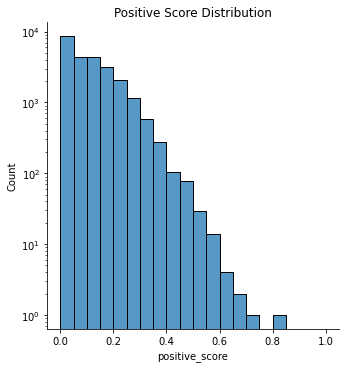

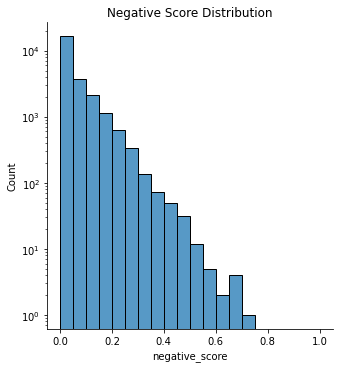

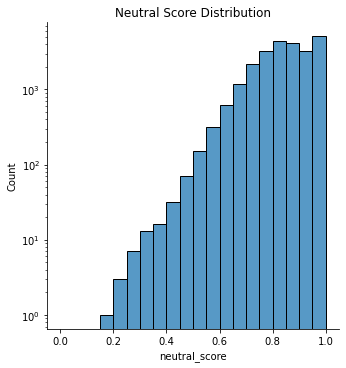

In [121]:
# Analysis on sentiment scores
# Positive score distribution
plt.figure(figsize=(12, 8))
sns.displot(df_sentiment.positive_score, bins=np.linspace(0, 1, 21))
plt.title("Positive Score Distribution")
plt.yscale('log')


# Negative score distribution
sns.displot(df_sentiment.negative_score, bins=np.linspace(0, 1, 21))
plt.title("Negative Score Distribution")
plt.yscale('log')


# Neutral score distribution
sns.displot(df_sentiment.neutral_score, bins=np.linspace(0, 1, 21))
plt.title("Neutral Score Distribution")
plt.yscale('log')


In [122]:
# Stats for single sentiment scores
df_sentiment_stats = pd.DataFrame({'Negative': df_sentiment['negative_score'].describe(), 'Neutral': df_sentiment['neutral_score'].describe(),
                                   'Positive': df_sentiment['positive_score'].describe()}).transpose().drop(columns='count')

df_sentiment_stats

,mean,std,min,25%,50%,75%,max
Negative,0.046666,0.075072,0.000,0.000,0.000,0.075,0.726
Neutral,0.846851,0.112801,0.187,0.777,0.852,0.929,1.000
Positive,0.106481,0.100212,0.000,0.000,0.094,0.168,0.813


In [123]:
# Check if the difference between positive and negative scores are significant
# P-value is near to 0, which means they are significantly different

ttest_ind(df_sentiment.positive_score, df_sentiment.negative_score)

Ttest_indResult(statistic=75.21337341467058, pvalue=0.0)

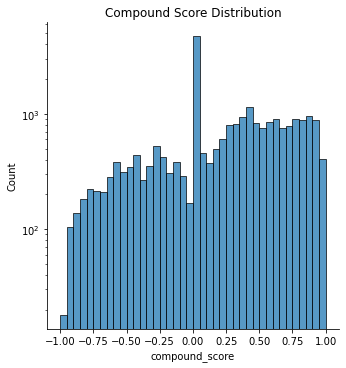

In [124]:
# Finally we check the compound score distribution
sns.displot(df_sentiment.compound_score, bins=np.linspace(-1, 1, 41))
plt.title("Compound Score Distribution")
plt.yscale('log')

In [125]:
# Stats for the compound sentiment score
df_compound_stats = pd.DataFrame({'Compound': df_sentiment.compound_score.describe()}).transpose().drop(columns='count')
df_compound_stats

,mean,std,min,25%,50%,75%,max
Compound,0.228667,0.464386,-0.9836,0.0,0.2561,0.624,0.9948


In [126]:
# Assign sentiments to quotations by default threshold (+0.05 & -0.05)
df_sentiment.loc[df_sentiment['compound_score'] <= -0.05, 'sentiment'] = 'negative'
df_sentiment.loc[df_sentiment['compound_score'] >= 0.05, 'sentiment'] = 'positive'
df_sentiment.loc[(df_sentiment['compound_score'] > -0.05) & (df_sentiment['compound_score'] < 0.05), 'sentiment'] = 'neutral'

temp = df_sentiment.groupby('sentiment').size().tolist()
df_sentiment_stats['count'] = temp

temp = [round(count/len(df_sentiment)*100, 2) for count in temp]    
df_sentiment_stats['%'] = temp

# Check overall single sentiment score stats
df_sentiment_stats

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.046666,0.075072,0.000,0.000,0.000,0.075,0.726,5393,21.76
Neutral,0.846851,0.112801,0.187,0.777,0.852,0.929,1.000,4867,19.63
Positive,0.106481,0.100212,0.000,0.000,0.094,0.168,0.813,14529,58.61


In [127]:
# Check how strong positive/negative quotations sound like (Here set threshold = 0.9)
# Strong positive
df_strong_p = df_sentiment[df_sentiment['compound_score'] >= 0.9][['quotation']]
df_strong_p.sample(5)

,quotation
23898,it fills me with great satisfaction to announc...
19011,i'm coming back into the team as a race winner...
22111,there's definitely an extreme contrast between...
3170,blockchain technologies are set to revolutioni...
8184,decentralizing technologies have enormous pote...


In [128]:
df_strong_p.loc[2442].quotation

"still, as a bitcoin fan, it's amazing to see the price reach a multi-year high and a fantastic performance compared to traditional investment vehicles like stocks and gold."

In [129]:
df_strong_p.loc[3336].quotation

'economic management from central banks lacks transparency and democratic decision-making. bitcoin and cryptocurrencies have created transparent, powerful and democratic financial and economic solutions, which will continue to evolve and create true financial inclusion worldwide. they will achieve the final goal of making the economy grow, stimulate economic activity and create trade and options for people to choose which system and currency to use according to their convenience -- a goal for all countries and central banks,'

In [131]:
df_strong_p.loc[23065].quotation

"confirmation from sec chairman clayton that ethereum is not a security is extremely encouraging for projects in the space and institutional investors, as the criterium for crypto securities becomes more concrete. however, as regulation is inherently slow moving, it is unlikely that this assertion will have any long term effect on the rapidly evolving cryptosphere. while progressive thinking from the sec is a positive step forward, clayton's statement is simply an indication, not a guarantee, of regulation. stipulating that the status of a digital asset offered or sold as a security is not static, crypto innovators should remain vigilant in the likely event that the historically fluid crypto security standards change. while we should commend the sec on these positive developments, reestablishing the level of decentralisation has previously been spoken of as a determining factor and ultimately offers nothing new. it's good to have a second verbal confirmation, but other than a tax impac

In [132]:
# Strong negative
df_strong_n = df_sentiment[df_sentiment['compound_score'] <= -0.9][['quotation']]
df_strong_n.sample(5)

,quotation
22750,if the sonowal government and the btc authorit...
909,this is all from over 10 trillion log lines a ...
7271,i have asked my officials to obtain a legal op...
670,"as a unanimous jury has found, ross william ul..."
25661,we might even boycott the bodoland people's fr...


In [133]:
df_strong_n.loc[254].quotation

"hardware wallets seem like a very good solution for the masses, but i have not personally evaluated any or looked into the different products in detail, so i decline to make any specific recommendation. there are a number of things that are catastrophic if gotten wrong in hardware wallets such as nonce-reuse and poor random key generation. multisig is also great-especially for businesses - and many of the highest balance bitcoin addresses use it these days, but i don't think it's ready for the average bitcoin user quite yet."

In [134]:
df_strong_n.loc[17192].quotation

"the setup or institutional arrangement around bitcoin and other cryptocurrencies, first of all, they have problems with fraud, problems with money laundering, terror financing. there's a lot of problems there."

In [135]:
df_strong_n.loc[14941].quotation

'further, in a recently released study by a university of texas at austin professor, bitcoin prices may have artificially risen last year because of price manipulation fraud. over half of all u.s. financial fraud victims are over the age of 70. we must bring the disinfecting light of transparency to the cryptocurrency industry in florida by requiring those that are florida-based to register with the office of financial regulation.'

In [136]:
# Check how neutral quotations sound like (Here between -0.05 & 0.05)
df_sentiment[df_sentiment['sentiment'] == 'neutral'][['quotation']].sample(5)

,quotation
19383,"cardano starts from peer-related research,"
4366,"although bitcoin is anonymized, researchers ca..."
15223,the ethereum foundation-funded research team w...
16609,"to see bitcoin go to $17,000 [ last year ] -- ..."
14108,there's a very high correlation between the pr...


In [137]:
df_sentiment.loc[343].quotation

"among the bitcoin he received to his laptop, over 88 percent of those transactions weren't tumbled. they were sent directly from the marketplace to his wallet,"

In [138]:
df_sentiment.loc[9443].quotation

'exchanges appear to be queuing up to offer bitcoin futures, with nasdaq yesterday saying it plans to follow the cme and offer bitcoin futures in the first half of 2018.'

In [139]:
df_sentiment.loc[13630].quotation

'in a world where all things were priced in bitcoin, this would likely translate into massive swings in inflation and economic activity,'

**General Analysis**:

A general sentiment analysis over the cryptocurrency related quotation reveals that most quotations are of mild positive sentiment. By comparing the positive score with the negative score, we can see that the former one is higher on mean and percentile values, with a less left-skewed distribution, and this difference is student t-test significant. This indicates that the overall attitude over cryptocurrency quotations in QuoteBank is more positive. We can strengthen this conclusion by the distribution of the compound score. Excluding the dense distribution at [0, 0.05] (positive neutral), compound scores are more right-skewed, which indicates that most quotations are considered as positive. Mean and quantile values of the compound scores are also consistent with this conclusion. 

By checking the positive/negative/neutral sub-score distributions, we can also see that most quotations fall in the following interval: [0, 0.2] for positive/negative sentiment, [0.8, 1.0] for neutral sentiment, this shows that quotations are typically slightly emotional. However, we can also see that quotations with relatively strong emotional tendency (positive/negative score > 0.2) takes a nonnegligible portion. Further checking on extreme samples show speaker's strong supportive or opposed words on crypto-related topics, whereas neutral samples typically state speaker's objective analysis or descriptive demonstrations on crypto. 

### How speakers' sentiment change over time

Following the time analysis we used for topic modeling, we use the same time separation to analyze the fluctuation of speaker's sentiment towards crypto-related topics. Here we restate the separation standard:

* 2015.01 - 2015.12
* 2016.01 - 2016.12
* 2017.01 - 2017.09
* 2017.09 - 2018.03 (to identify major events)
* 2018.04 - 2018.12
* 2019.01 - 2019.12
* 2020.01 - (Latest Date in Dataset)

Now we will conduct separate analysis within these periods to see how speakers' sentiment change over the 6 years. 

In [140]:
# Separate quotations by year & month
df_sentiment_2015 = df_sentiment[df_sentiment.year == 2015]
df_sentiment_2016 = df_sentiment[df_sentiment.year == 2016]
df_sentiment_2017 = df_sentiment[(df_sentiment.year == 2017) & (df_sentiment.month <= 9)]
df_sentiment_2018 = df_sentiment[(df_sentiment.year == 2018) & (df_sentiment.month >= 4)]
df_sentiment_2019 = df_sentiment[df_sentiment.year == 2019]
df_sentiment_2020 = df_sentiment[df_sentiment.year == 2020]

event_period = ["2017-10", "2017-11", "2017-12", "2018-01", "2018-02", "2018-03"]
df_sentiment_event = df_sentiment[df_sentiment.year_month.isin(event_period)]

df_sentiment_list = [df_sentiment_2015, df_sentiment_2016, df_sentiment_2017, df_sentiment_event, df_sentiment_2018,
                     df_sentiment_2019, df_sentiment_2020]


In [141]:
# To simplify repetitive analysis, we define util functions
def score_plot(df_sentiment):
    figs, axes = plt.subplots(1, 4, figsize=(20, 6))
    axes.ravel()
    
    # Positive score distribution
    pos_fig = sns.histplot(df_sentiment.positive_score, bins=np.linspace(0, 1, 21), ax=axes[0])
    pos_fig.set_title("Positive Score Distribution")
    pos_fig.set_yscale('log')
    pos_fig.set_ylim(0, 6000)

    # Negative score distribution
    neg_fig = sns.histplot(df_sentiment.negative_score, bins=np.linspace(0, 1, 21), ax=axes[1])
    neg_fig.set_title("Negative Score Distribution")
    neg_fig.set_yscale('log')
    neg_fig.set_ylim(0, 6000)

    # Neutral score distribution
    neu_fig = sns.histplot(df_sentiment.neutral_score, bins=np.linspace(0, 1, 21), ax=axes[2])
    neu_fig.set_title("Neutral Score Distribution")
    neu_fig.set_yscale('log')
    neu_fig.set_ylim(0, 6000)
    
    # Finally we check the compound score distribution
    comp_fig = sns.histplot(df_sentiment.compound_score, bins=np.linspace(-1, 1, 41), ax=axes[3])
    comp_fig.set_title("Compound Score Distribution")
    comp_fig.set_yscale('log')
    comp_fig.set_ylim(0, 6000)
    
    figs.tight_layout()


def score_stats(df_sentiment):
    df_sentiment_stats = pd.DataFrame({'Negative': df_sentiment['negative_score'].describe(),
                                       'Neutral': df_sentiment['neutral_score'].describe(),
                                       'Positive': df_sentiment['positive_score'].describe(),
                                       'Compound': df_sentiment['compound_score'].describe()}).transpose().drop(columns = ['count'])
    
    temp = df_sentiment.groupby('sentiment').size().tolist()
    temp.append(len(df_sentiment))
    
    df_sentiment_stats['count'] = temp
    
    temp = [round(count/len(df_sentiment)*100, 2) for count in temp]
    df_sentiment_stats['%'] = temp
    
    display(df_sentiment_stats)
    return df_sentiment_stats

    
def quotation_count(df_sentiment_list):
    df_count = pd.DataFrame()
    count_list = [df_sentiment['quotation'].count() for df_sentiment in df_sentiment_list]
        
    df_count['count'] = count_list
    df_count.index = ['2015.01-2015.12', '2016.01-2016.12', '2017.01-2017.09', 
                        '2017.10-2018.03', '2018.04-2018.12', '2019.01-2019.12',
                        '2020.01-2020.12']
    
    return df_count


In [142]:
# Check the overall quotation number under each sentiment
df_sentiment.groupby('sentiment').size()

sentiment
negative     5393
neutral      4867
positive    14529
dtype: int64

,count,%
2015.01-2015.12,2206,8.90
2016.01-2016.12,1276,5.15
2017.01-2017.09,3088,12.46
2017.10-2018.03,7187,28.99
2018.04-2018.12,5628,22.70
2019.01-2019.12,4378,17.66
2020.01-2020.12,1026,4.14


<AxesSubplot:ylabel='count'>

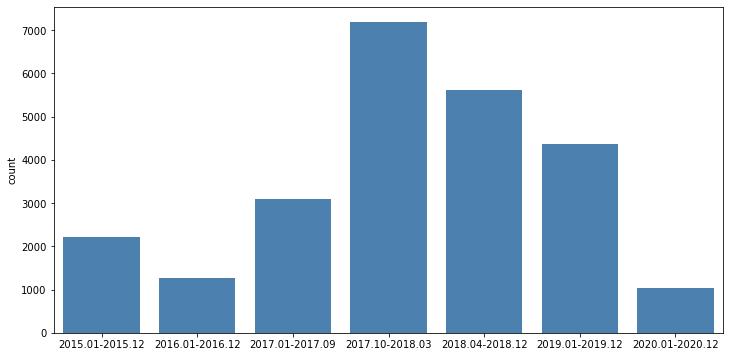

In [143]:
# Check number of quotations in each separated group and plot distribution
df_count = quotation_count(df_sentiment_list)
df_count['%'] = round((df_count['count'] / df_count['count'].sum()) * 100, 2)
display(df_count)
plt.figure(figsize=(12, 6))
sns.barplot(x=df_count.index, y=df_count['count'], color='steelblue', saturation=.9)

#### **2015.01 - 2015.12**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.040606,0.071357,0.0000,0.000,0.0000,0.062750,0.6900,392,17.77
Neutral,0.846330,0.113233,0.2670,0.772,0.8480,0.931000,1.0000,447,20.26
Positive,0.113064,0.102326,0.0000,0.000,0.1020,0.178750,0.7330,1367,61.97
Compound,0.274319,0.462508,-0.9486,0.000,0.3291,0.669925,0.9855,2206,100.00


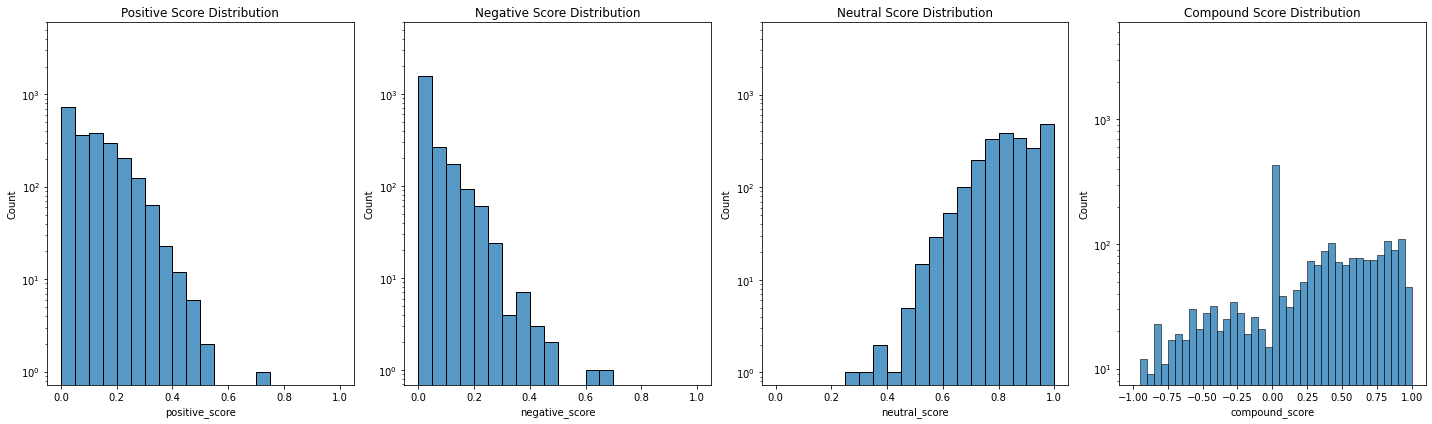

In [144]:
# Check score statistics
stats_2015 = score_stats(df_sentiment_2015)

# Check score distributions
score_plot(df_sentiment_2015)

#### **2016.01 - 2016.12**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.048563,0.078117,0.0000,0.000,0.00000,0.0750,0.726,285,22.34
Neutral,0.839972,0.114003,0.2740,0.771,0.84800,0.9160,1.000,204,15.99
Positive,0.111467,0.100994,0.0000,0.000,0.09900,0.1720,0.545,787,61.68
Compound,0.258428,0.472520,-0.9595,0.000,0.31025,0.6597,0.990,1276,100.00


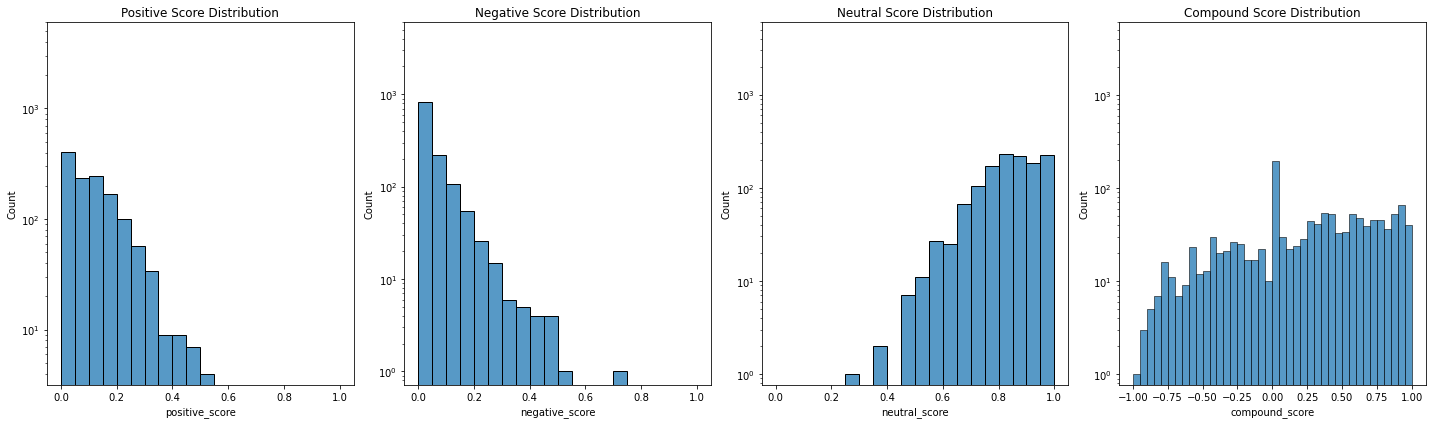

In [145]:
# Check score statistics
stats_2016 = score_stats(df_sentiment_2016)

# Check score distributions
score_plot(df_sentiment_2016)

#### **2017.01 - 2017.09**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.046747,0.074630,0.0000,0.00,0.000,0.078250,0.5140,697,22.57
Neutral,0.845908,0.109594,0.2510,0.78,0.848,0.924000,1.0000,585,18.94
Positive,0.107340,0.099031,0.0000,0.00,0.096,0.171250,0.6100,1806,58.48
Compound,0.225023,0.473514,-0.9836,0.00,0.250,0.626225,0.9948,3088,100.00


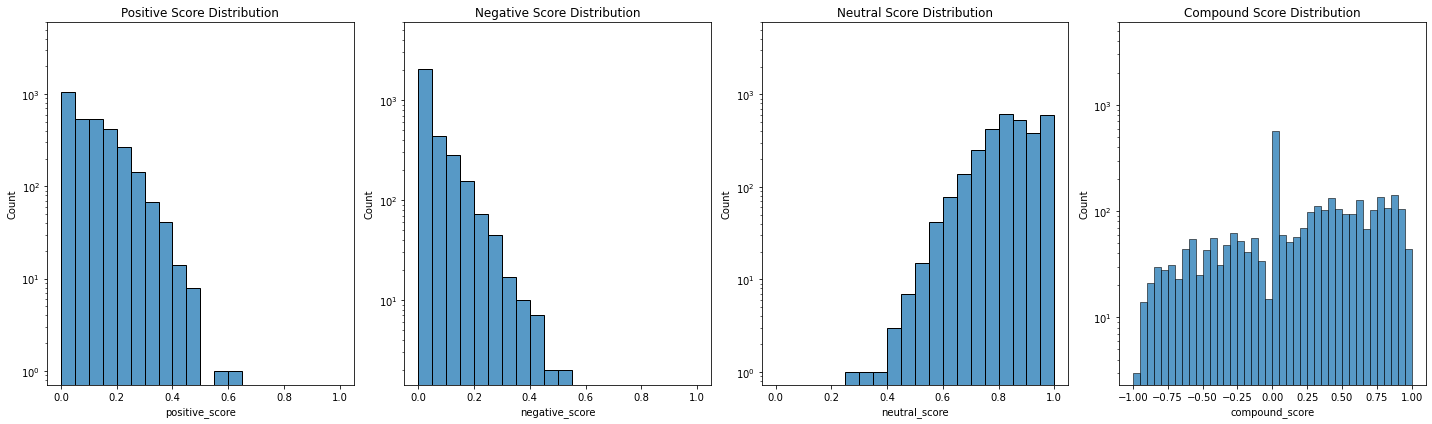

In [146]:
# Check score statistics
stats_2017 = score_stats(df_sentiment_2017)

# Check score distributions
score_plot(df_sentiment_2017)

#### **2017.10 - 2018.04** (Major Event Period)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.048367,0.075864,0.0000,0.000,0.0000,0.0770,0.676,1635,22.75
Neutral,0.849396,0.114467,0.1870,0.779,0.8550,0.9380,1.000,1542,21.46
Positive,0.102232,0.101194,0.0000,0.000,0.0870,0.1620,0.813,4010,55.80
Compound,0.200211,0.450792,-0.9783,0.000,0.2023,0.5719,0.994,7187,100.00


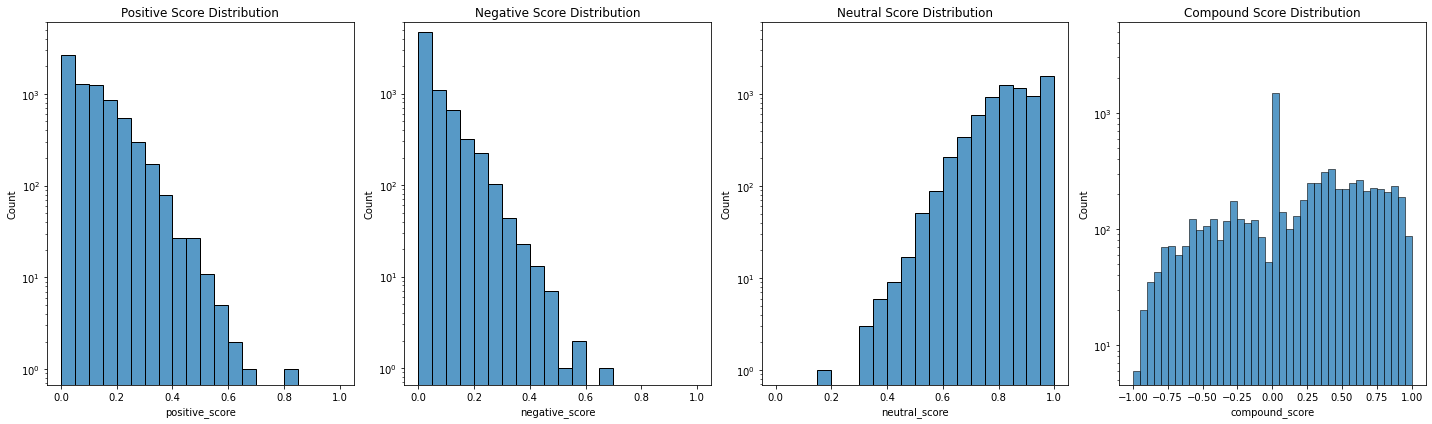

In [147]:
# Check score statistics
stats_event = score_stats(df_sentiment_event)

# Check score distributions
score_plot(df_sentiment_event)

#### **2018.05 - 2018.12**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.046915,0.076679,0.0000,0.000,0.0000,0.073000,0.6520,1207,21.45
Neutral,0.847243,0.113523,0.2200,0.776,0.8550,0.928000,1.0000,1087,19.31
Positive,0.105841,0.099389,0.0000,0.000,0.0930,0.165000,0.6640,3334,59.24
Compound,0.233995,0.470228,-0.9825,0.000,0.2732,0.631775,0.9905,5628,100.00


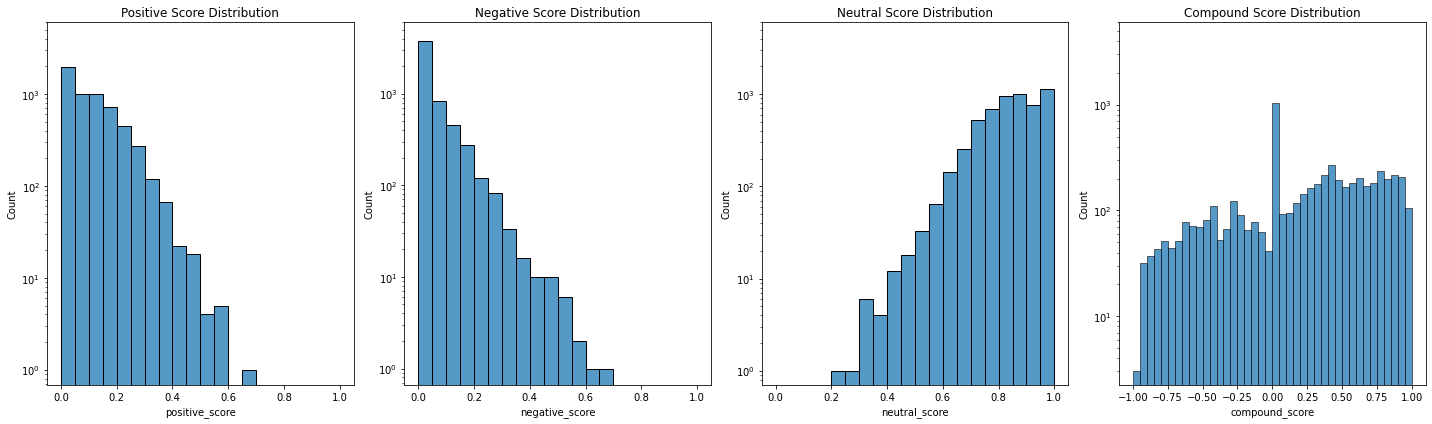

In [148]:
# Check score statistics
stats_2018 = score_stats(df_sentiment_2018)

# Check score distributions
score_plot(df_sentiment_2018)

#### **2019.01 - 2019.12**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.046374,0.073631,0.0000,0.000,0.000,0.0760,0.6690,950,21.70
Neutral,0.843686,0.111662,0.2440,0.775,0.849,0.9250,1.0000,793,18.11
Positive,0.109941,0.099789,0.0000,0.000,0.099,0.1720,0.6150,2635,60.19
Compound,0.242858,0.469822,-0.9713,0.000,0.296,0.6369,0.9862,4378,100.00


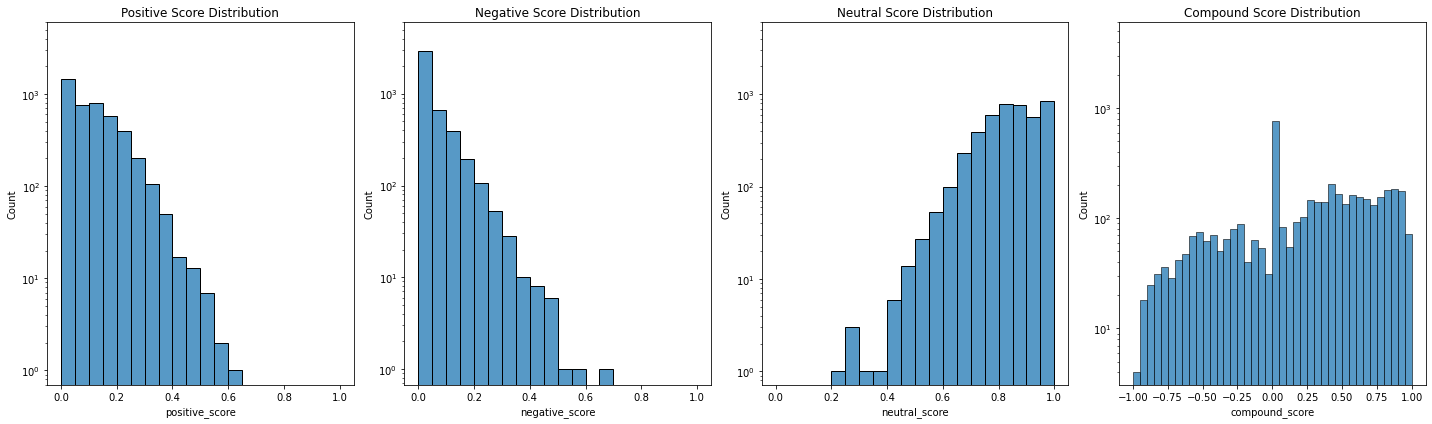

In [149]:
# Check score statistics
stats_2019 = score_stats(df_sentiment_2019)

# Check score distributions
score_plot(df_sentiment_2019)

#### **2020.01 - (Latest Date in Dataset)**

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.045052,0.071342,0.0000,0.000,0.00000,0.07300,0.5310,227,22.12
Neutral,0.852886,0.108387,0.2380,0.788,0.85700,0.92975,1.0000,209,20.37
Positive,0.102061,0.096152,0.0000,0.000,0.09100,0.16400,0.5510,590,57.50
Compound,0.214018,0.456543,-0.9778,0.000,0.21835,0.58590,0.9775,1026,100.00


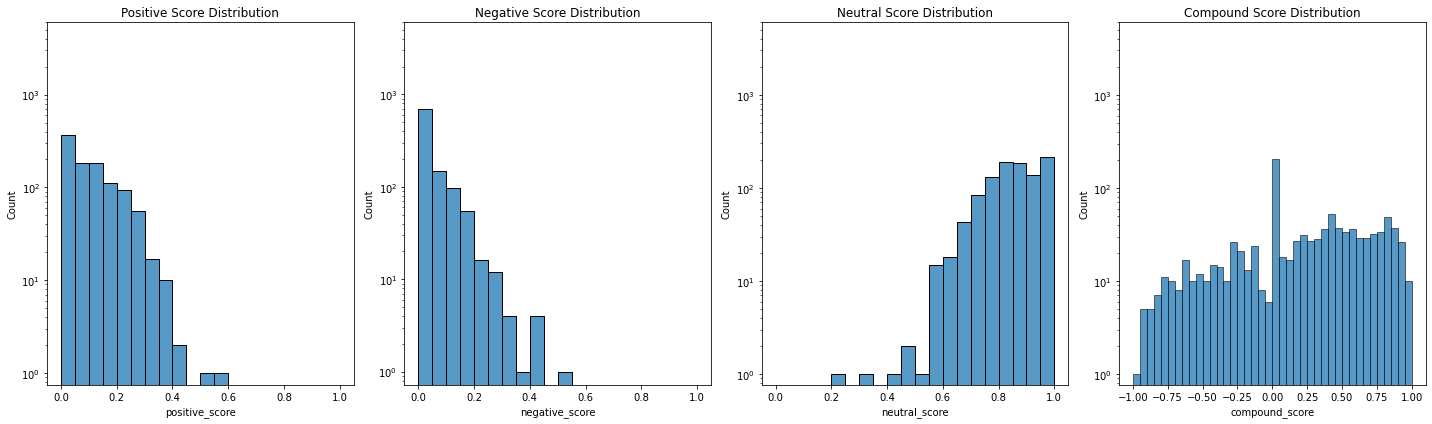

In [150]:
# Check score statistics
stats_2020 = score_stats(df_sentiment_2020)

# Check score distributions
score_plot(df_sentiment_2020)

#### **Sentiment Analysis Over Time**

In [151]:
# Combine all stats by score types over the separations
stats_list = [stats_2015, stats_2016, stats_2017, stats_event,
              stats_2018, stats_2019, stats_2020]


def stats_merge(stats_list, score_type):
    
    stats_merge = pd.concat(stats_list)
    stats_merge = stats_merge[stats_merge.index == score_type]
    
    stats_merge.index = ['2015.01-2015.12', '2016.01-2016.12', '2017.01-2017.09', 
                         '2017.10-2018.03', '2018.04-2018.12', '2019.01-2019.12',
                         '2020.01-']
    
    return stats_merge


In [152]:
stats_p = stats_merge(stats_list, 'Positive')
stats_neg = stats_merge(stats_list, 'Negative')
stats_neu = stats_merge(stats_list, 'Neutral')
stats_comp = stats_merge(stats_list, 'Compound')

,mean,std,min,25%,50%,75%,max,count,%
2015.01-2015.12,0.113064,0.102326,0.0,0.0,0.102,0.17875,0.733,1367,61.97
2016.01-2016.12,0.111467,0.100994,0.0,0.0,0.099,0.17200,0.545,787,61.68
2017.01-2017.09,0.107340,0.099031,0.0,0.0,0.096,0.17125,0.610,1806,58.48
2017.10-2018.03,0.102232,0.101194,0.0,0.0,0.087,0.16200,0.813,4010,55.80
2018.04-2018.12,0.105841,0.099389,0.0,0.0,0.093,0.16500,0.664,3334,59.24
2019.01-2019.12,0.109941,0.099789,0.0,0.0,0.099,0.17200,0.615,2635,60.19
2020.01-,0.102061,0.096152,0.0,0.0,0.091,0.16400,0.551,590,57.50


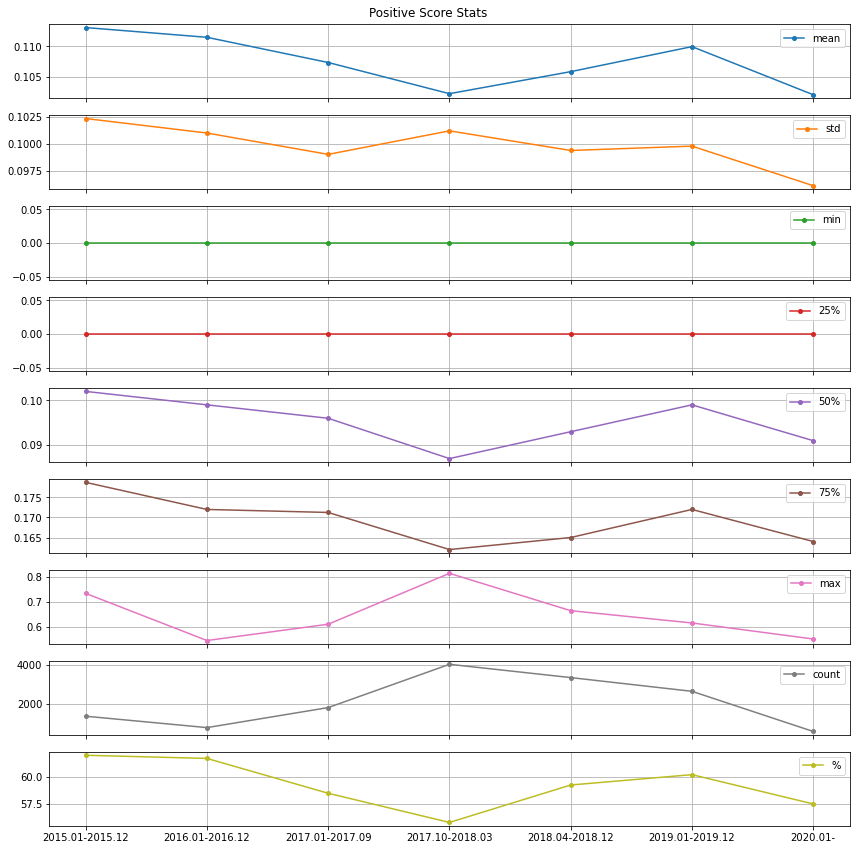

In [153]:
# Positive Score Analysis
display(stats_p)

stats_p.plot(kind='line', subplots=True, figsize=(12, 12), title='Positive Score Stats', grid=True, style='.-', ms=8)
plt.tight_layout()

,mean,std,min,25%,50%,75%,max,count,%
2015.01-2015.12,0.040606,0.071357,0.0,0.0,0.0,0.06275,0.690,392,17.77
2016.01-2016.12,0.048563,0.078117,0.0,0.0,0.0,0.07500,0.726,285,22.34
2017.01-2017.09,0.046747,0.074630,0.0,0.0,0.0,0.07825,0.514,697,22.57
2017.10-2018.03,0.048367,0.075864,0.0,0.0,0.0,0.07700,0.676,1635,22.75
2018.04-2018.12,0.046915,0.076679,0.0,0.0,0.0,0.07300,0.652,1207,21.45
2019.01-2019.12,0.046374,0.073631,0.0,0.0,0.0,0.07600,0.669,950,21.70
2020.01-,0.045052,0.071342,0.0,0.0,0.0,0.07300,0.531,227,22.12


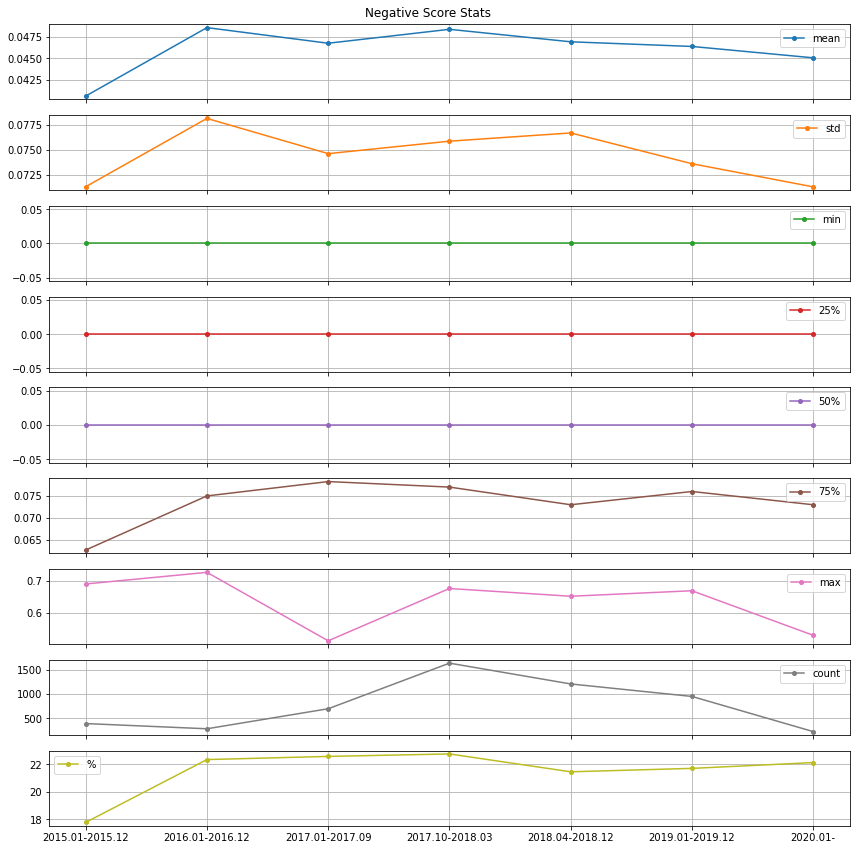

In [154]:
# Negative Score Analysis
display(stats_neg)

stats_neg.plot(kind='line', subplots=True, figsize=(12, 12), title='Negative Score Stats', grid=True, style='.-', ms=8)
plt.tight_layout()

,mean,std,min,25%,50%,75%,max,count,%
2015.01-2015.12,0.846330,0.113233,0.267,0.772,0.848,0.93100,1.0,447,20.26
2016.01-2016.12,0.839972,0.114003,0.274,0.771,0.848,0.91600,1.0,204,15.99
2017.01-2017.09,0.845908,0.109594,0.251,0.780,0.848,0.92400,1.0,585,18.94
2017.10-2018.03,0.849396,0.114467,0.187,0.779,0.855,0.93800,1.0,1542,21.46
2018.04-2018.12,0.847243,0.113523,0.220,0.776,0.855,0.92800,1.0,1087,19.31
2019.01-2019.12,0.843686,0.111662,0.244,0.775,0.849,0.92500,1.0,793,18.11
2020.01-,0.852886,0.108387,0.238,0.788,0.857,0.92975,1.0,209,20.37


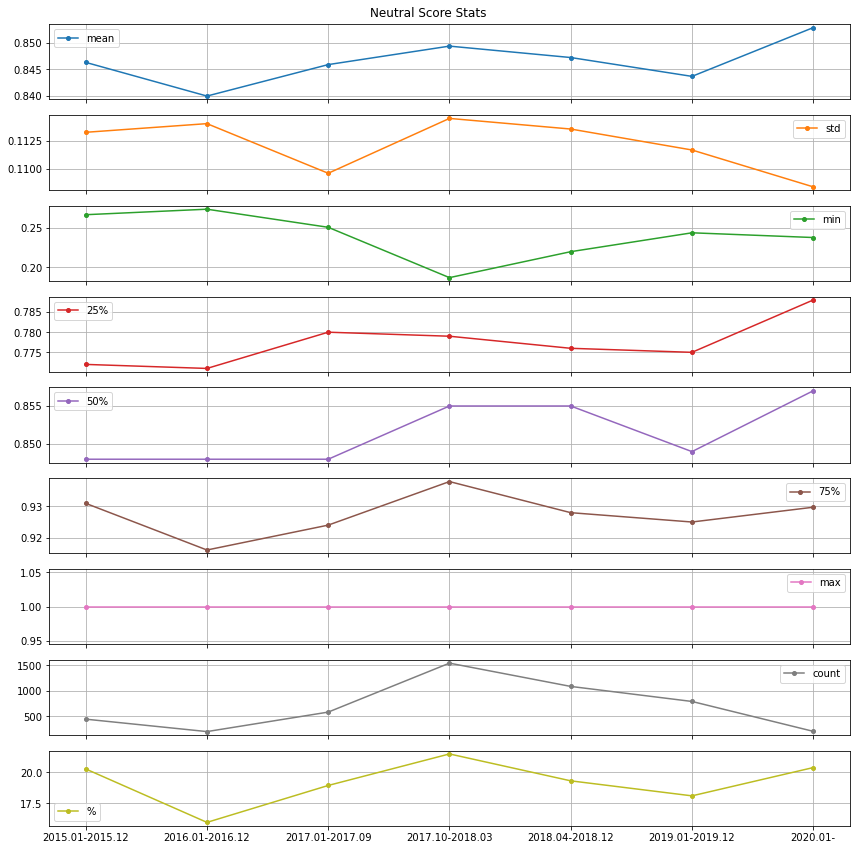

/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [155]:
# Neutral Score Analysis
display(stats_neu)

stats_neu.plot(kind='line', subplots=True, figsize=(12, 12), title='Neutral Score Stats', grid=True, style='.-', ms=8)
plt.tight_layout()

,mean,std,min,25%,50%,75%,max,count,%
2015.01-2015.12,0.274319,0.462508,-0.9486,0.0,0.32910,0.669925,0.9855,2206,100.0
2016.01-2016.12,0.258428,0.472520,-0.9595,0.0,0.31025,0.659700,0.9900,1276,100.0
2017.01-2017.09,0.225023,0.473514,-0.9836,0.0,0.25000,0.626225,0.9948,3088,100.0
2017.10-2018.03,0.200211,0.450792,-0.9783,0.0,0.20230,0.571900,0.9940,7187,100.0
2018.04-2018.12,0.233995,0.470228,-0.9825,0.0,0.27320,0.631775,0.9905,5628,100.0
2019.01-2019.12,0.242858,0.469822,-0.9713,0.0,0.29600,0.636900,0.9862,4378,100.0
2020.01-,0.214018,0.456543,-0.9778,0.0,0.21835,0.585900,0.9775,1026,100.0


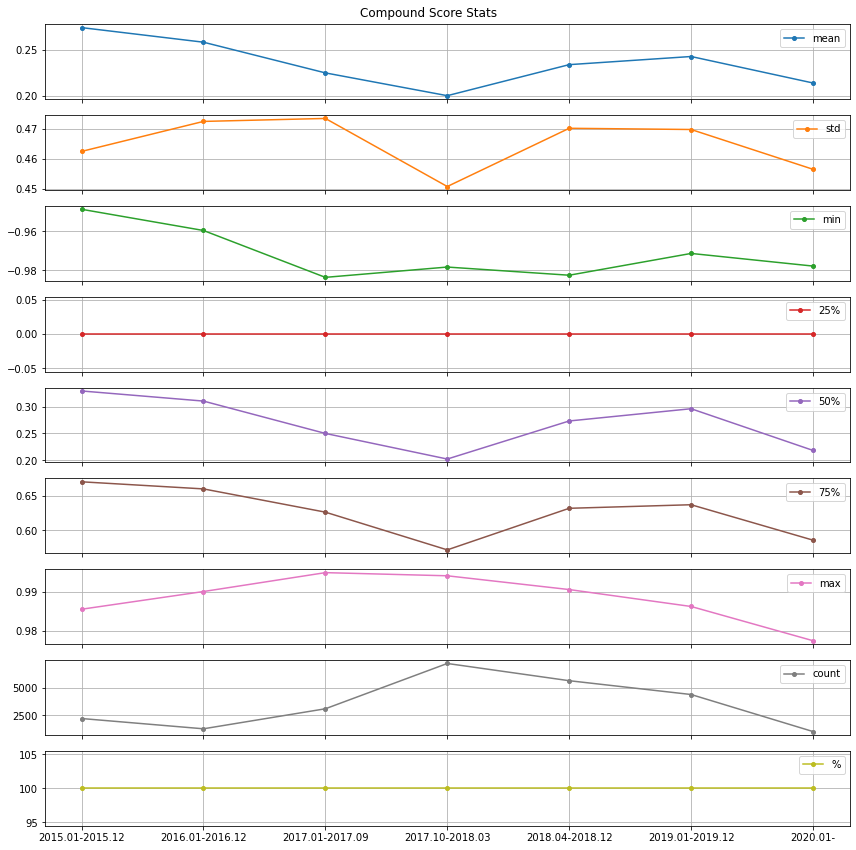

In [156]:
# Compound Score Analysis
display(stats_comp)

stats_comp.plot(kind='line', subplots=True, figsize=(12, 12), title='Compound Score Stats', grid=True, style='.-', ms=8)
plt.tight_layout()

**Summary of Sentiment Analysis Over Time**:
* Crypto-related quotations concentrated on the following time separations: **2017.09-2018.04** (event period), **2018.05-2018.12**, and **2019.01-2019.12**, which is generally from September 2017 to December 2019. Quotations from this period take up **69.36%** of the total quotations.
* From compound score stats, we can clearly see that there exists a valley point of the mean value, 50% percentile (median), and 75% percentile during the event period, this reveals that the distribution is less right-skewed, we can confirm this by examining the compound store histogram and the score stats of the event period. The histogram shows that the difference of left section (generally negative) and the right section (generally positive) is smaller. The score stats also shows that percentage of negative and neutral quotations both reach a summit, whereas the percentage of positive quotations clearly reduces. Besides, we can catch a general sentiment trend from 2015 to 2020 by examining the line graphs: **speakers in QuoteBank are losing their positive comments towards crypto-related topics**.
* From positive score stats, we can see that the percentage of positive quotations is at the highest in 2015, then stably declines and reaches a lowest point in the event period, although the percentage bounces in 2018 & 2019, it still drops in 2020's quotations. The positive score mean, median, and 75% percentile are consistent with this trend, except for the mean reaches the valley point in 2020. However, we notice that the most positive quotation happens to occur in the event period. In the histogram we also notice there exists more very positive quotations (positive score > 0.6) than any other period both numerically and proportionally, this hints a polarized sentiment trend during this period.
* From negative score stats, we can see that the percentage of negative quotations greatly increases in 2016 and then gradually increases to the highest during the event period. Although slightly decreases later, it still remains at highs. The negative score mean and 75% percentile follows this trend. An interesting point is that over 50% of quotations have no negative sentiment and the 75% percentile is less than 0.1, this means that the level of negative sentiment is relatively low. 
* From neutral score stats, we can see that the percentage of neutral quotations fluctuates among different periods, lowest in 2016 and highest in the event period. Combining the former analysis, quotations are becoming more neutral throughout the years (generally rising mean and the quantiles), and shows a polarized sentiment pattern (lowest neutral score in the event period, and increasing proportion of very biased (neutral score < 0.4) quotations).

### Sentiment Analysis by Selected Speakers

To be consistent with the former LDA topic modeling, we also select **businessman** (in dataset as **businessperson**) and **politician** to conduct independent and comparative sentiment anallysis. We start by firstly extract those quotations without irrelevant columns such as stopwords, tokenized words, and stats on punc & words.

In [157]:
# We extract selected speakers' quotations as stated before, by different occupation
df_speaker_quotation = occupation_extract(df_quotation, df_speaker_attr, sentiment=True)

df_business_sentiment = occupation_type(df_speaker_quotation, "businessperson")
df_politician_sentiment = occupation_type(df_speaker_quotation, "politician")

display(df_business_sentiment.head())
display(df_politician_sentiment.head())

,year,date,quotation,qids,nonstop_word,month,year_month,occupation
32,2015,2015-10-15,the public offer will mark a significant miles...,Q7407782,"[public, offer, mark, significant, milestone, ...",10,2015-10,businessperson
52,2015,2015-02-10,"bitcoin is built with clay feet,",Q47451365,"[bitcoin, build, clay, foot]",2,2015-02,businessperson
55,2015,2015-06-14,the first part of the fund is a way to give fa...,Q58038104,"[fund, fast, return, investor, want, power, cr...",6,2015-06,businessperson
61,2015,2015-03-11,you're also seeing traditional leaders embrace...,Q5231336,"[see, traditional, leader, embrace, bitcoin]",3,2015-03,businessperson
79,2015,2015-02-10,"ninety-percent (of bitcoins) are being hoarded,",Q47451365,"[ninety, percent, bitcoin, hoard]",2,2015-02,businessperson


,year,date,quotation,qids,nonstop_word,month,year_month,occupation
4,2015,2015-06-22,if each bitcoin has a history and people know ...,Q46997142,"[bitcoin, history, people, know, maybe, people...",6,2015-06,politician
50,2015,2015-06-23,"and most of all, [ it has confused ] our messa...",Q46997142,"[confuse, message, public, bitcoin, ability, s...",6,2015-06,politician
51,2015,2015-01-05,it kills any chance that bitcoin could be a ma...,Q5239364,"[kill, chance, bitcoin, mainstream, currency, ...",1,2015-01,politician
52,2015,2015-02-10,"bitcoin is built with clay feet,",Q47451365,"[bitcoin, build, clay, foot]",2,2015-02,politician
59,2015,2015-03-18,i want to do my btcc seat justice,Q20714062,"[want, btcc, seat, justice]",3,2015-03,politician


### Business person

In [158]:
# Firstly we calculate sentiment scores and add them to dataframe
df_business_sentiment = sentiment_analysis(df_business_sentiment, 'quotation')

df_business_sentiment.head()

,year,date,quotation,qids,nonstop_word,month,year_month,occupation,compound_score,positive_score,neutral_score,negative_score
32,2015,2015-10-15,the public offer will mark a significant miles...,Q7407782,"[public, offer, mark, significant, milestone, ...",10,2015-10,businessperson,0.8316,0.193,0.807,0.000
52,2015,2015-02-10,"bitcoin is built with clay feet,",Q47451365,"[bitcoin, build, clay, foot]",2,2015-02,businessperson,0.0000,0.000,1.000,0.000
55,2015,2015-06-14,the first part of the fund is a way to give fa...,Q58038104,"[fund, fast, return, investor, want, power, cr...",6,2015-06,businessperson,0.4215,0.076,0.899,0.025
61,2015,2015-03-11,you're also seeing traditional leaders embrace...,Q5231336,"[see, traditional, leader, embrace, bitcoin]",3,2015-03,businessperson,0.3182,0.277,0.723,0.000
79,2015,2015-02-10,"ninety-percent (of bitcoins) are being hoarded,",Q47451365,"[ninety, percent, bitcoin, hoard]",2,2015-02,businessperson,0.0000,0.000,1.000,0.000


In [159]:
# Define function to assign sentiments to quotations by default threshold (+0.05 & -0.05)

def assign_sentiment(df_sentiment):
    df_sentiment.loc[df_sentiment['compound_score'] <= -0.05, 'sentiment'] = 'negative'
    df_sentiment.loc[df_sentiment['compound_score'] >= 0.05, 'sentiment'] = 'positive'
    df_sentiment.loc[(df_sentiment['compound_score'] > -0.05) & (df_sentiment['compound_score'] < 0.05), 'sentiment'] = 'neutral'
    
    return df_sentiment

### General Analysis

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.042699,0.068119,0.0000,0.00000,0.0000,0.070000,0.451,404,20.22
Neutral,0.848166,0.107227,0.1870,0.77825,0.8510,0.925000,1.000,349,17.47
Positive,0.109138,0.097939,0.0000,0.00000,0.0970,0.170750,0.813,1245,62.31
Compound,0.253480,0.459274,-0.9531,0.00000,0.3182,0.636375,0.994,1998,100.00


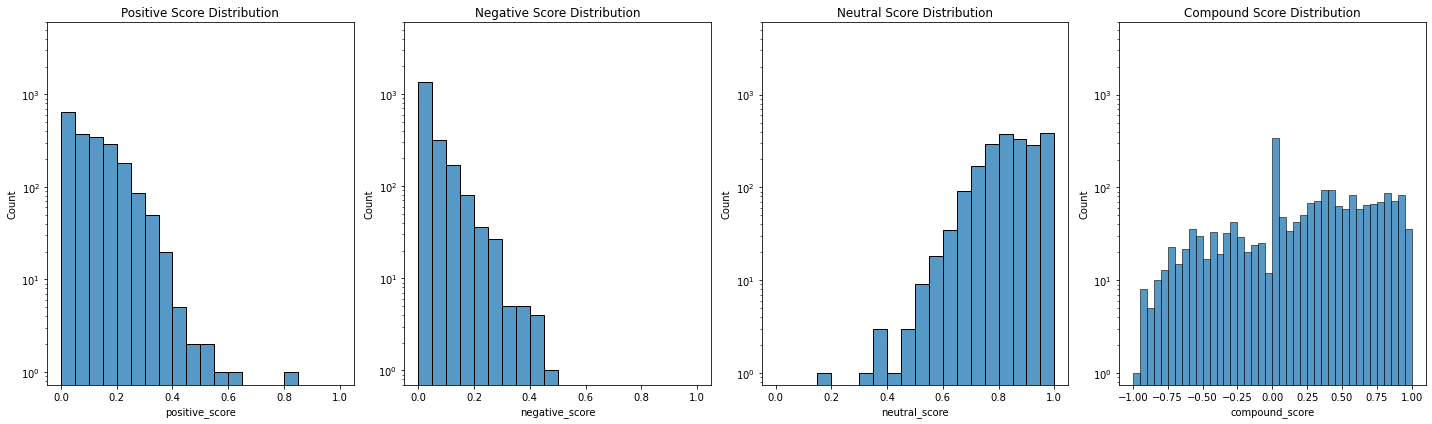

/Users/xuyixuan/opt/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [167]:
# Assign sentiment labels
df_business_sentiment = assign_sentiment(df_business_sentiment)

# Check score stats
stats_business = score_stats(df_business_sentiment)

# Check score distributions
score_plot(df_business_sentiment)

#### Sentiment Analysis over time

In [168]:
# Separate quotations by year & month
df_sentiment_2015 = df_business_sentiment[df_business_sentiment.year == 2015]
df_sentiment_2016 = df_business_sentiment[df_business_sentiment.year == 2016]
df_sentiment_2017 = df_business_sentiment[(df_business_sentiment.year == 2017) & (df_business_sentiment.month <= 9)]
df_sentiment_2018 = df_business_sentiment[(df_business_sentiment.year == 2018) & (df_business_sentiment.month >= 4)]
df_sentiment_2019 = df_business_sentiment[df_business_sentiment.year == 2019]
df_sentiment_2020 = df_business_sentiment[df_business_sentiment.year == 2020]

event_period = ["2017-10", "2017-11", "2017-12", "2018-01", "2018-02", "2018-03"]
df_sentiment_event = df_business_sentiment[df_business_sentiment.year_month.isin(event_period)]

df_sentiment_list = [df_sentiment_2015, df_sentiment_2016, df_sentiment_2017, df_sentiment_event, df_sentiment_2018,
                              df_sentiment_2019, df_sentiment_2020]

,count,%
2015.01-2015.12,235,11.76
2016.01-2016.12,120,6.01
2017.01-2017.09,290,14.51
2017.10-2018.03,500,25.03
2018.04-2018.12,464,23.22
2019.01-2019.12,322,16.12
2020.01-2020.12,67,3.35


Text(0.5, 1.0, 'Distribution of # Quotations of Businessperson Among Periods')

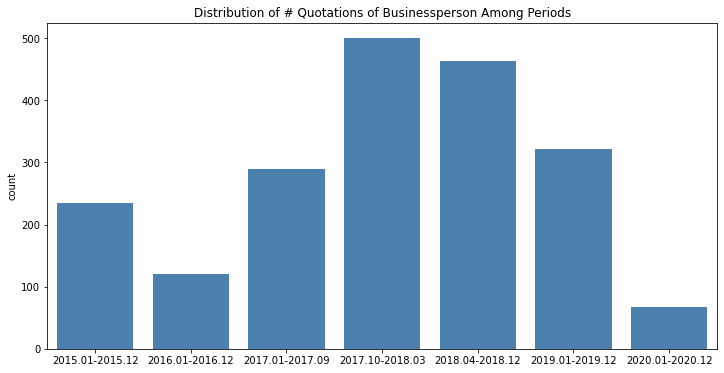

In [169]:
# Check number of quotations in each separated group and plot distribution
df_count = quotation_count(df_sentiment_list)
df_count['%'] = round((df_count['count'] / df_count['count'].sum()) * 100, 2)

display(df_count)

plt.figure(figsize=(12, 6))
sns.barplot(x=df_count.index, y=df_count['count'], color='steelblue', saturation=.9)
plt.title('Distribution of # Quotations of Businessperson Among Periods')

In [170]:
df_business_sentiment

,year,date,quotation,qids,nonstop_word,month,year_month,occupation,compound_score,positive_score,neutral_score,negative_score,sentiment
32,2015,2015-10-15,the public offer will mark a significant miles...,Q7407782,"[public, offer, mark, significant, milestone, ...",10,2015-10,businessperson,0.8316,0.193,0.807,0.000,positive
52,2015,2015-02-10,"bitcoin is built with clay feet,",Q47451365,"[bitcoin, build, clay, foot]",2,2015-02,businessperson,0.0000,0.000,1.000,0.000,neutral
55,2015,2015-06-14,the first part of the fund is a way to give fa...,Q58038104,"[fund, fast, return, investor, want, power, cr...",6,2015-06,businessperson,0.4215,0.076,0.899,0.025,positive
61,2015,2015-03-11,you're also seeing traditional leaders embrace...,Q5231336,"[see, traditional, leader, embrace, bitcoin]",3,2015-03,businessperson,0.3182,0.277,0.723,0.000,positive
79,2015,2015-02-10,"ninety-percent (of bitcoins) are being hoarded,",Q47451365,"[ninety, percent, bitcoin, hoard]",2,2015-02,businessperson,0.0000,0.000,1.000,0.000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,2020,2020-03-26,"the company, jbcapitals claimed to invest in b...",Q6163392,"[company, jbcapital, claim, invest, bitcoin, c...",3,2020-03,businessperson,-0.0772,0.060,0.872,0.068,negative
26271,2020,2020-02-03,our job is to make sure that people can buy gr...,Q647498,"[job, sure, people, buy, grocery, choose, stab...",2,2020-02,businessperson,0.7814,0.190,0.810,0.000,positive
26280,2020,2020-02-18,"bitcoin is the most mature blockchain, and eve...",Q9076764,"[bitcoin, mature, blockchain, long, lot, ineff...",2,2020-02,businessperson,0.4754,0.091,0.909,0.000,positive
26285,2020,2020-02-09,btc/usdt premiums and price action show clear ...,Q45362401,"[btc, usdt, premium, price, action, clear, sig...",2,2020-02,businessperson,-0.0808,0.080,0.800,0.120,negative


,mean,std,min,25%,50%,75%,max,count,%
Negative,0.034255,0.062198,0.0000,0.000,0.0000,0.05100,0.2980,28,11.91
Neutral,0.834034,0.105994,0.3880,0.764,0.8300,0.90600,1.0000,32,13.62
Positive,0.131715,0.097613,0.0000,0.051,0.1350,0.19500,0.5150,175,74.47
Compound,0.389206,0.443189,-0.9129,0.000,0.4215,0.79025,0.9773,235,100.00


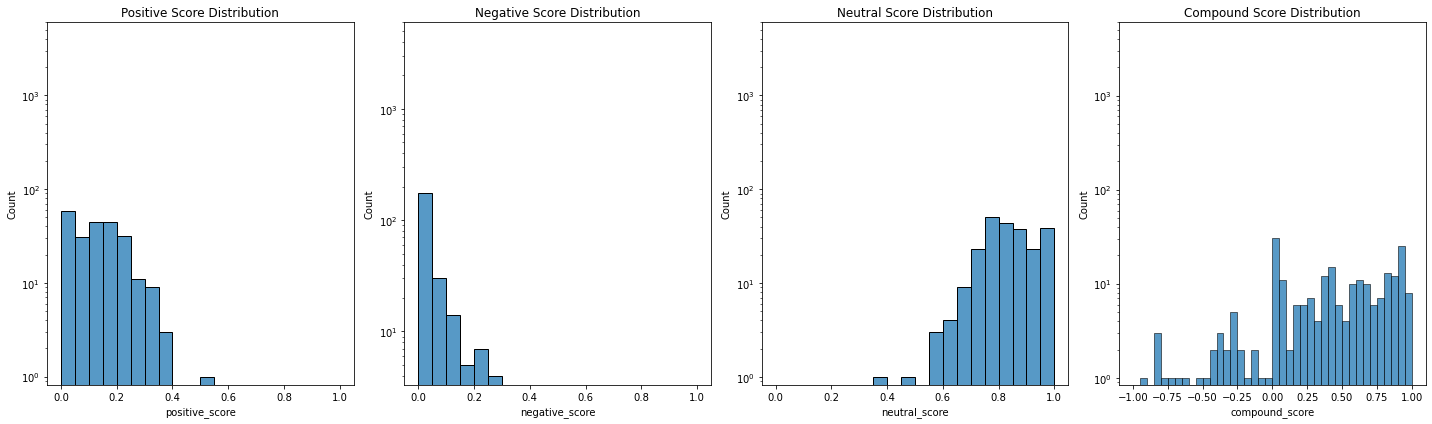

In [171]:
# 2015

# Check score statistics
stats_2015 = score_stats(df_sentiment_2015)

# Check score distributions
score_plot(df_sentiment_2015)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.047575,0.068910,0.0000,0.0000,0.0000,0.07400,0.3320,30,25.00
Neutral,0.847183,0.089252,0.5850,0.7985,0.8545,0.90450,1.0000,11,9.17
Positive,0.105242,0.082910,0.0000,0.0400,0.0965,0.14975,0.3660,79,65.83
Compound,0.225132,0.457523,-0.8225,-0.0193,0.3400,0.59865,0.9783,120,100.00


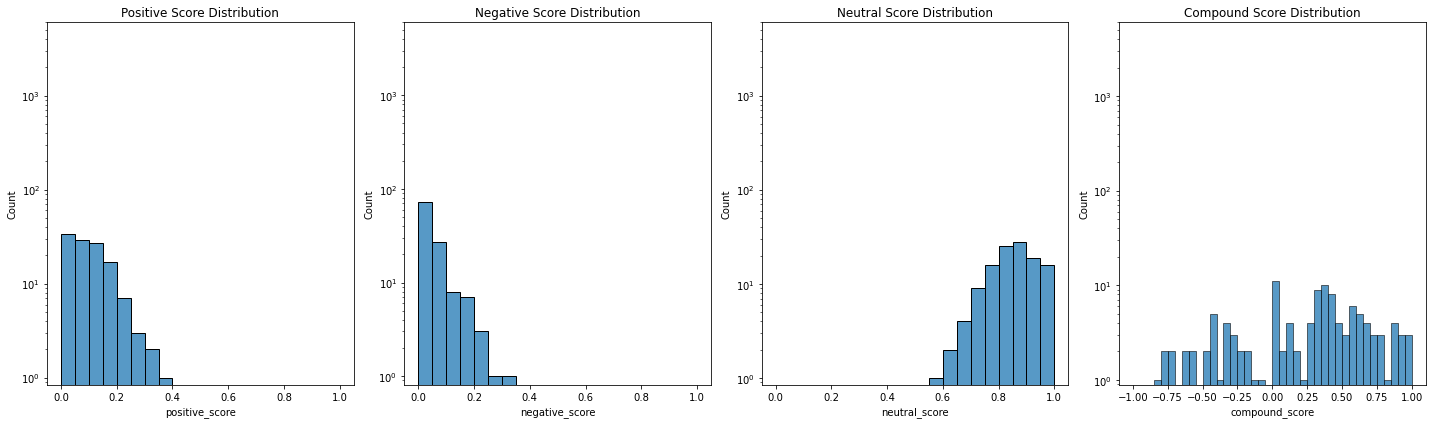

In [172]:
# 2016

# Check score statistics
stats_2016 = score_stats(df_sentiment_2016)

# Check score distributions
score_plot(df_sentiment_2016)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.041214,0.065142,0.0000,0.00000,0.0000,0.06725,0.4330,65,22.41
Neutral,0.859400,0.101251,0.5330,0.79125,0.8690,0.93375,1.0000,52,17.93
Positive,0.099362,0.092850,0.0000,0.00000,0.0875,0.15700,0.4670,173,59.66
Compound,0.218923,0.466028,-0.8271,0.00000,0.2263,0.59100,0.9818,290,100.00


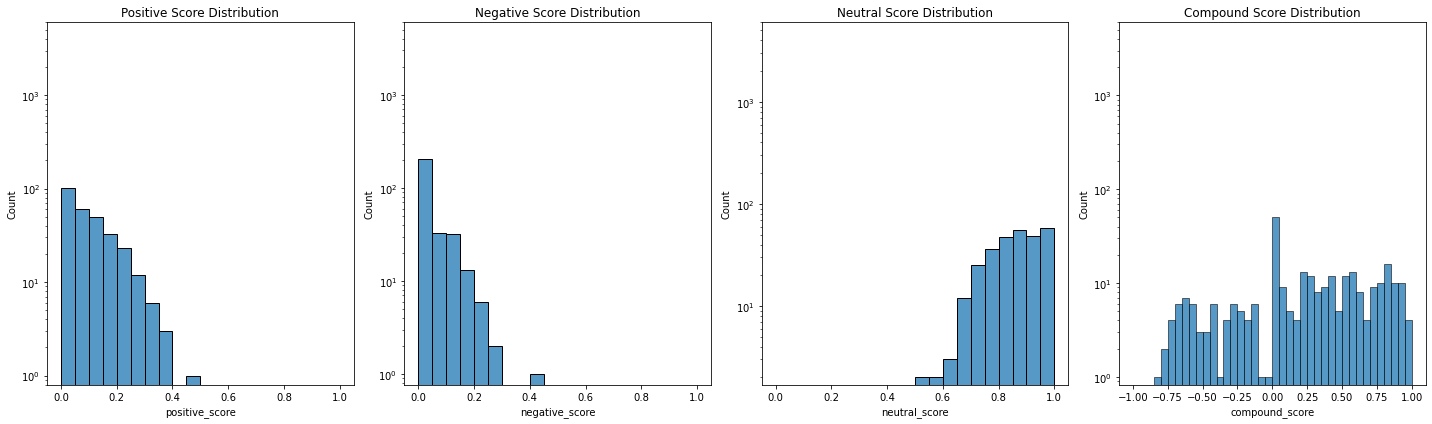

In [173]:
# 2017.01 - 2017.08

# Check score statistics
stats_2017 = score_stats(df_sentiment_2017)

# Check score distributions
score_plot(df_sentiment_2017)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.041732,0.067795,0.0000,0.00000,0.0000,0.07200,0.368,101,20.2
Neutral,0.851234,0.116874,0.1870,0.78375,0.8605,0.93725,1.000,108,21.6
Positive,0.107024,0.107973,0.0000,0.00000,0.0870,0.16525,0.813,291,58.2
Compound,0.228833,0.436342,-0.9048,0.00000,0.2263,0.58590,0.994,500,100.0


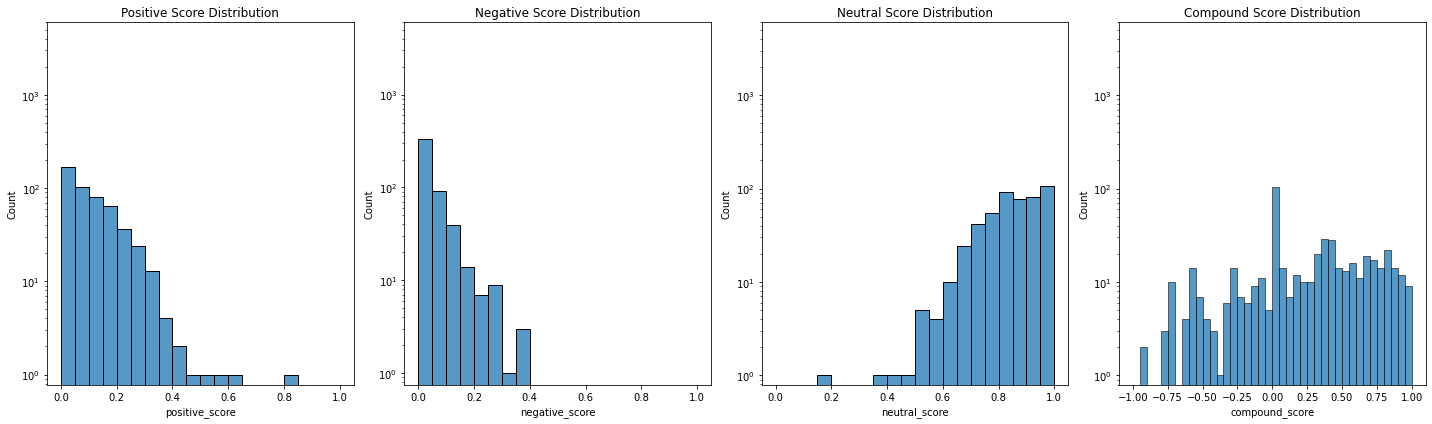

In [174]:
# 2017.09 - 2018.03 (Event Period)

# Check score statistics
stats_event = score_stats(df_sentiment_event)

# Check score distributions
score_plot(df_sentiment_event)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.050791,0.078448,0.0000,0.000,0.0000,0.079250,0.4510,108,23.28
Neutral,0.845832,0.111079,0.3370,0.776,0.8495,0.925000,1.0000,76,16.38
Positive,0.103418,0.096636,0.0000,0.000,0.0910,0.162250,0.4460,280,60.34
Compound,0.220489,0.487855,-0.9531,0.000,0.2732,0.627675,0.9704,464,100.00


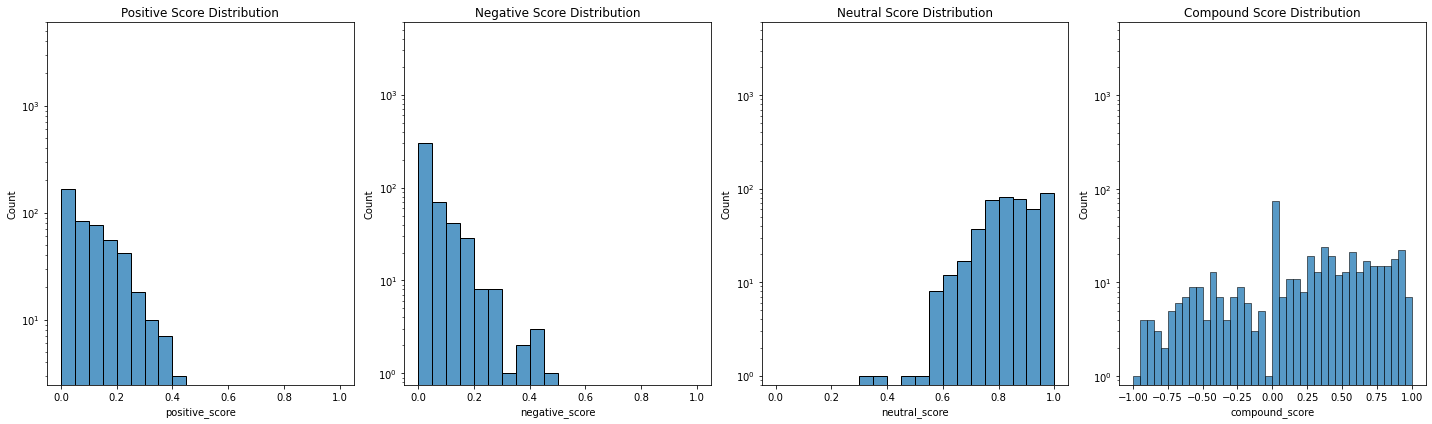

In [175]:
# 2018.04 - 2018.12

# Check score statistics
stats_2018 = score_stats(df_sentiment_2018)

# Check score distributions
score_plot(df_sentiment_2018)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.037969,0.059553,0.0000,0.00000,0.0000,0.06175,0.3180,54,16.77
Neutral,0.842950,0.099635,0.5290,0.77600,0.8385,0.91275,1.0000,54,16.77
Positive,0.119071,0.093317,0.0000,0.02625,0.1205,0.18350,0.3890,214,66.46
Compound,0.304849,0.439433,-0.8834,0.00000,0.3612,0.67050,0.9758,322,100.00


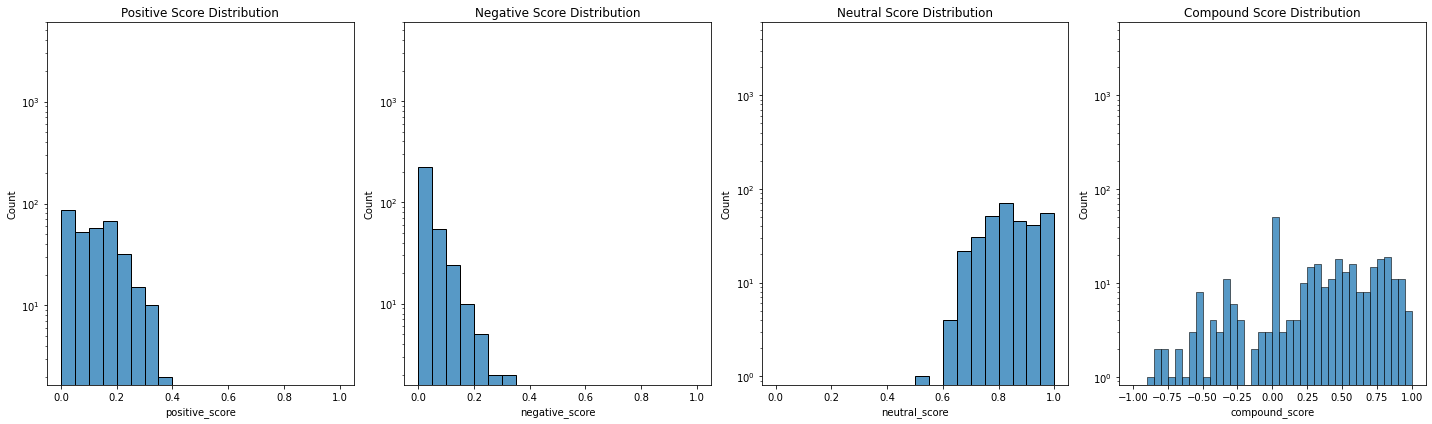

In [176]:
# 2019

# Check score statistics
stats_2019 = score_stats(df_sentiment_2019)

# Check score distributions
score_plot(df_sentiment_2019)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.043910,0.059032,0.0000,0.0000,0.0000,0.0890,0.2770,18,26.87
Neutral,0.869209,0.093439,0.6500,0.8085,0.8820,0.9265,1.0000,16,23.88
Positive,0.086896,0.082388,0.0000,0.0000,0.0700,0.1485,0.2830,33,49.25
Compound,0.143284,0.446611,-0.9403,-0.0772,0.0258,0.4939,0.9186,67,100.00


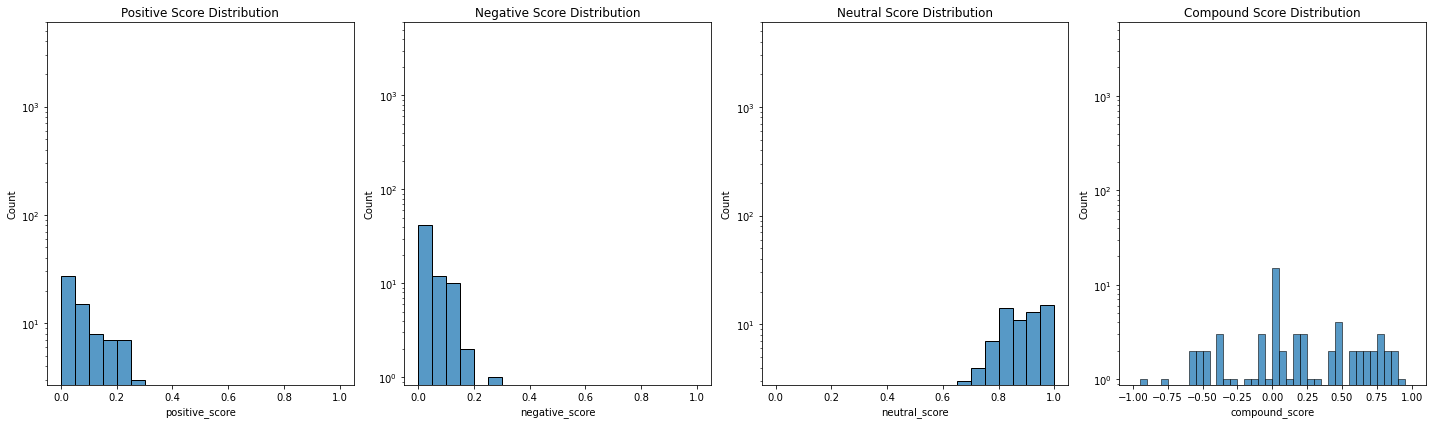

In [177]:
# 2020

# Check score statistics
stats_2020 = score_stats(df_sentiment_2020)

# Check score distributions
score_plot(df_sentiment_2020)

In [178]:
# Merge stats to list
stats_list = [stats_2015, stats_2016, stats_2017, stats_event,
              stats_2018, stats_2019, stats_2020]

stats_p = stats_merge(stats_list, 'Positive')
stats_neg = stats_merge(stats_list, 'Negative')
stats_neu = stats_merge(stats_list, 'Neutral')
stats_comp = stats_merge(stats_list, 'Compound')

In [179]:
# Define function to collect stats of different occupations
def stats_concat(stats_p, stats_neg, stats_neu, stats_comp, occupation):
    stats_p['score'] = 'positive'
    stats_neg['score'] = 'negative'
    stats_neu['score'] = 'neutral'
    stats_comp['score'] = 'compound'

    stats_concat = pd.concat([stats_p, stats_neg, stats_neu, stats_comp], axis=0)
    stats_concat['occupation'] = occupation
    
    return stats_concat


# Collect stats for comparison study
stats_business_score = stats_concat(stats_p, stats_neg, stats_neu, stats_comp, "businessperson")

### Politician

In [180]:
# Calculate sentiment scores and add them to dataframe
df_politician_sentiment = sentiment_analysis(df_politician_sentiment, 'quotation')

df_politician_sentiment.head()

,year,date,quotation,qids,nonstop_word,month,year_month,occupation,compound_score,positive_score,neutral_score,negative_score
4,2015,2015-06-22,if each bitcoin has a history and people know ...,Q46997142,"[bitcoin, history, people, know, maybe, people...",6,2015-06,politician,-0.0572,0.000,0.940,0.060
50,2015,2015-06-23,"and most of all, [ it has confused ] our messa...",Q46997142,"[confuse, message, public, bitcoin, ability, s...",6,2015-06,politician,0.3400,0.162,0.759,0.079
51,2015,2015-01-05,it kills any chance that bitcoin could be a ma...,Q5239364,"[kill, chance, bitcoin, mainstream, currency, ...",1,2015-01,politician,-0.8360,0.115,0.663,0.222
52,2015,2015-02-10,"bitcoin is built with clay feet,",Q47451365,"[bitcoin, build, clay, foot]",2,2015-02,politician,0.0000,0.000,1.000,0.000
59,2015,2015-03-18,i want to do my btcc seat justice,Q20714062,"[want, btcc, seat, justice]",3,2015-03,politician,0.5719,0.439,0.561,0.000


### General Analysis

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.053333,0.082178,0.000,0.0000,0.0000,0.0840,0.549,349,24.25
Neutral,0.847116,0.119229,0.292,0.7735,0.8560,0.9340,1.000,314,21.82
Positive,0.099552,0.101228,0.000,0.0000,0.0870,0.1555,0.615,776,53.93
Compound,0.179025,0.456381,-0.964,0.0000,0.1531,0.5574,0.990,1439,100.00


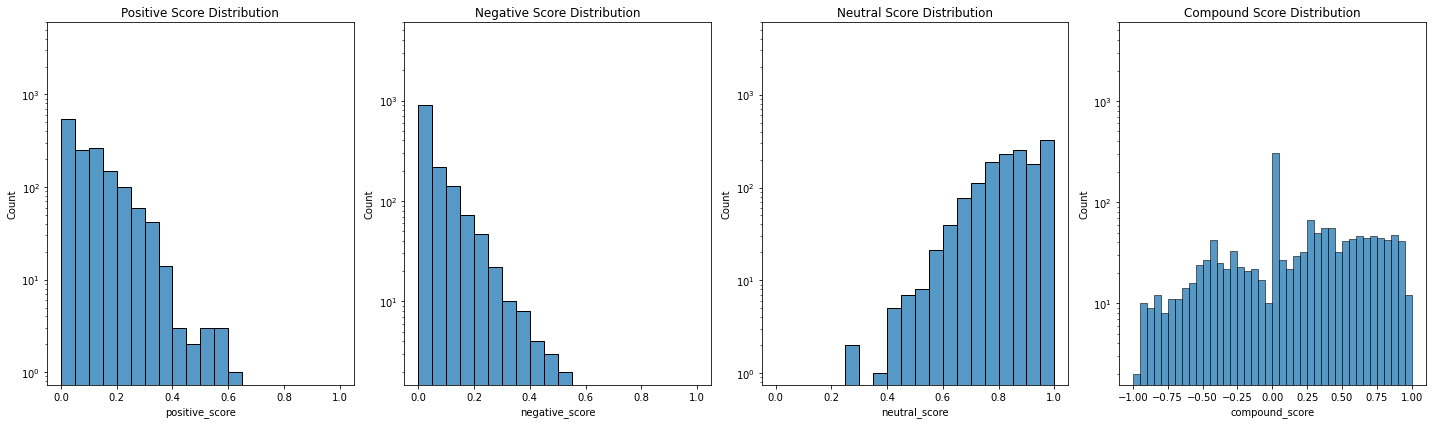

In [181]:
# Assign sentiment labels
df_politician_sentiment = assign_sentiment(df_politician_sentiment)

# Check score stats
stats_politician = score_stats(df_politician_sentiment)

# Check score distributions
score_plot(df_politician_sentiment)

### Sentiment Analysis over time

In [182]:
# Separate quotations by year & month
df_sentiment_2015 = df_politician_sentiment[df_politician_sentiment.year == 2015]
df_sentiment_2016 = df_politician_sentiment[df_politician_sentiment.year == 2016]
df_sentiment_2017 = df_politician_sentiment[(df_politician_sentiment.year == 2017) & (df_politician_sentiment.month <= 9)]
df_sentiment_2018 = df_politician_sentiment[(df_politician_sentiment.year == 2018) & (df_politician_sentiment.month >= 4)]
df_sentiment_2019 = df_politician_sentiment[df_politician_sentiment.year == 2019]
df_sentiment_2020 = df_politician_sentiment[df_politician_sentiment.year == 2020]

event_period = ["2017-10", "2017-11", "2017-12", "2018-01", "2018-02", "2018-03"]
df_sentiment_event = df_politician_sentiment[df_politician_sentiment.year_month.isin(event_period)]

df_sentiment_list = [df_sentiment_2015, df_sentiment_2016, df_sentiment_2017, df_sentiment_event, df_sentiment_2018,
                              df_sentiment_2019, df_sentiment_2020]

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.048465,0.079090,0.0000,0.00,0.0000,0.0790,0.3760,26,20.16
Neutral,0.840054,0.121875,0.5500,0.76,0.8340,0.9470,1.0000,31,24.03
Positive,0.111488,0.106895,0.0000,0.00,0.0940,0.1750,0.4390,72,55.81
Compound,0.215309,0.460025,-0.9438,0.00,0.2333,0.6124,0.9743,129,100.00


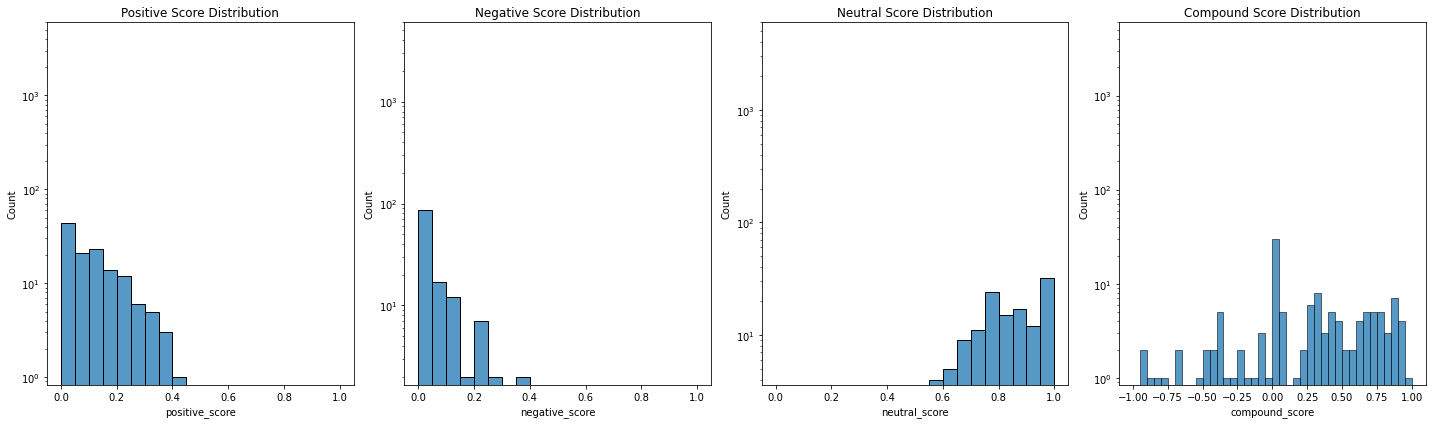

In [183]:
# 2015

# Check score statistics
stats_2015 = score_stats(df_sentiment_2015)

# Check score distributions
score_plot(df_sentiment_2015)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.051779,0.079071,0.0000,0.00000,0.0000,0.08300,0.520,29,21.32
Neutral,0.838434,0.127403,0.4550,0.77725,0.8570,0.92450,1.000,27,19.85
Positive,0.109794,0.106715,0.0000,0.00000,0.0935,0.16725,0.545,80,58.82
Compound,0.231061,0.431584,-0.7579,0.00000,0.2500,0.57390,0.990,136,100.00


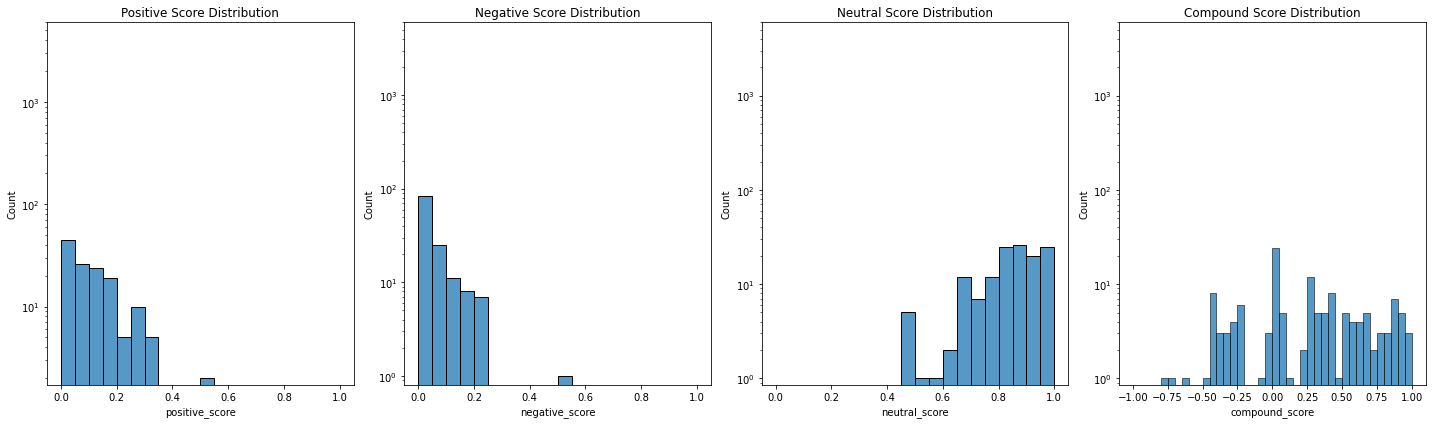

In [184]:
# 2016

# Check score statistics
stats_2016 = score_stats(df_sentiment_2016)

# Check score distributions
score_plot(df_sentiment_2016)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.054336,0.083965,0.0000,0.00000,0.0000,0.0820,0.3910,38,25.00
Neutral,0.843053,0.118465,0.4270,0.76775,0.8505,0.9225,1.0000,27,17.76
Positive,0.102605,0.103662,0.0000,0.00000,0.0945,0.1500,0.5730,87,57.24
Compound,0.178730,0.461023,-0.9371,-0.01290,0.1857,0.6162,0.9371,152,100.00


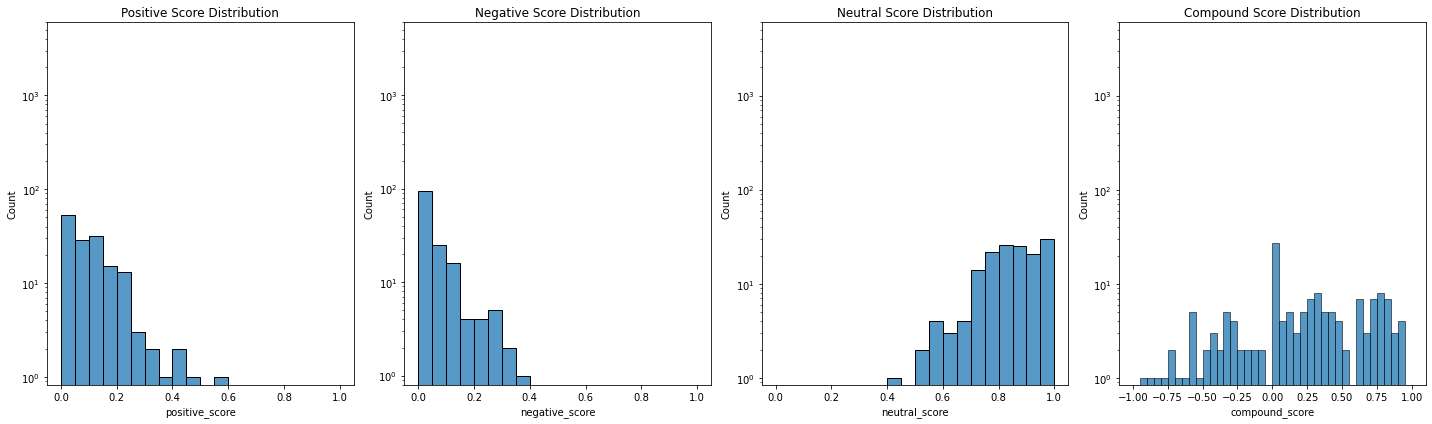

In [185]:
# 2017.01 - 2017.08

# Check score statistics
stats_2017 = score_stats(df_sentiment_2017)

# Check score distributions
score_plot(df_sentiment_2017)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.049173,0.074592,0.0000,0.0000,0.0000,0.0810,0.4070,100,22.78
Neutral,0.858308,0.114690,0.3850,0.7875,0.8590,0.9560,1.0000,113,25.74
Positive,0.092531,0.098612,0.0000,0.0000,0.0790,0.1485,0.6150,226,51.48
Compound,0.171429,0.420924,-0.9119,0.0000,0.1027,0.5192,0.9421,439,100.00


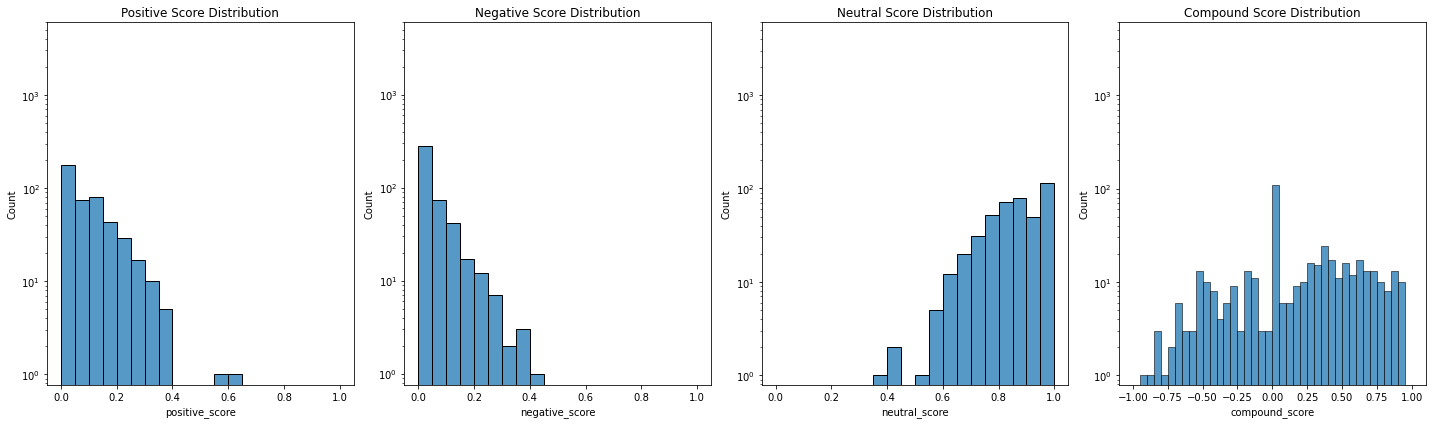

In [186]:
# 2017.09 - 2018.03 (Event Period)

# Check score statistics
stats_event = score_stats(df_sentiment_event)

# Check score distributions
score_plot(df_sentiment_event)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.057669,0.089183,0.000,0.0000,0.0000,0.0860,0.5490,87,28.52
Neutral,0.849485,0.116725,0.451,0.7710,0.8640,0.9310,1.0000,62,20.33
Positive,0.092833,0.099225,0.000,0.0000,0.0760,0.1440,0.4710,156,51.15
Compound,0.135403,0.481271,-0.964,-0.1531,0.1027,0.5267,0.9716,305,100.00


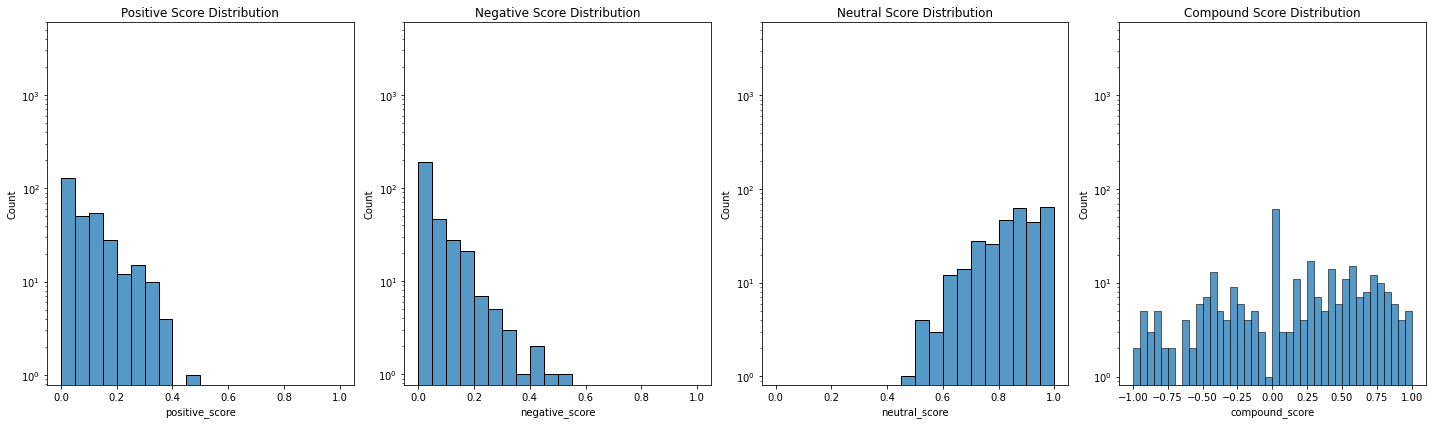

In [187]:
# 2018.04 - 2018.12

# Check score statistics
stats_2018 = score_stats(df_sentiment_2018)

# Check score distributions
score_plot(df_sentiment_2018)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.059502,0.090325,0.0000,0.0000,0.0000,0.1000,0.4960,57,25.79
Neutral,0.834063,0.123916,0.2920,0.7690,0.8400,0.9210,1.0000,39,17.65
Positive,0.106443,0.096880,0.0000,0.0000,0.0970,0.1650,0.5310,125,56.56
Compound,0.203362,0.480382,-0.9001,-0.0572,0.2023,0.6124,0.9674,221,100.00


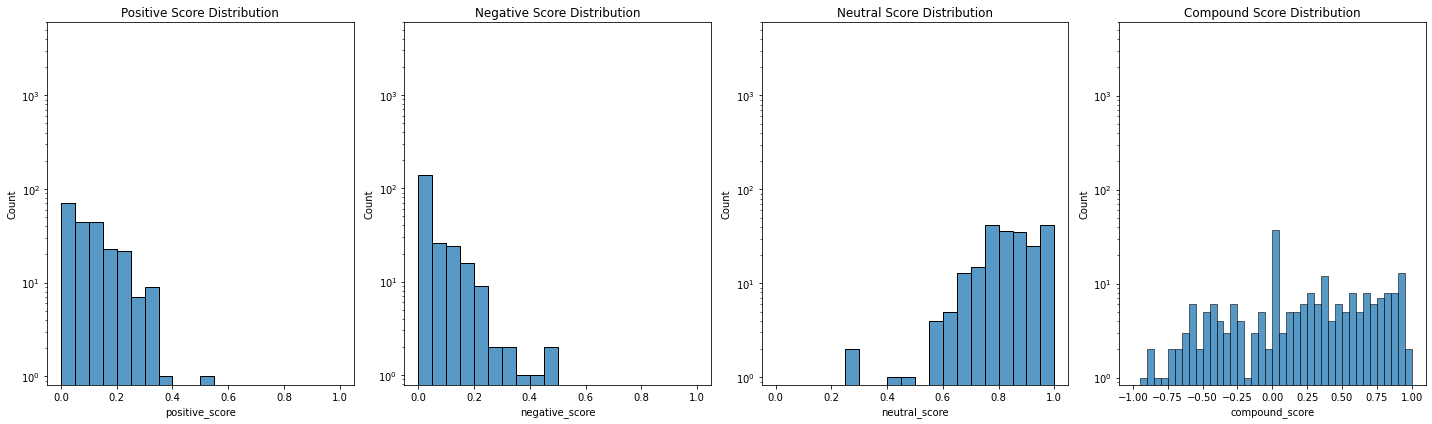

In [188]:
# 2019

# Check score statistics
stats_2019 = score_stats(df_sentiment_2019)

# Check score distributions
score_plot(df_sentiment_2019)

,mean,std,min,25%,50%,75%,max,count,%
Negative,0.050298,0.076326,0.0000,0.000,0.000,0.0980,0.3220,12,21.05
Neutral,0.846386,0.122121,0.4490,0.763,0.837,1.0000,1.0000,15,26.32
Positive,0.103281,0.112966,0.0000,0.000,0.088,0.1670,0.5510,30,52.63
Compound,0.171095,0.519642,-0.8923,0.000,0.120,0.6486,0.9689,57,100.00


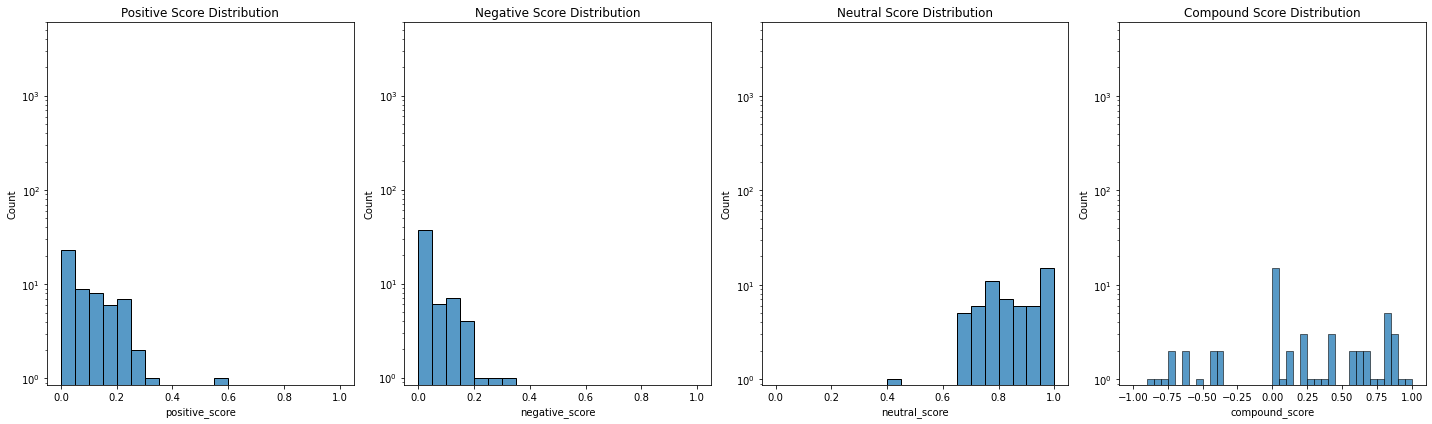

In [189]:
# 2020

# Check score statistics
stats_2020 = score_stats(df_sentiment_2020)

# Check score distributions
score_plot(df_sentiment_2020)

In [190]:
# Merge stats to list
stats_list = [stats_2015, stats_2016, stats_2017, stats_event,
              stats_2018, stats_2019, stats_2020]

stats_p = stats_merge(stats_list, 'Positive')
stats_neg = stats_merge(stats_list, 'Negative')
stats_neu = stats_merge(stats_list, 'Neutral')
stats_comp = stats_merge(stats_list, 'Compound')

In [191]:
# Collect stats
stats_politician_score = stats_concat(stats_p, stats_neg, stats_neu, stats_comp, "politician")

### **Comparison Study**

In [193]:
# General Info Comparison
print("Bussiness Person Stats: \n")
display(stats_business)

print("Politician Stats: \n")
display(stats_politician)

Bussiness Person Stats: 



,mean,std,min,25%,50%,75%,max,count,%
Negative,0.042699,0.068119,0.0000,0.00000,0.0000,0.070000,0.451,404,20.22
Neutral,0.848166,0.107227,0.1870,0.77825,0.8510,0.925000,1.000,349,17.47
Positive,0.109138,0.097939,0.0000,0.00000,0.0970,0.170750,0.813,1245,62.31
Compound,0.253480,0.459274,-0.9531,0.00000,0.3182,0.636375,0.994,1998,100.00


Politician Stats: 



,mean,std,min,25%,50%,75%,max,count,%
Negative,0.053333,0.082178,0.000,0.0000,0.0000,0.0840,0.549,349,24.25
Neutral,0.847116,0.119229,0.292,0.7735,0.8560,0.9340,1.000,314,21.82
Positive,0.099552,0.101228,0.000,0.0000,0.0870,0.1555,0.615,776,53.93
Compound,0.179025,0.456381,-0.964,0.0000,0.1531,0.5574,0.990,1439,100.00


Check the above sentiment score stats, combined with the general sentiment score distribution plots showed in independent analysis, we can clearly see the following:
* Businessperson speakers tend to have **more positive** words towards crypto-related topics. The compound score distribution of businessperson is more right-skewed and it has a larger mean and 50%, 75% percentile values. Besides, the proportion of positive quotations of businessperson is significantly higher than those of politician by **8.34%**. Also, the proportion of negative quotations of businessperson is lower than politicians by **3.81%**.
* Politician speakers' quotations are less polarized than bussinessperson as shown by neutral quotation proportion. However, we can see that extreme polarized quotation (neutral score < 0.2) exists in businessperson. Similarly, max negative score quotation exists in businessperson. We will check how this quotation look like.

In [194]:
# Check extreme polarized quotations of businessperson
display(df_business_sentiment.nsmallest(10, 'neutral_score')[['quotation', 'neutral_score', 'positive_score', 'negative_score', 'compound_score']])

# Examples
print('Example: ' + df_business_sentiment.loc[16159].quotation, '\n')
print('Example: ' + df_business_sentiment.loc[10795].quotation, '\n')

,quotation,neutral_score,positive_score,negative_score,compound_score
6827,"bitcoin enthusiasts are pretty loyal,",0.187,0.813,0.000,0.8271
15855,"bitcoin makes no revenue, no profitability.",0.337,0.212,0.451,-0.2792
12945,i am certain amazon will accept bitcoin.,0.385,0.615,0.000,0.6597
1545,"i love the blockchain, i hate bitcoin,",0.388,0.326,0.287,0.1280
18200,bitcoin is the greatest scam in history.,0.388,0.326,0.287,0.1280
11468,"i am certain that amazon will accept bitcoin,",0.439,0.561,0.000,0.6597
16159,bitcoin's true significance lies in its potent...,0.469,0.385,0.146,0.5574
10795,"as bitcoin increases in value, it's a great st...",0.473,0.527,0.000,0.8360
519,barclays is enabling the bitcoin exchange to h...,0.485,0.515,0.000,0.8176
15454,increased public interest in bitcoin and other...,0.517,0.332,0.151,0.4939


Example: bitcoin's true significance lies in its potential as a global digital asset register 

Example: as bitcoin increases in value, it's a great store of value, 



In [195]:
# Check extreme polarized quotations of politician
display(df_politician_sentiment.nsmallest(10, 'neutral_score')[['quotation', 'neutral_score', 'positive_score', 'negative_score', 'compound_score']])

# Examples
print('Example: ' + df_politician_sentiment.loc[25301].quotation, '\n')
print('Example: ' + df_politician_sentiment.loc[19269].quotation, '\n')

,quotation,neutral_score,positive_score,negative_score,compound_score
21828,"2019 good, bad and ugly of cryptos",0.292,0.212,0.496,-0.5994
22631,"2019's good, bad and ugly of cryptos,",0.292,0.212,0.496,-0.5994
12945,i am certain amazon will accept bitcoin.,0.385,0.615,0.000,0.6597
16903,"get rich on bitcoin, or die tryin.",0.400,0.288,0.312,-0.0772
25034,"risk appetite is positive for bitcoin,",0.412,0.371,0.216,0.3612
5785,bitcoin has strong economic incentives to prev...,0.427,0.573,0.000,0.6908
11468,"i am certain that amazon will accept bitcoin,",0.439,0.561,0.000,0.6597
25301,"similar to gold, positive fundamentals should ...",0.449,0.551,0.000,0.8225
19269,effects were negative and incredibly damaging ...,0.451,0.000,0.549,-0.8070
3158,be honored to join the bitcoin revolution.,0.455,0.545,0.000,0.7184


Example: similar to gold, positive fundamentals should extend bitcoin's price appreciation, 

Example: effects were negative and incredibly damaging to bitcoin 



In [196]:
# Check extreme positive quotations of businessperson
display(df_business_sentiment.nlargest(10, 'positive_score')[['quotation', 'positive_score', 'neutral_score', 'negative_score', 'compound_score']])

# Examples
print('Example: ' + df_business_sentiment.loc[519].quotation, '\n')
print('Example: ' + df_business_sentiment.loc[5132].quotation, '\n')

,quotation,positive_score,neutral_score,negative_score,compound_score
6827,"bitcoin enthusiasts are pretty loyal,",0.813,0.187,0.0,0.8271
12945,i am certain amazon will accept bitcoin.,0.615,0.385,0.0,0.6597
11468,"i am certain that amazon will accept bitcoin,",0.561,0.439,0.0,0.6597
10795,"as bitcoin increases in value, it's a great st...",0.527,0.473,0.0,0.8360
519,barclays is enabling the bitcoin exchange to h...,0.515,0.485,0.0,0.8176
10550,"rest in peace bitcoin unlimited,",0.467,0.533,0.0,0.5423
5713,"then it's going to not compare to something, l...",0.465,0.535,0.0,0.8271
11389,we are thrilled to be partnering with the lite...,0.446,0.554,0.0,0.9337
5132,"as much as i love bitcoin, an asset that goes ...",0.440,0.560,0.0,0.8481
8944,futures have definitely opened bitcoin up to s...,0.431,0.569,0.0,0.6486


Example: barclays is enabling the bitcoin exchange to help charities accept bitcoin. 

Example: as much as i love bitcoin, an asset that goes straight up, investors have to be careful, 



In [197]:
# Check extreme positive quotations of politician
display(df_politician_sentiment.nlargest(10, 'positive_score')[['quotation', 'positive_score', 'neutral_score', 'negative_score', 'compound_score']])

# Examples
print('Example: ' + df_politician_sentiment.loc[23664].quotation, '\n')
print('Example: ' + df_politician_sentiment.loc[2451].quotation, '\n')

,quotation,positive_score,neutral_score,negative_score,compound_score
12945,i am certain amazon will accept bitcoin.,0.615,0.385,0.0,0.6597
5785,bitcoin has strong economic incentives to prev...,0.573,0.427,0.0,0.6908
11468,"i am certain that amazon will accept bitcoin,",0.561,0.439,0.0,0.6597
25301,"similar to gold, positive fundamentals should ...",0.551,0.449,0.0,0.8225
3158,be honored to join the bitcoin revolution.,0.545,0.455,0.0,0.7184
23664,"givebitcoin gives them an easy, safe way to br...",0.531,0.469,0.0,0.9524
2451,"like many others, we're excited for the prospe...",0.504,0.496,0.0,0.7269
8329,"we are delighted to welcome dennis to the btcc,",0.474,0.526,0.0,0.7430
14820,"btc is a safe, well-managed and family-oriente...",0.471,0.529,0.0,0.8689
59,i want to do my btcc seat justice,0.439,0.561,0.0,0.5719


Example: givebitcoin gives them an easy, safe way to bring friends and family into the fold. it's the perfect gift for the holidays. 

Example: like many others, we're excited for the prospects of ethereum, 



In [198]:
# Check extreme negative quotations of businessperson
display(df_business_sentiment.nlargest(10, 'negative_score')[['quotation', 'negative_score', 'positive_score', 'neutral_score', 'compound_score']])

# Examples
print('Example: ' + df_business_sentiment.loc[6755].quotation, '\n')
print('Example: ' + df_business_sentiment.loc[15532].quotation, '\n')

,quotation,negative_score,positive_score,neutral_score,compound_score
15855,"bitcoin makes no revenue, no profitability.",0.451,0.212,0.337,-0.2792
6755,crazy that so many retailers don't accept bitc...,0.433,0.000,0.567,-0.5550
16012,"bitcoin cash has been left for dead,",0.417,0.000,0.583,-0.6486
15532,it's not that bitcoin's a scam but its nature ...,0.407,0.000,0.593,-0.8201
20540,the setup or institutional arrangement around ...,0.403,0.000,0.597,-0.9531
16845,most heavy users of bitcoin are criminals.,0.381,0.000,0.619,-0.5719
17192,the setup or institutional arrangement around ...,0.380,0.000,0.620,-0.9360
18096,his main concern is that bad people can't use ...,0.368,0.000,0.632,-0.7906
18410,"and because of a stupid mistake, they lost bit...",0.368,0.086,0.545,-0.7351
14245,"bitcoin is a fad, or a scam, or a ponzi scheme...",0.364,0.102,0.535,-0.7096


Example: crazy that so many retailers don't accept bitcoin. 

Example: it's not that bitcoin's a scam but its nature allows scams to occur, 



In [199]:
# Check extreme negative quotations of politician
display(df_politician_sentiment.nlargest(10, 'negative_score')[['quotation', 'negative_score', 'positive_score', 'neutral_score', 'compound_score']])

# Examples
print('Example: ' + df_politician_sentiment.loc[14850].quotation, '\n')
print('Example: ' + df_politician_sentiment.loc[20104].quotation, '\n')

,quotation,negative_score,positive_score,neutral_score,compound_score
19269,effects were negative and incredibly damaging ...,0.549,0.000,0.451,-0.8070
2529,dispel any negative myths and fears about bitc...,0.520,0.000,0.480,-0.7579
21828,"2019 good, bad and ugly of cryptos",0.496,0.212,0.292,-0.5994
22631,"2019's good, bad and ugly of cryptos,",0.496,0.212,0.292,-0.5994
14850,"unfortunately [... ], bitcoin has failed miser...",0.494,0.000,0.506,-0.8316
20104,"do not ask when we stop the hash war, it is wh...",0.428,0.000,0.572,-0.9403
3799,and then... bitcoin responds by making the pro...,0.407,0.000,0.593,-0.6697
20540,the setup or institutional arrangement around ...,0.403,0.000,0.597,-0.9531
23120,"gold always tries to fight the fed, and someti...",0.400,0.000,0.600,-0.9001
4227,inhibiting a covert attack on the bitcoin pow ...,0.391,0.000,0.609,-0.5423


Example: unfortunately [... ], bitcoin has failed miserably as a method of payment 

Example: do not ask when we stop the hash war, it is when will be stop defending bitcoin against dishonest miners and attackers. the answer is never. 



By checking the above extreme examples, we can find some difference of focus points on extreme quotations between businesspersons and politicians. Businessperson focuses more on its **commodity attribute**, often strongly comments on its **price, trade, and asset values**; whereas politicians focuses more on its **social attribute**, often strongly comments on its **social impact, security, and transaction issues**.

Now we continue our time period comparison analysis:

In [200]:
# Merge two collected stats
stats_combined = pd.concat([stats_business_score, stats_politician_score], axis=0)

stats_combined

,mean,std,min,25%,50%,75%,max,count,%,score,occupation
2015.01-2015.12,0.131715,0.097613,0.0000,0.0510,0.1350,0.19500,0.5150,175,74.47,positive,businessperson
2016.01-2016.12,0.105242,0.082910,0.0000,0.0400,0.0965,0.14975,0.3660,79,65.83,positive,businessperson
2017.01-2017.09,0.099362,0.092850,0.0000,0.0000,0.0875,0.15700,0.4670,173,59.66,positive,businessperson
2017.10-2018.03,0.107024,0.107973,0.0000,0.0000,0.0870,0.16525,0.8130,291,58.20,positive,businessperson
2018.04-2018.12,0.103418,0.096636,0.0000,0.0000,0.0910,0.16225,0.4460,280,60.34,positive,businessperson
...,...,...,...,...,...,...,...,...,...,...,...
2017.01-2017.09,0.178730,0.461023,-0.9371,-0.0129,0.1857,0.61620,0.9371,152,100.00,compound,politician
2017.10-2018.03,0.171429,0.420924,-0.9119,0.0000,0.1027,0.51920,0.9421,439,100.00,compound,politician
2018.04-2018.12,0.135403,0.481271,-0.9640,-0.1531,0.1027,0.52670,0.9716,305,100.00,compound,politician
2019.01-2019.12,0.203362,0.480382,-0.9001,-0.0572,0.2023,0.61240,0.9674,221,100.00,compound,politician


In [201]:
# Define function to plot time-period stats
def plot_stats(stats_combined, score_type):
    stats = stats_combined[stats_combined.score == score_type].drop(columns=['score'])
    
    # Display businessperson period stats
    display(stats[stats.occupation == 'businessperson'])
    # Display politician period stats
    display(stats[stats.occupation == 'politician'])
    
    # Line plots for each stats
    stats[stats.occupation == 'businessperson'].plot(kind='line', subplots=True, figsize=(10, 8), 
                                                                   title='Businessperson {} score stats'.format(score_type), grid=True,
                                                                   style='.-', ms=8)
    plt.tight_layout()

    # Line plots for each stats
    stats[stats.occupation == 'politician'].plot(kind='line', subplots=True, figsize=(10, 8), 
                                                                   title='Politician {} score stats'.format(score_type), grid=True,
                                                                   style='.-', ms=8)
    plt.tight_layout()


,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.131715,0.097613,0.0,0.05100,0.1350,0.19500,0.515,175,74.47,businessperson
2016.01-2016.12,0.105242,0.082910,0.0,0.04000,0.0965,0.14975,0.366,79,65.83,businessperson
2017.01-2017.09,0.099362,0.092850,0.0,0.00000,0.0875,0.15700,0.467,173,59.66,businessperson
2017.10-2018.03,0.107024,0.107973,0.0,0.00000,0.0870,0.16525,0.813,291,58.20,businessperson
2018.04-2018.12,0.103418,0.096636,0.0,0.00000,0.0910,0.16225,0.446,280,60.34,businessperson
2019.01-2019.12,0.119071,0.093317,0.0,0.02625,0.1205,0.18350,0.389,214,66.46,businessperson
2020.01-,0.086896,0.082388,0.0,0.00000,0.0700,0.14850,0.283,33,49.25,businessperson


,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.111488,0.106895,0.0,0.0,0.0940,0.17500,0.439,72,55.81,politician
2016.01-2016.12,0.109794,0.106715,0.0,0.0,0.0935,0.16725,0.545,80,58.82,politician
2017.01-2017.09,0.102605,0.103662,0.0,0.0,0.0945,0.15000,0.573,87,57.24,politician
2017.10-2018.03,0.092531,0.098612,0.0,0.0,0.0790,0.14850,0.615,226,51.48,politician
2018.04-2018.12,0.092833,0.099225,0.0,0.0,0.0760,0.14400,0.471,156,51.15,politician
2019.01-2019.12,0.106443,0.096880,0.0,0.0,0.0970,0.16500,0.531,125,56.56,politician
2020.01-,0.103281,0.112966,0.0,0.0,0.0880,0.16700,0.551,30,52.63,politician


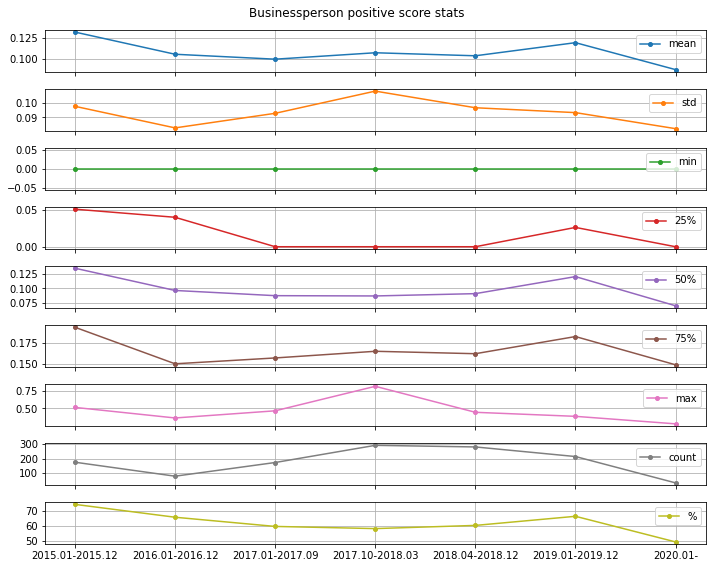

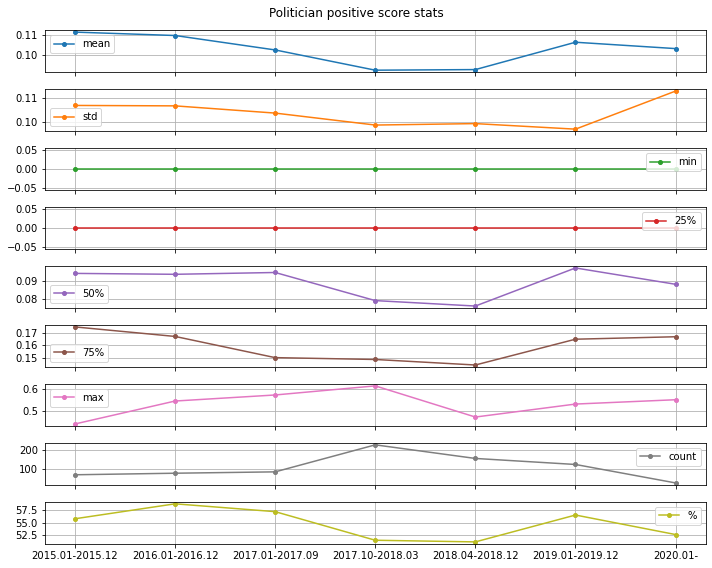

In [202]:
# Positive Score Stats & Lineplots
plot_stats(stats_combined, 'positive')

,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.034255,0.062198,0.0,0.0,0.0,0.05100,0.298,28,11.91,businessperson
2016.01-2016.12,0.047575,0.068910,0.0,0.0,0.0,0.07400,0.332,30,25.00,businessperson
2017.01-2017.09,0.041214,0.065142,0.0,0.0,0.0,0.06725,0.433,65,22.41,businessperson
2017.10-2018.03,0.041732,0.067795,0.0,0.0,0.0,0.07200,0.368,101,20.20,businessperson
2018.04-2018.12,0.050791,0.078448,0.0,0.0,0.0,0.07925,0.451,108,23.28,businessperson
2019.01-2019.12,0.037969,0.059553,0.0,0.0,0.0,0.06175,0.318,54,16.77,businessperson
2020.01-,0.043910,0.059032,0.0,0.0,0.0,0.08900,0.277,18,26.87,businessperson


,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.048465,0.079090,0.0,0.0,0.0,0.079,0.376,26,20.16,politician
2016.01-2016.12,0.051779,0.079071,0.0,0.0,0.0,0.083,0.520,29,21.32,politician
2017.01-2017.09,0.054336,0.083965,0.0,0.0,0.0,0.082,0.391,38,25.00,politician
2017.10-2018.03,0.049173,0.074592,0.0,0.0,0.0,0.081,0.407,100,22.78,politician
2018.04-2018.12,0.057669,0.089183,0.0,0.0,0.0,0.086,0.549,87,28.52,politician
2019.01-2019.12,0.059502,0.090325,0.0,0.0,0.0,0.100,0.496,57,25.79,politician
2020.01-,0.050298,0.076326,0.0,0.0,0.0,0.098,0.322,12,21.05,politician


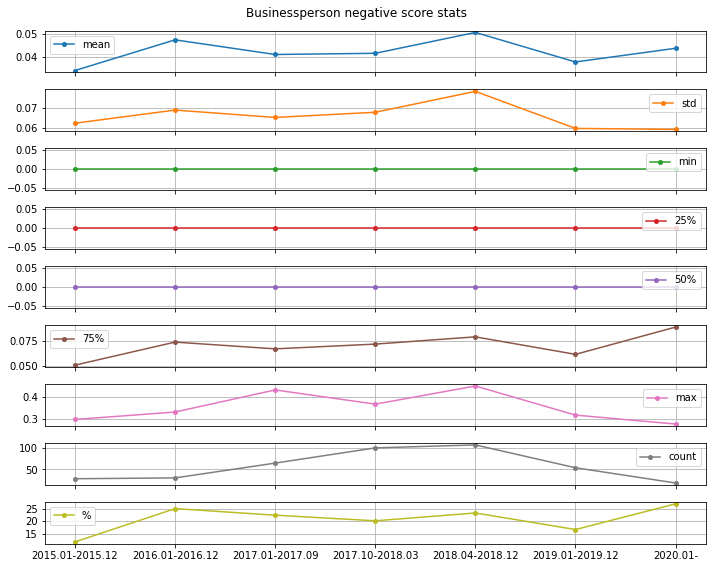

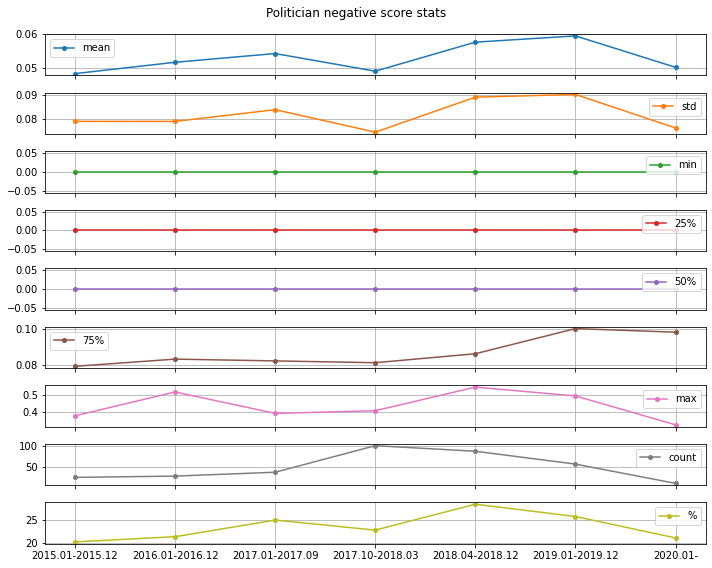

In [203]:
# Negative Score Stats & Lineplots
plot_stats(stats_combined, 'negative')

,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.834034,0.105994,0.388,0.76400,0.8300,0.90600,1.0,32,13.62,businessperson
2016.01-2016.12,0.847183,0.089252,0.585,0.79850,0.8545,0.90450,1.0,11,9.17,businessperson
2017.01-2017.09,0.859400,0.101251,0.533,0.79125,0.8690,0.93375,1.0,52,17.93,businessperson
2017.10-2018.03,0.851234,0.116874,0.187,0.78375,0.8605,0.93725,1.0,108,21.60,businessperson
2018.04-2018.12,0.845832,0.111079,0.337,0.77600,0.8495,0.92500,1.0,76,16.38,businessperson
2019.01-2019.12,0.842950,0.099635,0.529,0.77600,0.8385,0.91275,1.0,54,16.77,businessperson
2020.01-,0.869209,0.093439,0.650,0.80850,0.8820,0.92650,1.0,16,23.88,businessperson


,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.840054,0.121875,0.550,0.76000,0.8340,0.9470,1.0,31,24.03,politician
2016.01-2016.12,0.838434,0.127403,0.455,0.77725,0.8570,0.9245,1.0,27,19.85,politician
2017.01-2017.09,0.843053,0.118465,0.427,0.76775,0.8505,0.9225,1.0,27,17.76,politician
2017.10-2018.03,0.858308,0.114690,0.385,0.78750,0.8590,0.9560,1.0,113,25.74,politician
2018.04-2018.12,0.849485,0.116725,0.451,0.77100,0.8640,0.9310,1.0,62,20.33,politician
2019.01-2019.12,0.834063,0.123916,0.292,0.76900,0.8400,0.9210,1.0,39,17.65,politician
2020.01-,0.846386,0.122121,0.449,0.76300,0.8370,1.0000,1.0,15,26.32,politician


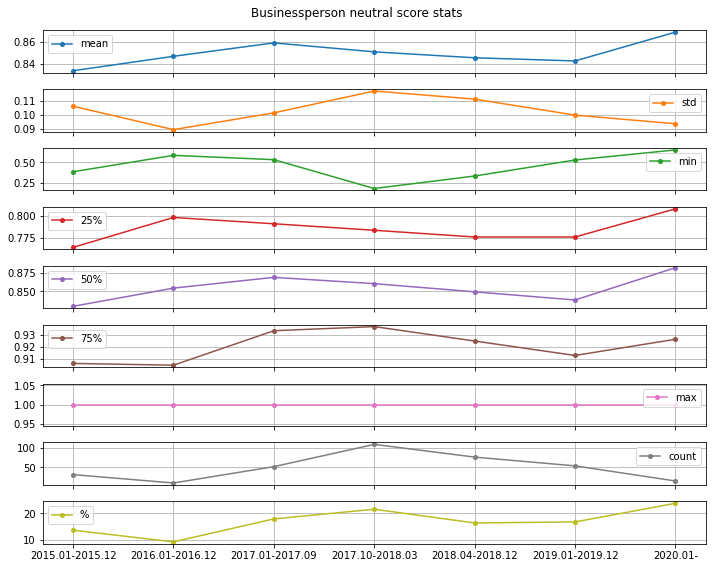

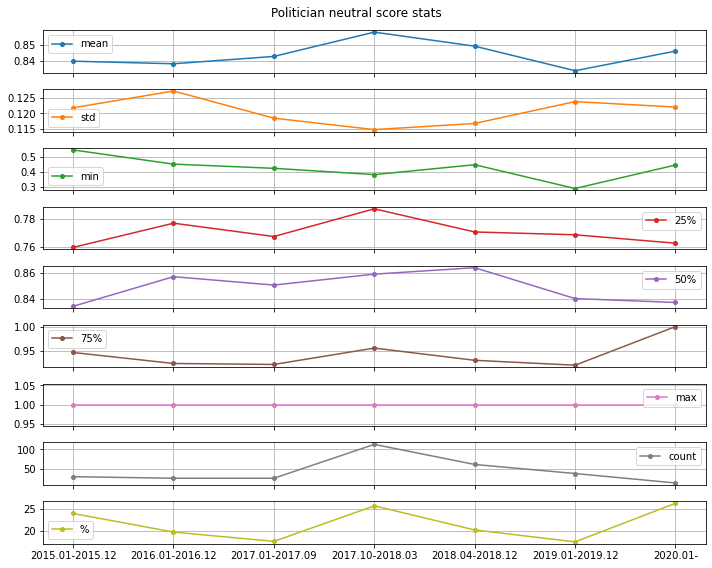

In [204]:
# Neutral Score Stats & Lineplots
plot_stats(stats_combined, 'neutral')

,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.389206,0.443189,-0.9129,0.0000,0.4215,0.790250,0.9773,235,100.0,businessperson
2016.01-2016.12,0.225132,0.457523,-0.8225,-0.0193,0.3400,0.598650,0.9783,120,100.0,businessperson
2017.01-2017.09,0.218923,0.466028,-0.8271,0.0000,0.2263,0.591000,0.9818,290,100.0,businessperson
2017.10-2018.03,0.228833,0.436342,-0.9048,0.0000,0.2263,0.585900,0.9940,500,100.0,businessperson
2018.04-2018.12,0.220489,0.487855,-0.9531,0.0000,0.2732,0.627675,0.9704,464,100.0,businessperson
2019.01-2019.12,0.304849,0.439433,-0.8834,0.0000,0.3612,0.670500,0.9758,322,100.0,businessperson
2020.01-,0.143284,0.446611,-0.9403,-0.0772,0.0258,0.493900,0.9186,67,100.0,businessperson


,mean,std,min,25%,50%,75%,max,count,%,occupation
2015.01-2015.12,0.215309,0.460025,-0.9438,0.0000,0.2333,0.6124,0.9743,129,100.0,politician
2016.01-2016.12,0.231061,0.431584,-0.7579,0.0000,0.2500,0.5739,0.9900,136,100.0,politician
2017.01-2017.09,0.178730,0.461023,-0.9371,-0.0129,0.1857,0.6162,0.9371,152,100.0,politician
2017.10-2018.03,0.171429,0.420924,-0.9119,0.0000,0.1027,0.5192,0.9421,439,100.0,politician
2018.04-2018.12,0.135403,0.481271,-0.9640,-0.1531,0.1027,0.5267,0.9716,305,100.0,politician
2019.01-2019.12,0.203362,0.480382,-0.9001,-0.0572,0.2023,0.6124,0.9674,221,100.0,politician
2020.01-,0.171095,0.519642,-0.8923,0.0000,0.1200,0.6486,0.9689,57,100.0,politician


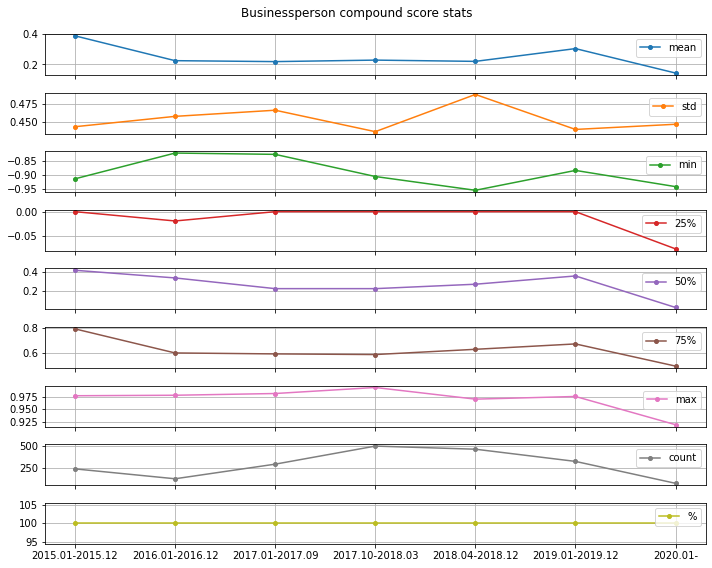

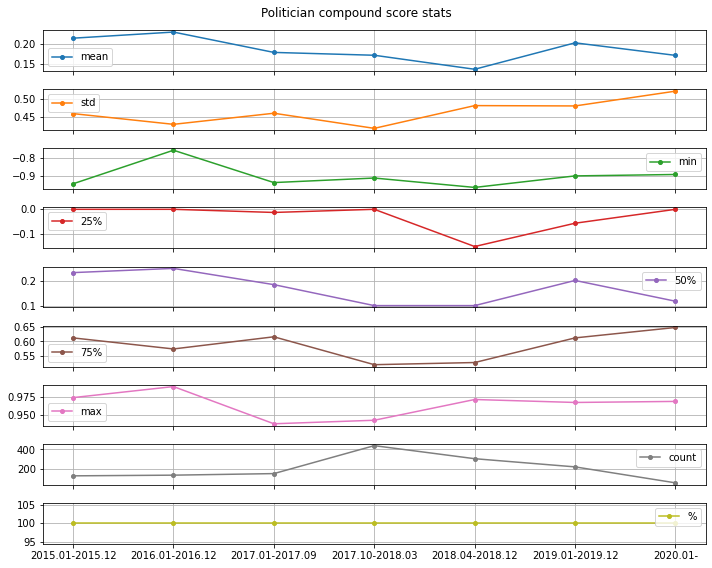

In [205]:
# Compound Score Stats & Lineplots
plot_stats(stats_combined, 'compound')

From the time period stats and plots, we can make clear of the following:
1. Although there exists flucutations, the compound sentiment score from both occupations generally dropped. 
2. The sudden drop of compound score in 2020 of businessperson mainly refers to speaker's attitude shift from positive to neutral. 
3. The sudden drop of compound score in 2018 of businessperson mainly refers to speaker's attitude shift from positive to negative.

### Combinatorial Analysis with Bitcoin Price

Bitcoin price record is extracted from https://coinmarketcap.com/currencies/bitcoin/

We will use the close value as well as its change over time from the dataset in the combinatorial analysis since the close value fluctuation clearly reflects the market popularity and investor's confidence in Bitcoin.

In [206]:
df_btc = pd.read_csv("./data/bitcoin_price.csv", sep=',',
                    error_bad_lines = False, header = 0)             
df_btc.tail()

,Date,Close,Open,High,Low,Volume
1972,2014/12/6,374.79,376.76,378.45,370.95,7009320.0
1973,2014/12/5,376.85,369.44,379.19,365.76,15181800.0
1974,2014/12/4,369.60,375.72,378.65,367.76,14529600.0
1975,2014/12/3,375.01,381.72,383.03,374.35,13340100.0
1976,2014/12/2,381.32,379.25,384.04,377.86,12364100.0


In [207]:
# Convert the date type from object to datetime64[ns]
df_btc["Date"]  = pd.to_datetime(df_btc["Date"], format='%Y-%m-%d')
df_btc.head()

,Date,Close,Open,High,Low,Volume
0,2020-04-30,8658.55,8797.67,9440.65,8533.26,6.696463e+10
1,2020-04-29,8801.04,7806.71,8871.75,7786.05,6.020105e+10
2,2020-04-28,7807.06,7796.97,7814.53,7730.81,3.318796e+10
3,2020-04-27,7795.60,7679.42,7795.60,7679.42,3.616214e+10
4,2020-04-26,7679.87,7570.14,7700.59,7561.41,3.307015e+10


In [208]:
# Count number of quotations by day
df_quote_count = df_sentiment.groupby('date')['quotation'].count().to_frame()

# Compute a 14-day rolling average
df_quote_count['rolling_14_mean'] = df_quote_count['quotation'].rolling('14D').mean()
display(df_quote_count)

# Quotation count stats
df_quote_count[['quotation']].describe().transpose()

,quotation,rolling_14_mean
date,,
2015-01-01,3,3.000000
2015-01-02,2,2.500000
2015-01-03,1,2.000000
2015-01-04,1,1.750000
2015-01-05,16,4.600000
...,...,...
2020-04-12,5,6.214286
2020-04-13,5,6.071429
2020-04-14,6,6.357143


,count,mean,std,min,25%,50%,75%,max
quotation,1689.0,14.676732,15.78284,1.0,5.0,10.0,19.0,148.0


#### **Bitcoin Price and # Quotations**

Text(0.5, 1.0, 'Frequency of Crypto-related quotations from 2015 to 2020')

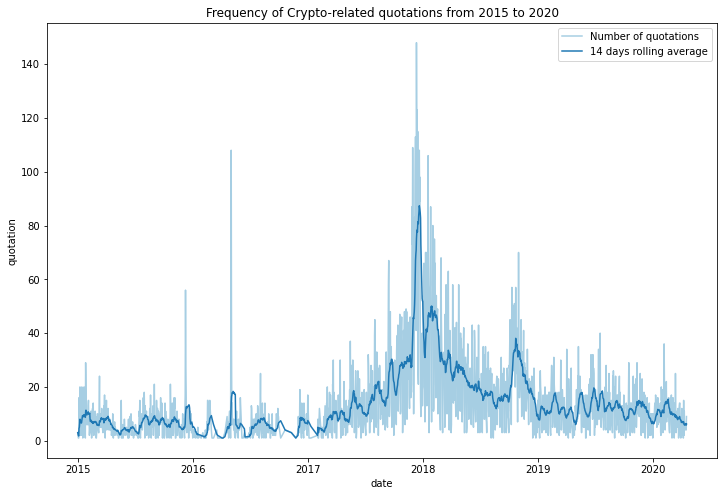

In [209]:
# Lineplot for 14 days rolling average
plt.figure(figsize=(12,8))
sns.set_palette("Paired")
sns.lineplot(data=df_quote_count, x= "date", y="quotation", label="Number of quotations")
sns.lineplot(data=df_quote_count, x= "date", y="rolling_14_mean", label="14 days rolling average")
plt.title("Frequency of Crypto-related quotations from 2015 to 2020")

In [210]:
# Check for missing date from quotations
df_btc_roll = df_btc[(df_btc['Date'] >= '2015-01-01') & (df_btc['Date'] <= '2020-04-16')]
df_btc_roll = df_btc_roll.set_index('Date')
missing_date = pd.date_range(start='2015-01-01', end='2020-04-16').difference(df_quote_count.index)

# To keep consistency, we will remove price records of missing dates
df_btc_roll = df_btc_roll.drop(missing_date)
df_btc_roll['rolling_14_close'] = df_btc_roll['Close'].rolling('14D').mean()
df_btc_roll.head()

,Close,Open,High,Low,Volume,rolling_14_close
Date,,,,,,
2020-04-16,7116.80,6640.45,7134.45,6555.50,4.678324e+10,7116.800000
2020-04-15,6642.11,6845.56,6928.66,6633.40,3.228831e+10,6879.455000
2020-04-14,6842.43,6843.28,6958.56,6793.82,3.411043e+10,6867.113333
2020-04-13,6845.04,6965.62,6965.62,6668.26,3.861931e+10,6861.595000
2020-04-12,6971.09,6858.07,7119.95,6811.08,3.575957e+10,6883.494000


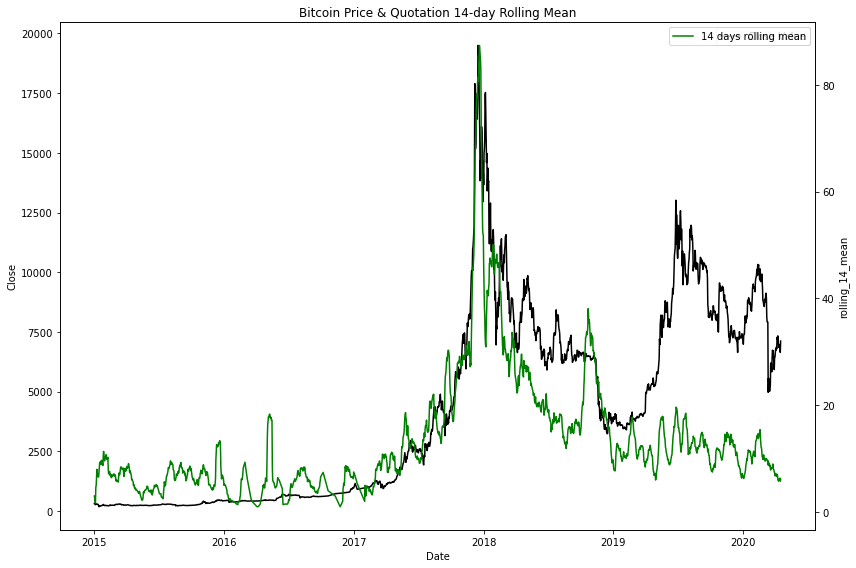

In [211]:
# Lineplot for bitcoin price & quotation 14-day rolling mean
fig, axes = plt.subplots(figsize=(12,8))
# sns.set_palette("Paired")
sns.lineplot(data=df_btc_roll, x="Date", y="Close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_mean", label="14 days rolling mean", color='green', ax=ax2)
plt.title("Bitcoin Price & Quotation 14-day Rolling Mean")
plt.tight_layout()

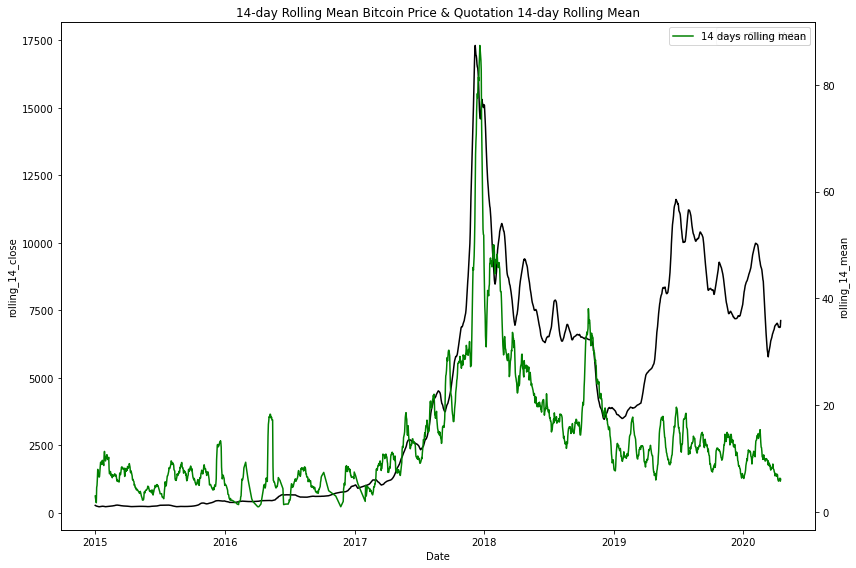

In [212]:
# Lineplot for 14-day rolling mean bitcoin price & quotation 14-day rolling mean
fig, axes = plt.subplots(figsize=(12,8))
# sns.set_palette("Paired")
sns.lineplot(data=df_btc_roll, x="Date", y="rolling_14_close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_mean", label="14 days rolling mean", color='green', ax=ax2)
plt.title("14-day Rolling Mean Bitcoin Price & Quotation 14-day Rolling Mean")
plt.tight_layout()

From the above lineplots, we would initially speculate that the number of quotations may correlates with the flucuation of Bitcoin price from 2017 to end of 2018. Now we will continue our analysis on whether we can find a correlation between bitcoin price and number of quotations (rolling 14 days) within a certain period, especially in the event period.

In [213]:
# General Testing
stats.pearsonr(df_btc_roll['Close'], df_quote_count['rolling_14_mean'])

(0.2396763414891196, 1.7075451065590552e-23)

The general testing result gives a p << 0.05, which means that Bitcoin price and 14-day rolling mean of # quotations does positively correlate with each other, with a small correlation r = 0.24. Based on this fact, we will find out the period which gives the largest correlation |r| with p << 0.05.

In [214]:
# Define function to carry out separational pearson tests
def separation_pearson(df_btc, df_quote_count, score_type):
    r_2015, p_2015 = stats.pearsonr(df_btc[(df_btc.index >= '2015-01-01') & (df_btc.index <= '2015-12-31')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2015-01-01') & (df_quote_count.index <= '2015-12-31')][score_type])
    print("2015: r = {a}, p = {b}".format(a=r_2015, b=p_2015), '\n')
    
    r_2016, p_2016 = stats.pearsonr(df_btc[(df_btc.index >= '2016-01-01') & (df_btc.index <= '2016-12-31')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2016-01-01') & (df_quote_count.index <= '2016-12-31')][score_type])
    print("2016: r = {a}, p = {b}".format(a=r_2016, b=p_2016), '\n')
    
    r_2017, p_2017 = stats.pearsonr(df_btc[(df_btc.index >= '2017-01-01') & (df_btc.index < '2017-09-01')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2017-01-01') & (df_quote_count.index < '2017-09-01')][score_type])
    print("2017: r = {a}, p = {b}".format(a=r_2017, b=p_2017), '\n')
    
    r_event, p_event = stats.pearsonr(df_btc[(df_btc.index >= '2017-09-01') & (df_btc.index < '2018-04-01')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2017-09-01') & (df_quote_count.index < '2018-04-01')][score_type])
    print("Event Period: r = {a}, p = {b}".format(a=r_event, b=p_event), '\n')
    
    r_2018, p_2018 = stats.pearsonr(df_btc[(df_btc.index >= '2018-04-01') & (df_btc.index <= '2018-12-31')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2018-04-01') & (df_quote_count.index <= '2018-12-31')][score_type])
    print("2018: r = {a}, p = {b}".format(a=r_2018, b=p_2018), '\n')
    
    r_2019, p_2019 = stats.pearsonr(df_btc[(df_btc.index >= '2019-01-01') & (df_btc.index <= '2019-12-31')]['Close'], 
                     df_quote_count[(df_quote_count.index >= '2019-01-01') & (df_quote_count.index <= '2019-12-31')][score_type])
    print("2019: r = {a}, p = {b}".format(a=r_2019, b=p_2019), '\n')
    
    r_2020, p_2020 = stats.pearsonr(df_btc[df_btc.index >= '2020-01-01']['Close'], 
                     df_quote_count[df_quote_count.index >= '2020-01-01'][score_type])
    print("2020: r = {a}, p = {b}".format(a=r_2020, b=p_2020), '\n')


In [215]:
# Separation Testing
separation_pearson(df_btc_roll, df_quote_count, 'rolling_14_mean')

2015: r = 0.060561091543000364, p = 0.2770878871399168 

2016: r = -0.13472319450810283, p = 0.05352183089878741 

2017: r = -0.7859648273614697, p = 4.679280606529903e-44 

Event Period: r = 0.44082810188097843, p = 1.7157957547044523e-11 

2018: r = -0.23916142968089976, p = 6.363420218594416e-05 

2019: r = 0.2839861562699556, p = 3.675674302644815e-08 

2020: r = -0.002626963533040663, p = 0.9786785926875814 



In [216]:
# 2017-2018 (positively correlated by r=0.501)
stats.pearsonr(df_btc_roll[(df_btc_roll.index >= '2017-01-01') & (df_btc_roll.index <= '2018-12-31')]['Close'], 
               df_quote_count[(df_quote_count.index >= '2017-01-01') & (df_quote_count.index <= '2018-12-31')]['rolling_14_mean'])

(0.5010264490518782, 3.95848229255324e-45)

In [217]:
# 2017-2018.03 (negatively correlated by r=-0.636)
stats.pearsonr(df_btc_roll[(df_btc_roll.index >= '2017-01-01') & (df_btc_roll.index <= '2018-03-31')]['Close'], 
               df_quote_count[(df_quote_count.index >= '2017-01-01') & (df_quote_count.index <= '2018-03-31')]['rolling_14_mean'])

(-0.6358757682065547, 1.634030512029114e-48)

**Summary**:
* The general pearson test on Bitcoin price and rolling 14-day # quotations gives a small but positive correlation between these two indicators. This means that from a larger scale over the periods, when Bitcoin price rises, 14-day rolling mean # quotations has a tendency to increase correspondingly. Generally, we could say that the fluctuation of Bitcoin price does affect speakers' interest on crypto-related topics. However, from the line plots and separated pearson tests we could still see that this general correlation acts poorly for 2015-2016, 2019-2020. But if we take a closer look on the curve trend, in 2015-2016 both Bitcoin price and # quotations remain at lows. This may reveal that crypto is not widely known to the public and it has not yet become a popular topic. 
* Separated analysis on 2017.01-2017.09 and 2018.04-2018.12 gives us a negative correlation result which counters our expectation. By checking the line plots, we can there exists a possible delay effect between the indicators: if we right shift the rolling mean curve, then we could possibly get a more positive correlated result. This delay effect may reflect speakers' comments and attitudes towards the crypto market, and they later bring impact to the Bitcoin market since named speakers are mostly influential. 
* The Bitcoin price increases rapidly in 2017, and suddenly drops in 2018, and # quotations fluctuates correspondingly. Pearson tests on 2017-2018 and event period confirms this trend. We will provide the reasons as supplementary descriptions in the data story.


#### **Bitcoin Price & Sentiment Score**

For the sentiment scores, we still use the rolling 14-days technique to diminish the effect by invalid quotation dates and possible sentiment outliers. Scores to be analyzed include positive, negative, and compound scores. 

In [218]:
# Add positive, negative, and compound scores to analysis
df_quote_count['compound_daily'] = df_sentiment.groupby('date')['compound_score'].mean()
df_quote_count['rolling_14_compound'] = df_quote_count['compound_daily'].rolling('14D').mean()

df_quote_count['positive_daily'] = df_sentiment.groupby('date')['positive_score'].mean()
df_quote_count['rolling_14_positive'] = df_quote_count['positive_daily'].rolling('14D').mean()

df_quote_count['negative_daily'] = df_sentiment.groupby('date')['negative_score'].mean()
df_quote_count['rolling_14_negative'] = df_quote_count['negative_daily'].rolling('14D').mean()

df_quote_count['neutral_daily'] = df_sentiment.groupby('date')['neutral_score'].mean()
df_quote_count['rolling_14_neutral'] = df_quote_count['neutral_daily'].rolling('14D').mean()

df_quote_count

,quotation,rolling_14_mean,compound_daily,rolling_14_compound,positive_daily,rolling_14_positive,negative_daily,rolling_14_negative,neutral_daily,rolling_14_neutral
date,,,,,,,,,,
2015-01-01,3,3.000000,0.095133,0.095133,0.137333,0.137333,0.090000,0.090000,0.772667,0.772667
2015-01-02,2,2.500000,0.190900,0.143017,0.017000,0.077167,0.000000,0.045000,0.983000,0.877833
2015-01-03,1,2.000000,0.919700,0.401911,0.408000,0.187444,0.000000,0.030000,0.592000,0.782556
2015-01-04,1,1.750000,0.000000,0.301433,0.000000,0.140583,0.000000,0.022500,1.000000,0.836917
2015-01-05,16,4.600000,0.196337,0.280414,0.106000,0.133667,0.049000,0.027800,0.845125,0.838558
...,...,...,...,...,...,...,...,...,...,...
2020-04-12,5,6.214286,0.603620,0.185092,0.173000,0.110646,0.023200,0.043981,0.803800,0.845409
2020-04-13,5,6.071429,0.206400,0.178408,0.086200,0.107701,0.036000,0.042716,0.878000,0.849644
2020-04-14,6,6.357143,-0.211217,0.106210,0.023500,0.094201,0.062333,0.047168,0.914167,0.858691


**Compound Score**

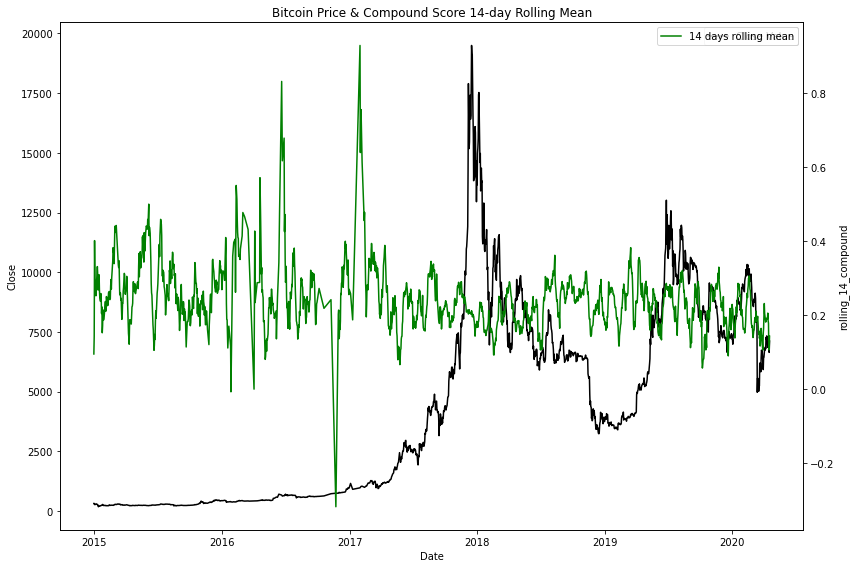

In [219]:
# Lineplot for bitcoin price & compound score 14-day rolling mean

fig, axes = plt.subplots(figsize=(12,8))
sns.lineplot(data=df_btc_roll, x="Date", y="Close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_compound", label="14 days rolling mean", color='green', ax=ax2)
plt.title("Bitcoin Price & Compound Score 14-day Rolling Mean")
plt.tight_layout()

In [220]:
# General Testing
stats.pearsonr(df_btc_roll['Close'], df_quote_count['rolling_14_compound'])

(0.10301178893946988, 2.2185753783349438e-05)

Although it may seem strange from the line plot, the general pearson test shows us the compound score actually has a weak positive correlation with the fluctuation of Bitcoin price. By checking the line plot, we speculate that this correlation comes mainly from after 2017. Now we conduct separated correlation testing to test our hypothesis.

In [221]:
# Separation Testing
separation_pearson(df_btc_roll, df_quote_count, 'rolling_14_compound')

2015: r = 0.04861662133602085, p = 0.38308133167734476 

2016: r = 0.1283886684441875, p = 0.06589608508414443 

2017: r = 0.44239157777588056, p = 3.477219304654442e-11 

Event Period: r = 0.2677525421882275, p = 7.886922115500111e-05 

2018: r = 0.1683716087476475, p = 0.005201529116267622 

2019: r = 0.2622357141420263, p = 4.020318084329049e-07 

2020: r = -0.13171339460834364, p = 0.17834603661354168 



**Positive Score**

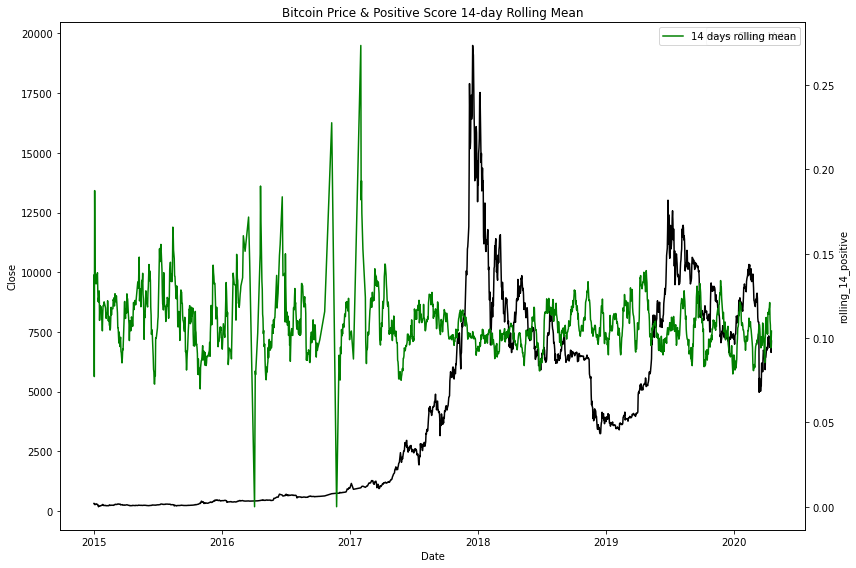

In [222]:
# Lineplot for bitcoin price & positive score 14-day rolling mean

fig, axes = plt.subplots(figsize=(12,8))
# sns.set_palette("Paired")
sns.lineplot(data=df_btc_roll, x="Date", y="Close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_positive", label="14 days rolling mean", color='green', ax=ax2)
plt.title("Bitcoin Price & Positive Score 14-day Rolling Mean")
plt.tight_layout()

In [223]:
# General Testing (positively correlates by r=0.052)
stats.pearsonr(df_btc_roll['Close'], df_quote_count['rolling_14_positive'])

(0.05143364166237141, 0.03454727804755302)

The general pearson test shows a weak correlation between the Bitcoin price and the rolling mean of positive score. 

In [228]:
# Separation Testing
separation_pearson(df_btc_roll, df_quote_count, 'rolling_14_positive')

2015: r = 0.1113733012871887, p = 0.04515501146895335 

2016: r = 0.14870385011829307, p = 0.032909215689040504 

2017: r = 0.27931879119772207, p = 5.2150146998641545e-05 

Event Period: r = 0.2950624586827484, p = 1.2514441357526841e-05 

2018: r = 0.26191567101352287, p = 1.1201503490603935e-05 

2019: r = 0.17386609289072497, p = 0.0008793144161178103 

2020: r = -0.18749936165644115, p = 0.054274267152638396 



**Negative Score**

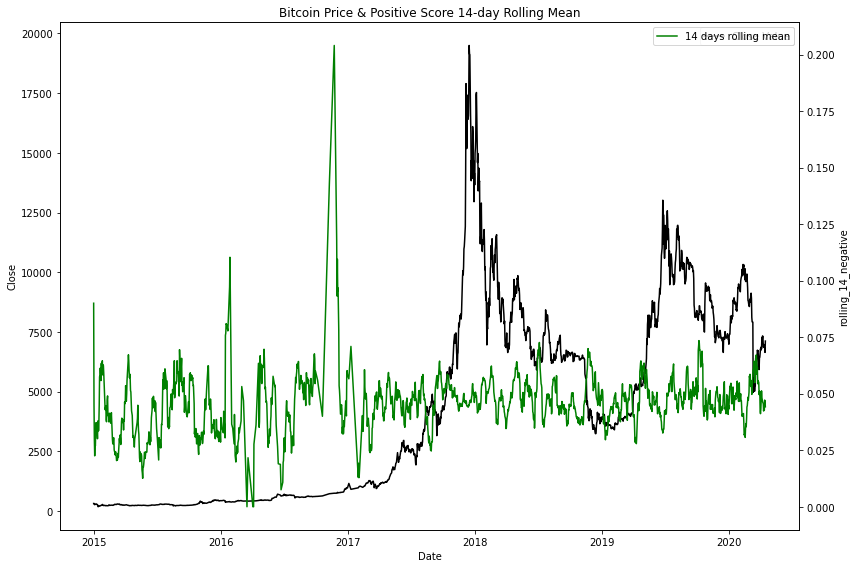

In [225]:
# Lineplot for bitcoin price & negative score 14-day rolling mean

fig, axes = plt.subplots(figsize=(12,8))
# sns.set_palette("Paired")
sns.lineplot(data=df_btc_roll, x="Date", y="Close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_negative", label="14 days rolling mean", color='green', ax=ax2)
plt.title("Bitcoin Price & Positive Score 14-day Rolling Mean")
plt.tight_layout()

In [226]:
# General Testing (negatively correlated by r=-0.127)
stats.pearsonr(df_btc_roll['Close'], df_quote_count['rolling_14_negative'])

(-0.1269619281544004, 1.6485466542035183e-07)

The general pearson test shows a stronger correlation compared to positive score, but it is negatively correlated.

In [227]:
# Separation Testing
separation_pearson(df_btc_roll, df_quote_count, 'rolling_14_negative')

2015: r = -0.03890797819592627, p = 0.4852390055232647 

2016: r = -0.24990200820458686, p = 0.00029166628074285376 

2017: r = -0.09532917989339056, p = 0.17500459498074472 

Event Period: r = -0.08985818927291078, p = 0.19248681099639356 

2018: r = 0.08033830210028925, p = 0.1848727909558742 

2019: r = -0.13333190299043565, p = 0.010993171869171092 

2020: r = 0.19417722467946757, p = 0.046097504377566906 



**Neutral Score**

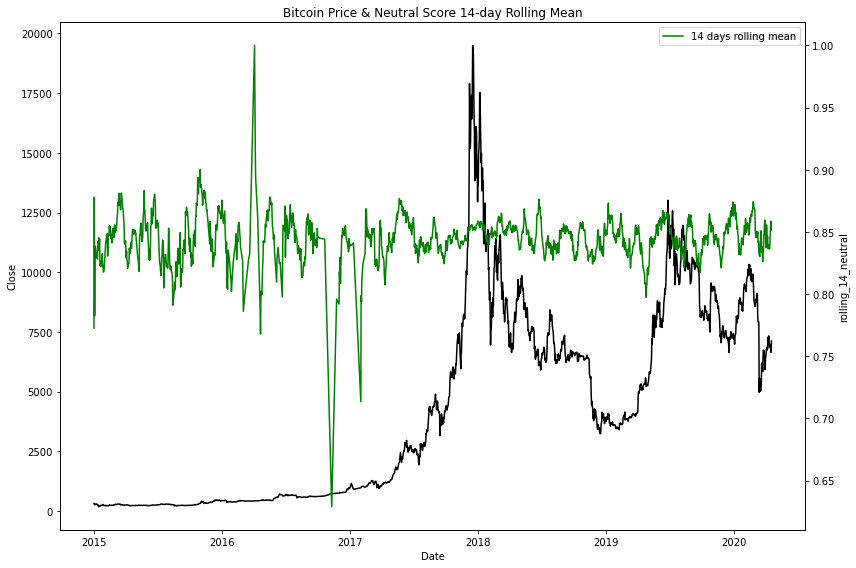

In [229]:
# Lineplot for bitcoin price & neutral score 14-day rolling mean

fig, axes = plt.subplots(figsize=(12,8))
# sns.set_palette("Paired")
sns.lineplot(data=df_btc_roll, x="Date", y="Close", label="Close Value", color='black', ax=axes)
ax2 = axes.twinx()
sns.lineplot(data=df_quote_count, x="date", y="rolling_14_neutral", label="14 days rolling mean", color='green', ax=ax2)
plt.title("Bitcoin Price & Neutral Score 14-day Rolling Mean")
plt.tight_layout()

In [230]:
# General Testing (p > 0.05, not correlated)
stats.pearsonr(df_btc_roll['Close'], df_quote_count['rolling_14_neutral'])

(0.04105259448275081, 0.09167669467471495)

In [231]:
# Separation Testing
separation_pearson(df_btc_roll, df_quote_count, 'rolling_14_neutral')

2015: r = -0.06862959421071096, p = 0.21794484774834708 

2016: r = 0.07657657870451655, p = 0.27395498428667375 

2017: r = -0.2806530488589203, p = 4.784441631867894e-05 

Event Period: r = -0.190083083527626, p = 0.0054922438356481565 

2018: r = -0.3234408952310596, p = 4.317314705096046e-08 

2019: r = -0.08413905678376774, p = 0.10951557023106753 

2020: r = 0.033539869849920016, p = 0.7328658656448522 



**Wrapping Up**

* General
 * Compound: **(+) correlated**
 * Positive: **(+) correlated**
 * Negative: **(-) correlated**
 * Neutral: **not correlated**


* Separation
 * Compound
   * (+) correlated: **2016, 2017.01-2017.08, Event Period, 2018.04-2018.12, 2019**
   * not correlated: **2015, 2020**
 * Positive
   * (+) correlated: **2015, 2016, 2017.01-2017.08, Event Period, 2018.04-2018.12, 2019**
   * not correlated: **2020**
 * Negative
   * (-) correlated: **2016, 2019, 2020**
   * not correlated: **2015, 2017.01-2017.08, Event Period, 2018.04-2018.12**
 * Neutral
   * not correlated: **2015, 2016, 2019, 2020**
   * (-) correlated: **2017.01-2017.08, Event Period, 2018.04-2018.12**

**Summary**:
* The result of general analysis on compound, positive, and negative sentiment scores reveals that crypto-related quotations' sentiment does have correlation with the Bitcoin price. However, the pearson r for all four sentiment scores are relatively small, which means the correlations are not strong. Many factors will affect this correlation: the way we process the Bitcoin price and sentiment scores, unobserved covariates affecting speakers' attitude (which is unpredictable), and the quantitative limitation on # quotations in QuoteBank. 
* Separation analysis on the compound score and the positive score shows similar positive correlation from 2016 to 2019, whereas the negative score shows negative correlation only in 2016, 2019, and 2020. This correlation pattern may suggest that positive score determines the compound score correlation more than the negative score. 
* Separation analysis on the neutral score shows that in each separation during 2017-2018, neutral score is negatively correlated to Bitcoin price. Combining the fact that quotations are heavily distributed in these separations, this suggests that polarized crypto quotations may correlate to a decrease in Bitcoin price, which means the Bitcoin price would affect speakers' neutrality.